# TCC - Comparação de técnicas de Aprendizado de Máquina na previsão da direção dos retornos de ações do Ibovespa

Respondendo duas perguntas de imediato:
- Por que retornos e não preços? Os preços de uma ação podem ser interpretados como um passeio aleatório, comportamento de dados em que geralmente o melhor modelo para prever o próximo passo é simplesmente repetir o anterior. Random walks tem alta correlação entre a série e a própria série atrasada, indicando que o passado seria útil para prever o futuro, mas a correlação tem mais a ver com a tendência entre pontos do que com poder preditivo real. Uma série de retornos, estacionária, tem correlação irrelevante com ela mesma, mas tem mais poder preditivo real na decisão de comprar ou vender uma ação baseando-se nos movimentos dela, e melhor ainda se for utilizada uma classificação dos movimentos em vez de uma previsão numérica dos retornos, o que nos leva à paóxima questão.
- Por que classificação e não regressão? Como indicado por (Enke, 2005) https://www.sciencedirect.com/science/article/abs/pii/S0957417405001156, uma estratégia baseada em classificação da direção dos retornos tem um melhor ganho ajustado ao risco. Uma classificação positiva ou negativa em relação a se uma ação terá retorno positivo ou negativo transforma a saída do modelo em uma informação acionável, além de que tentar prever um valor numérico em uma série altamente volátil é mais difícil do que apenas dizer a direção do retorno.

- O presente trabalho tem como objetivo comparar técnicas de aprendizado de máquina na previsão da direção dos retornos de ações do Ibovespa;
- Serão treinados 3 modelos de redes neurais recorrentes: LSTM, GRU e uma RNN básica sem memória de curto prazo. Além desses, será utilizada uma Rrandom Forest para manter um modelo de Machine Learning "clássico" como meio de comparação, e um modelo aleatório que realiza adivinhação aleatória a cada passo;
- Serão criadas duas classes: True (1) -> retornos serão maiores que 0; False (0) -> retornos serão menores ou iguais a zero;
- Será utilizado um esquema de janela rolante para treino/teste, com periodos de treino de 120 dias e 30 dias de teste non-overlapping, sendo cada previsão feita utilizando os 5 dias prévios ao dia predito (lag 5);
- Cada modelo será treinado/testado 60 vezes, para contabilizar a aleatoriedade na inicialização de redes neurais e a aleatoriedade de bootstrapping/splitting na random forest
- Os modelos serão comparados por métricas de avaliação clássicas como acurácia, F1, precisão, recall, além da performance do portfólio predito por vias de Sharpe ratio (métrica de avaliação do retorno de portfólios ajustado ao risco) e retornos acumulados;
- Obs.: Não será considerado o pagamento de dividendos das ações;
- 5 ações do Ibovespa foram selecionadas com base em 2 critérios: 1. não serem empresas estatais, 2. valor de mercado no dia da coleta de dados
- Os modelos serão treinados em um Intel i5 13th gen (i5-1335U) 1.3GHz, 8GB de RAM

## Importando dados e libs

In [1]:
# system
import os
import pickle
from datetime import datetime

# data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable

# math
import numpy as np
import random

# stats, metrics, model selection
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import shapiro, pearsonr, kruskal
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import BaseCrossValidator
from sklearn.preprocessing import MinMaxScaler
from scikit_posthocs import posthoc_dunn

# models
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Input, Dense, GRU, SimpleRNN
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 21

np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)


2025-02-26 11:18:02.635743: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
abev3 = pd.read_csv("./stocks/ABEV3.csv")
bbdc3 = pd.read_csv("./stocks/BBDC3.csv")
itsa3 = pd.read_csv("./stocks/ITSA3.csv")
itub3 = pd.read_csv("./stocks/ITUB3.csv")
wege3 = pd.read_csv("./stocks/WEGE3.csv")

In [3]:
abev3.head()

Date  Price   Open   High    Low    Vol. Change %
0  10/04/2024  13.28  13.26  13.45  13.17  36.59M   -0.90%
1  10/03/2024  13.40  13.55  13.63  13.40  44.99M   -2.33%
2  10/02/2024  13.72  13.70  13.85  13.61  51.03M    0.88%
3  10/01/2024  13.60  13.20  13.72  13.13  65.79M    3.98%
4  09/30/2024  13.08  12.94  13.17  12.90  31.05M    1.24%

In [4]:
bbdc3.head()

Date  Price   Open   High    Low   Vol. Change %
0  10/04/2024  13.29  13.19  13.42  13.10  5.32M    0.30%
1  10/03/2024  13.25  13.28  13.42  13.14  5.28M   -0.97%
2  10/02/2024  13.38  13.30  13.54  13.27  8.59M    3.22%
3  10/01/2024  12.96  13.04  13.11  12.84  7.16M    0.54%
4  09/30/2024  12.89  13.05  13.08  12.87  5.90M   -1.13%

In [5]:
itsa3.head()

Date  Price   Open   High    Low     Vol. Change %
0  10/04/2024  10.63  10.57  10.68  10.55  114.10K    0.76%
1  10/03/2024  10.55  10.91  10.91  10.55  294.10K   -3.21%
2  10/02/2024  10.90  10.90  11.05  10.90  162.60K    0.46%
3  10/01/2024  10.85  11.07  11.07  10.79  432.30K   -2.08%
4  09/30/2024  11.08  11.12  11.16  11.00  122.70K   -0.63%

In [6]:
itub3.head()

Date  Price   Open   High    Low     Vol. Change %
0  10/04/2024  30.46  30.39  30.60  30.27  310.50K    0.20%
1  10/03/2024  30.40  31.01  31.02  30.30  386.90K   -2.22%
2  10/02/2024  31.09  30.90  31.43  30.90  343.80K    0.65%
3  10/01/2024  30.89  31.41  31.49  30.77  467.50K   -1.66%
4  09/30/2024  31.41  31.86  32.01  31.41  428.40K   -1.50%

In [7]:
wege3.head()

Date  Price   Open   High    Low   Vol. Change %
0  10/04/2024  54.50  54.36  54.98  54.26  4.82M   -0.18%
1  10/03/2024  54.60  54.76  55.00  53.95  4.47M   -1.36%
2  10/02/2024  55.35  56.13  56.37  55.14  5.12M   -0.95%
3  10/01/2024  55.88  55.00  56.22  54.80  8.03M    2.74%
4  09/30/2024  54.39  55.63  56.24  54.39  6.41M   -2.81%

Filtrando dataframes e convertendo data em Index. A data de início selecionada considera a data comum mais antiga entre todas as séries

In [8]:
START_DATE = "2007-10-04" # first register of price for WEGE3 -> latest beginner of series
END_DATE = "2024-10-04"

In [9]:
abev3 = abev3.filter(["Date", "Price"], axis=1)
bbdc3 = bbdc3.filter(["Date", "Price"], axis=1)
itsa3 = itsa3.filter(["Date", "Price"], axis=1)
itub3 = itub3.filter(["Date", "Price"], axis=1)
wege3 = wege3.filter(["Date", "Price"], axis=1)

abev3['Date'] = pd.to_datetime(abev3['Date'], format='%m/%d/%Y')
bbdc3['Date'] = pd.to_datetime(bbdc3['Date'], format='%m/%d/%Y')
itsa3['Date'] = pd.to_datetime(itsa3['Date'], format='%m/%d/%Y')
itub3['Date'] = pd.to_datetime(itub3['Date'], format='%m/%d/%Y')
wege3['Date'] = pd.to_datetime(wege3['Date'], format='%m/%d/%Y')

Verificando se está certo...

In [10]:
abev3.head()

Date  Price
0 2024-10-04  13.28
1 2024-10-03  13.40
2 2024-10-02  13.72
3 2024-10-01  13.60
4 2024-09-30  13.08

In [11]:
abev3 = abev3[(abev3["Date"] >= START_DATE) & (abev3["Date"] <= END_DATE)]
abev3.tail()

Date  Price
4210 2007-10-10   3.04
4211 2007-10-09   3.08
4212 2007-10-08   3.06
4213 2007-10-05   3.06
4214 2007-10-04   2.99

In [12]:
bbdc3 = bbdc3[(bbdc3["Date"] >= START_DATE) & (bbdc3["Date"] <= END_DATE)]
bbdc3.tail()

Date  Price
4211 2007-10-10   6.35
4212 2007-10-09   6.38
4213 2007-10-08   6.31
4214 2007-10-05   6.30
4215 2007-10-04   6.00

In [13]:
itsa3 = itsa3[(itsa3["Date"] >= START_DATE) & (itsa3["Date"] <= END_DATE)]
itsa3.tail()

Date  Price
4151 2007-10-10   3.43
4152 2007-10-09   3.44
4153 2007-10-08   3.43
4154 2007-10-05   3.52
4155 2007-10-04   3.48

In [14]:
itub3 = itub3[(itub3["Date"] >= START_DATE) & (itub3["Date"] <= END_DATE)]
itub3.tail()

Date  Price
4210 2007-10-10   8.15
4211 2007-10-09   8.30
4212 2007-10-08   7.95
4213 2007-10-05   7.86
4214 2007-10-04   7.44

In [15]:
wege3 = wege3[(wege3["Date"] >= START_DATE) & (wege3["Date"] <= END_DATE)]
wege3.tail()

Date  Price
4210 2007-10-10   2.43
4211 2007-10-09   2.44
4212 2007-10-08   2.45
4213 2007-10-05   2.43
4214 2007-10-04   2.40

In [16]:
abev3.set_index('Date', inplace=True)
bbdc3.set_index('Date', inplace=True)
itsa3.set_index('Date', inplace=True)
itub3.set_index('Date', inplace=True)
wege3.set_index('Date', inplace=True)

In [17]:
def print_line_series(df: pd.DataFrame, title: str = "Series"):
    plt.figure(figsize=(30, 10))
    plt.title(title)
    plt.plot(df.Price)

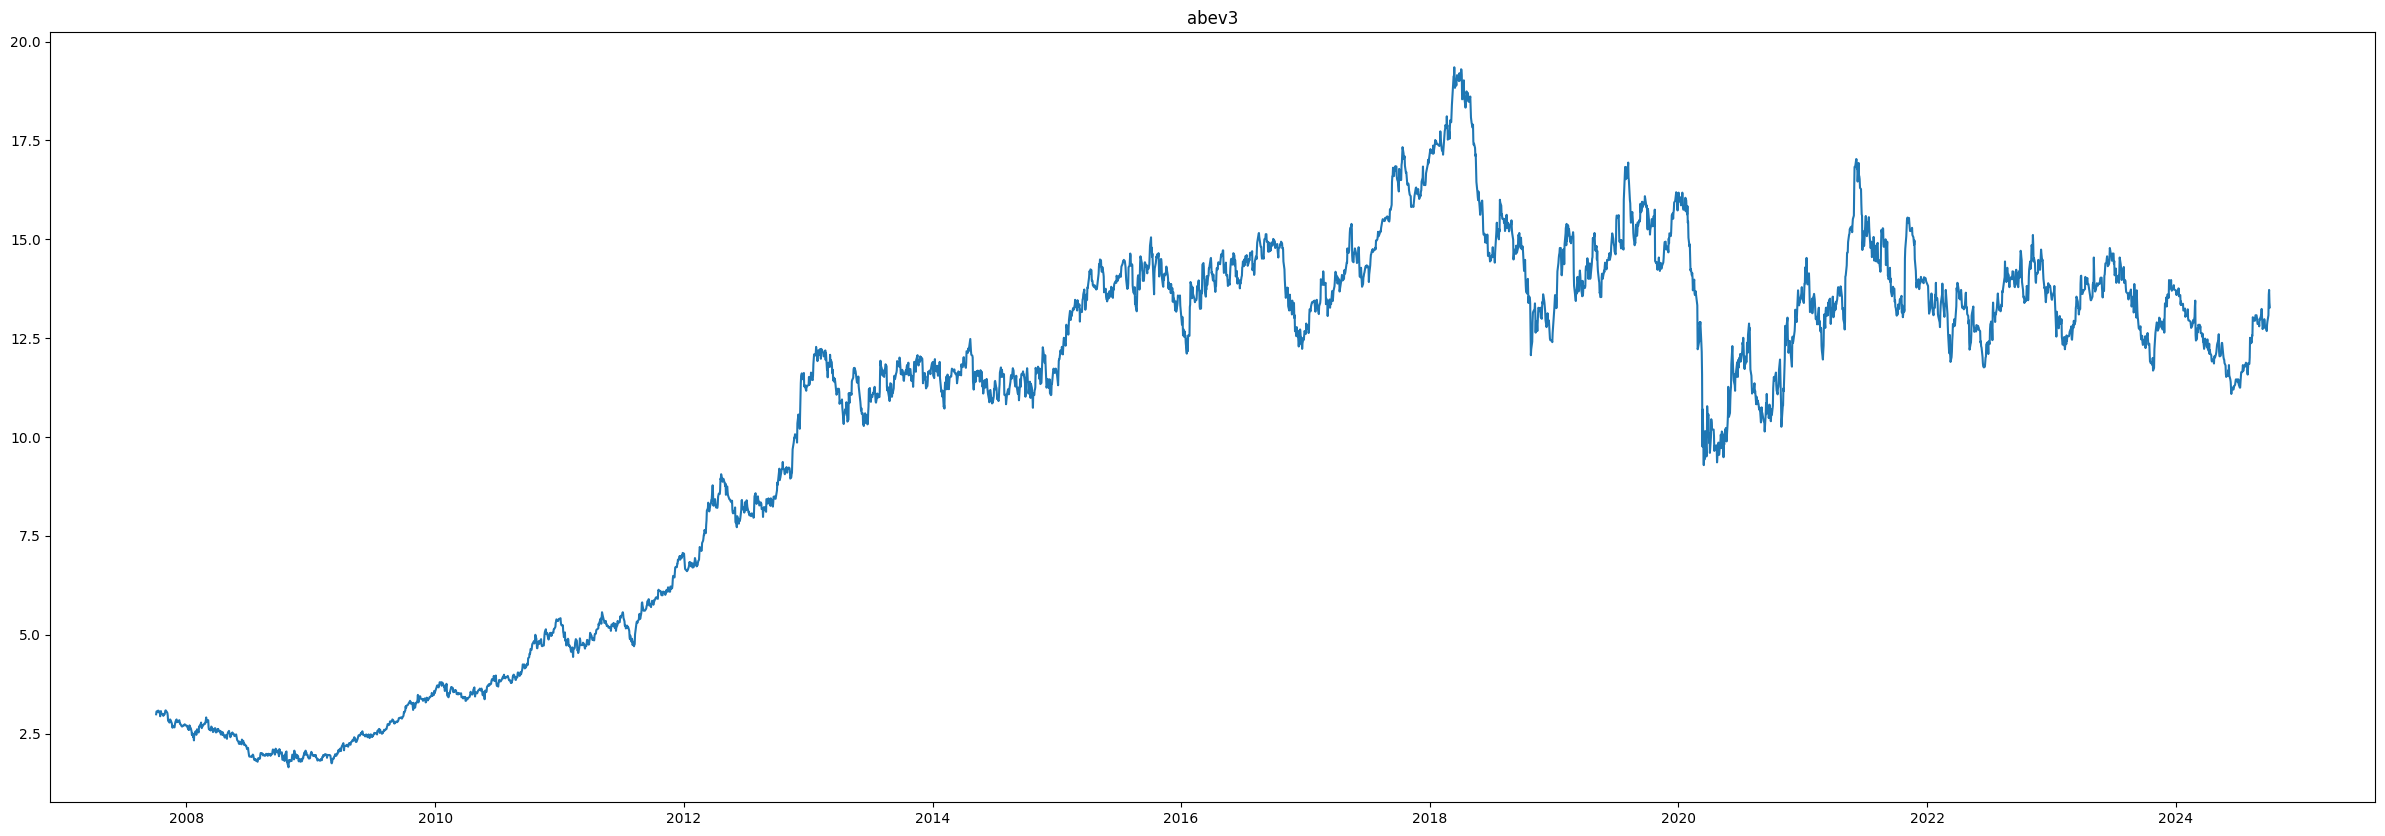

In [18]:
print_line_series(abev3, "abev3")

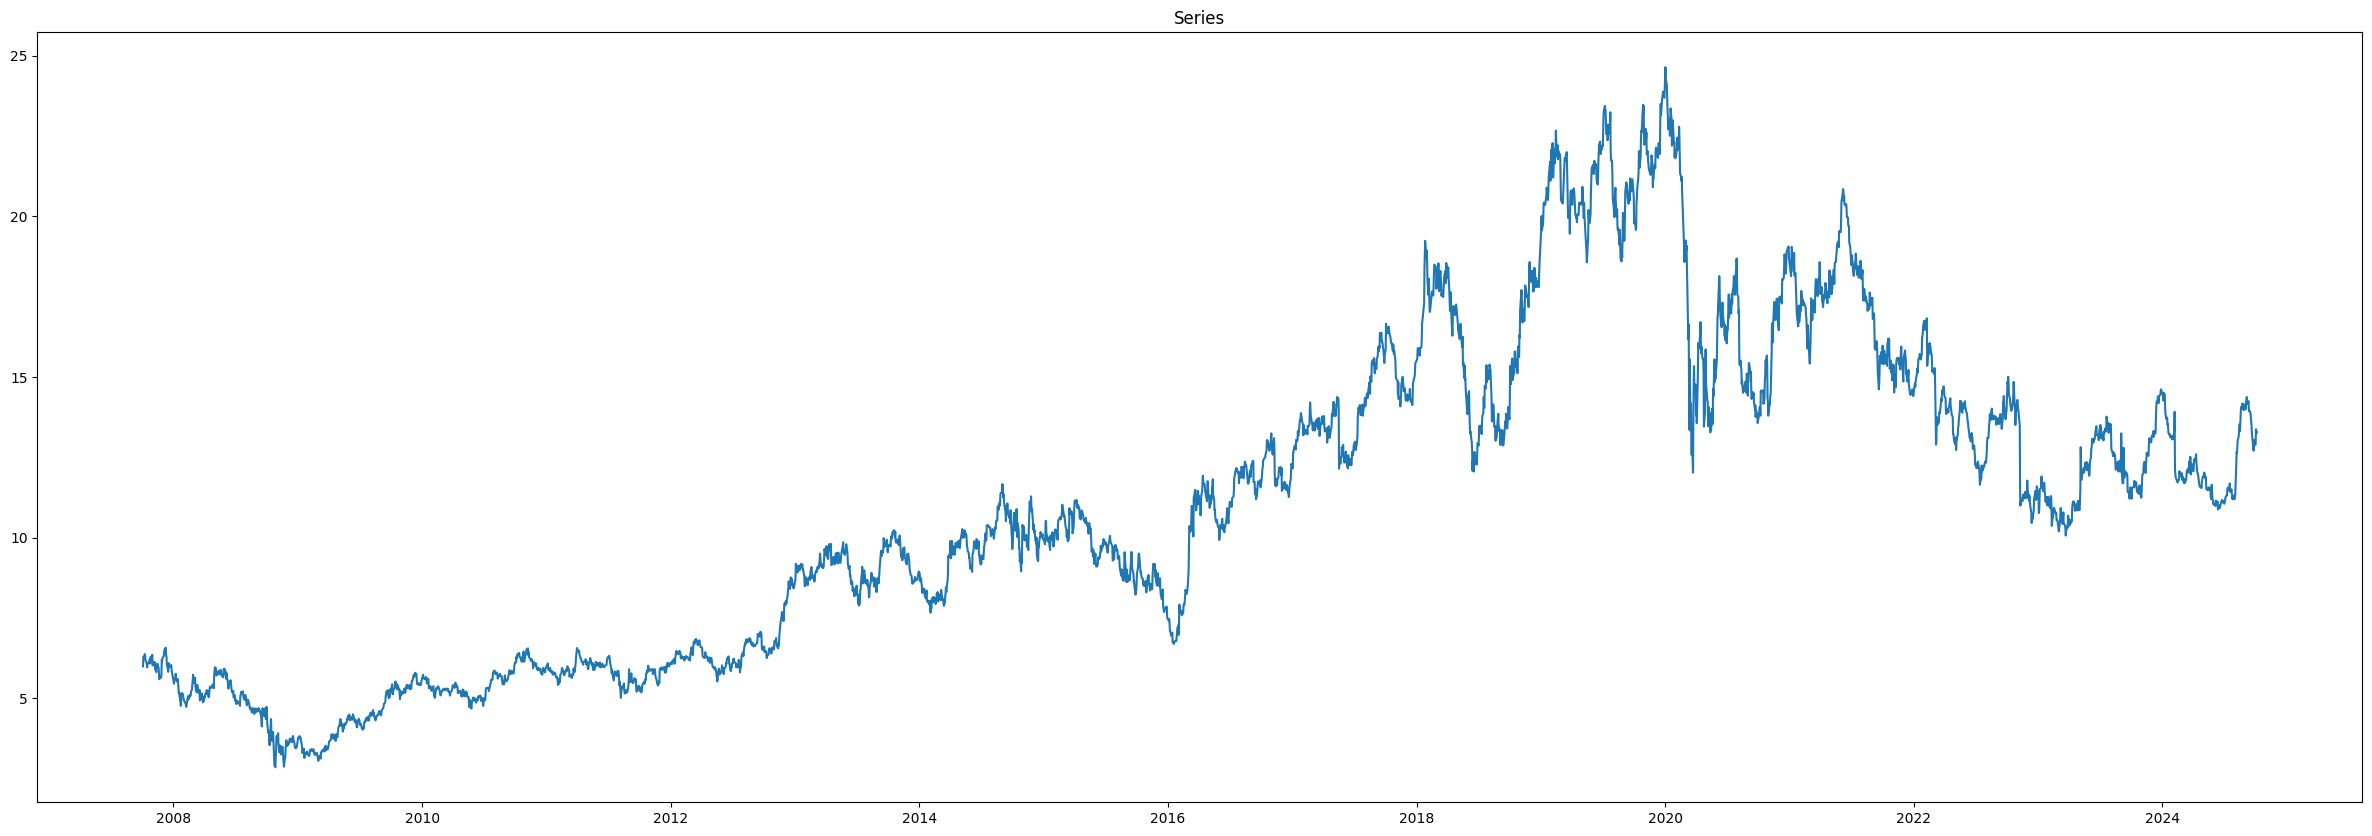

In [19]:
print_line_series(bbdc3)

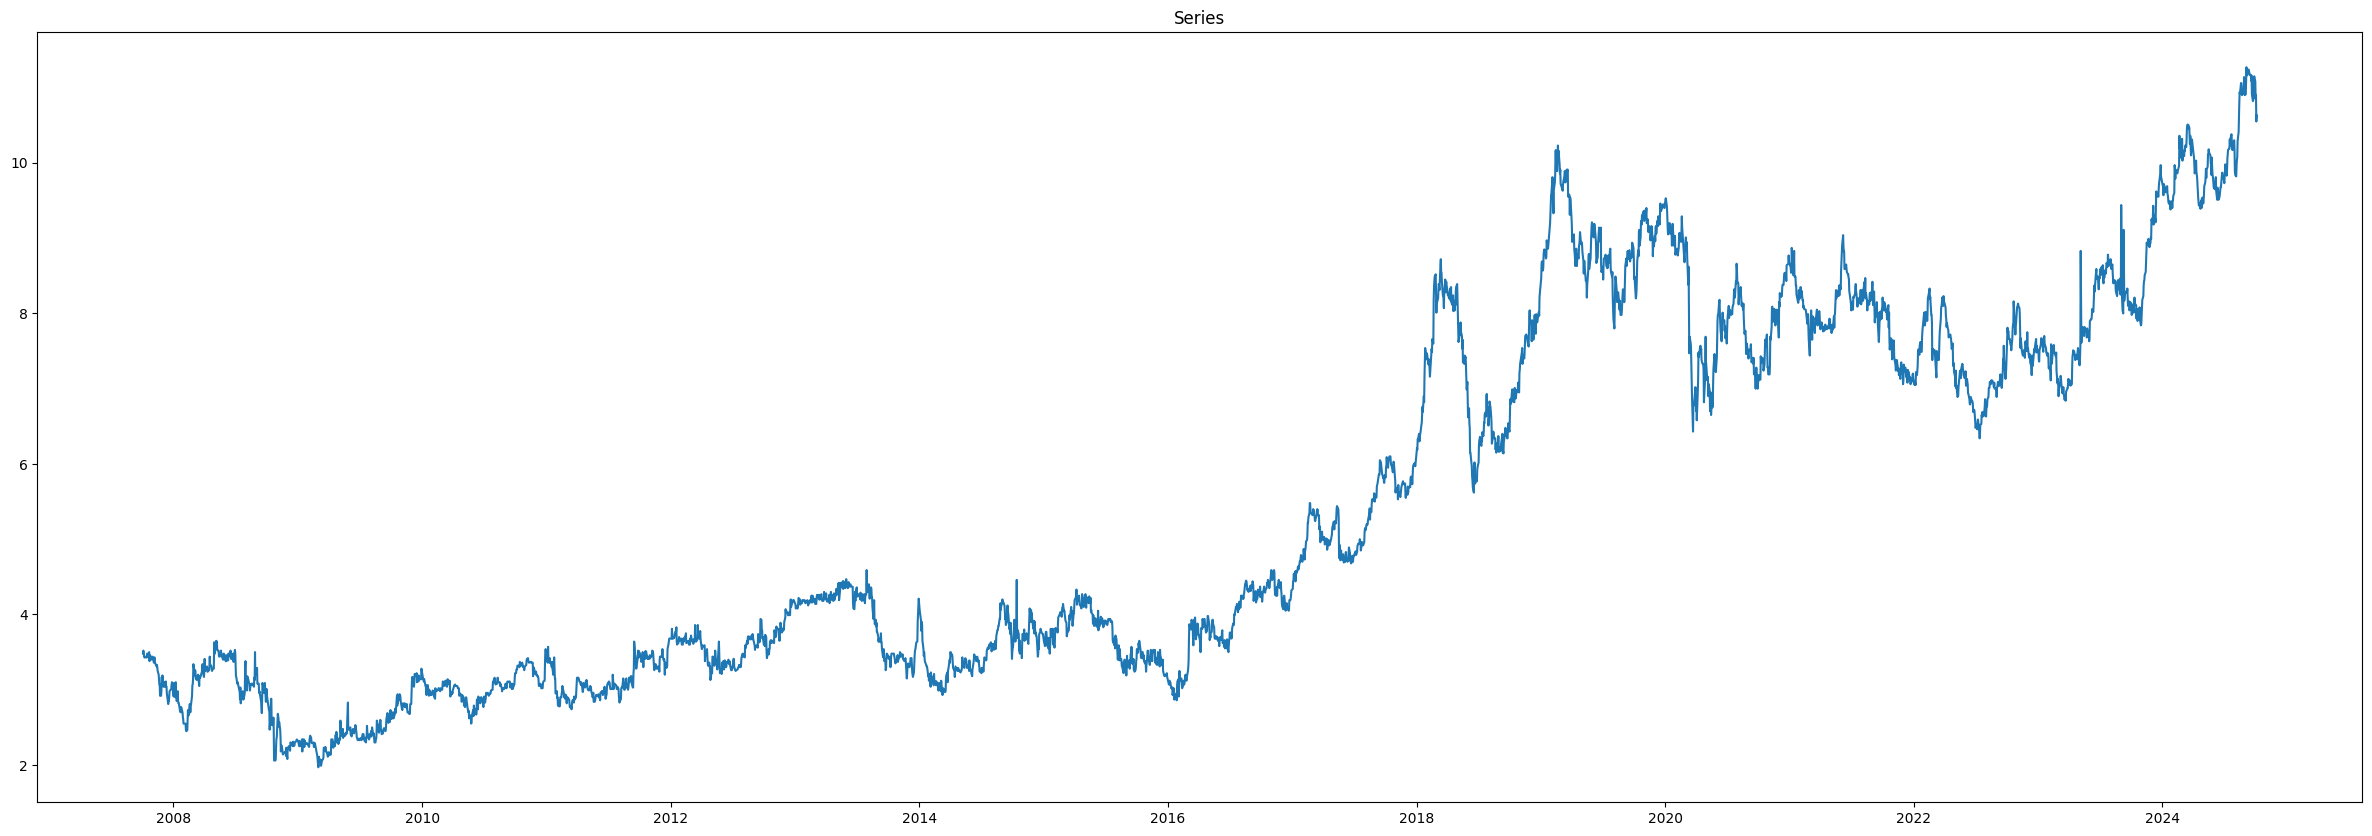

In [20]:
print_line_series(itsa3)

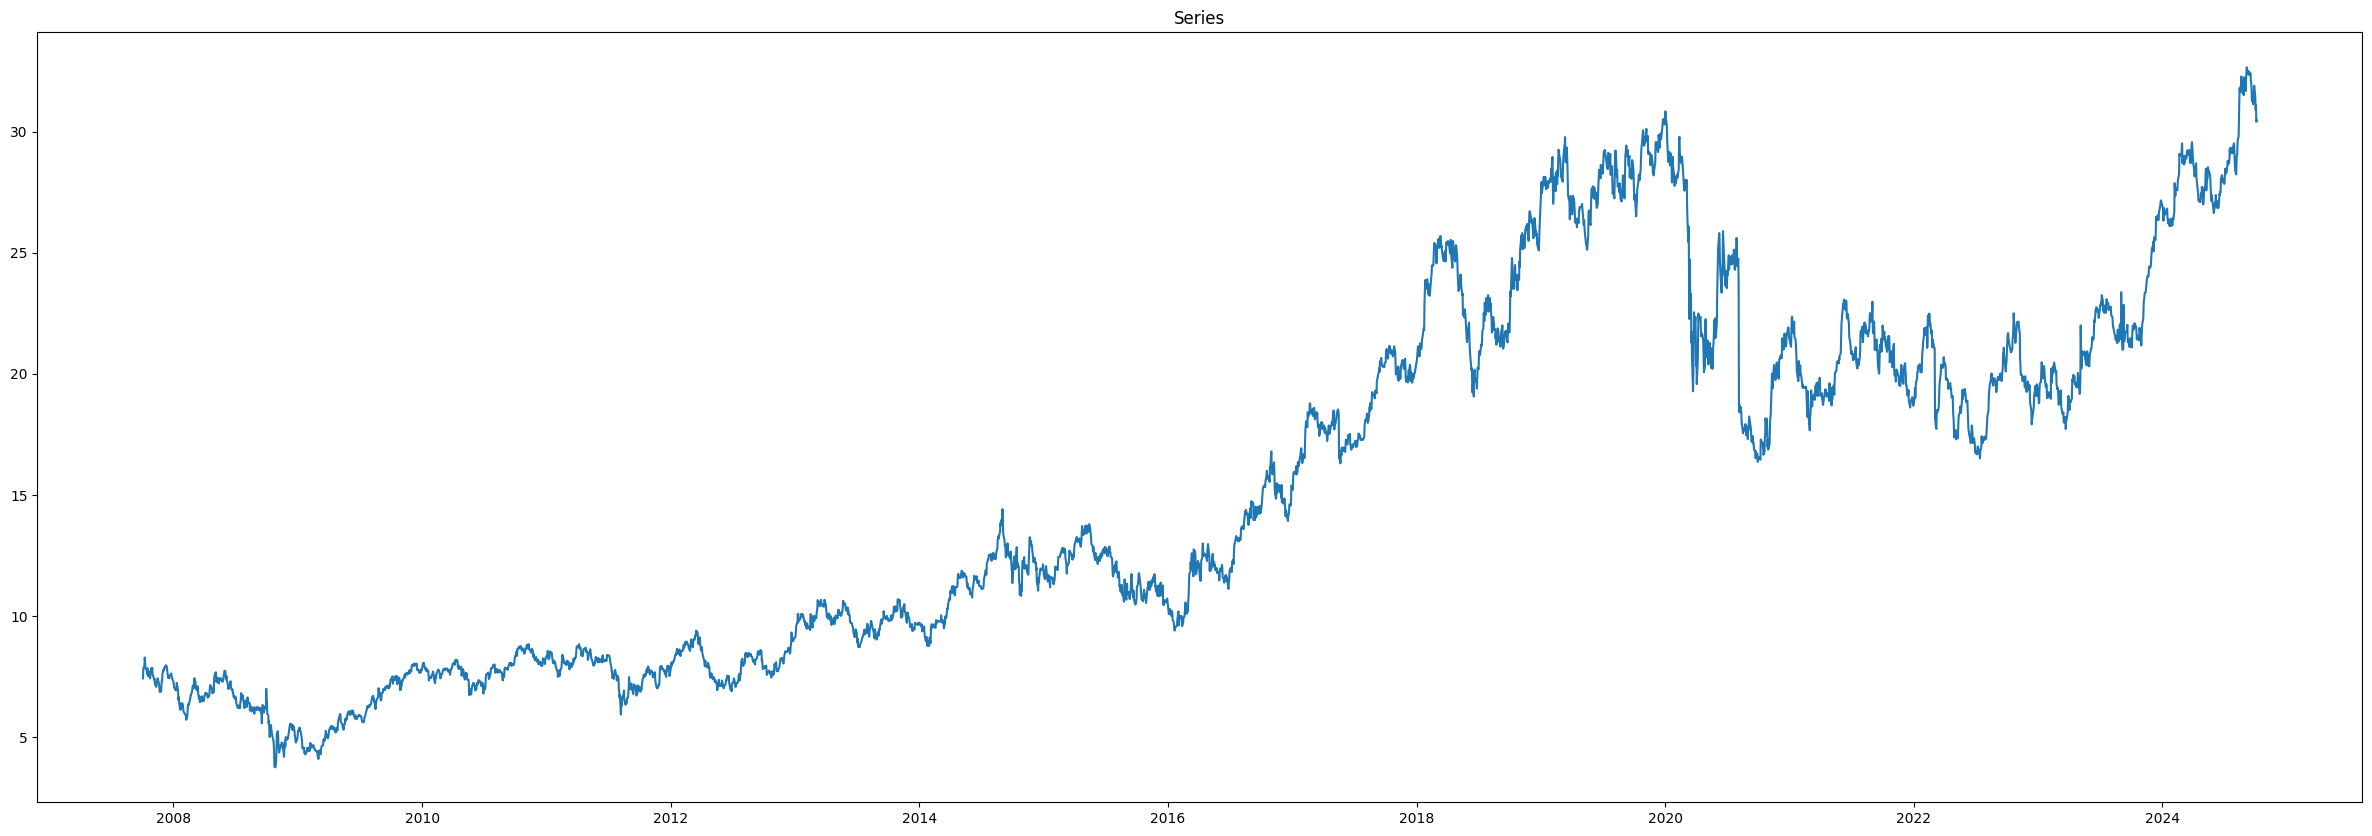

In [21]:
print_line_series(itub3)

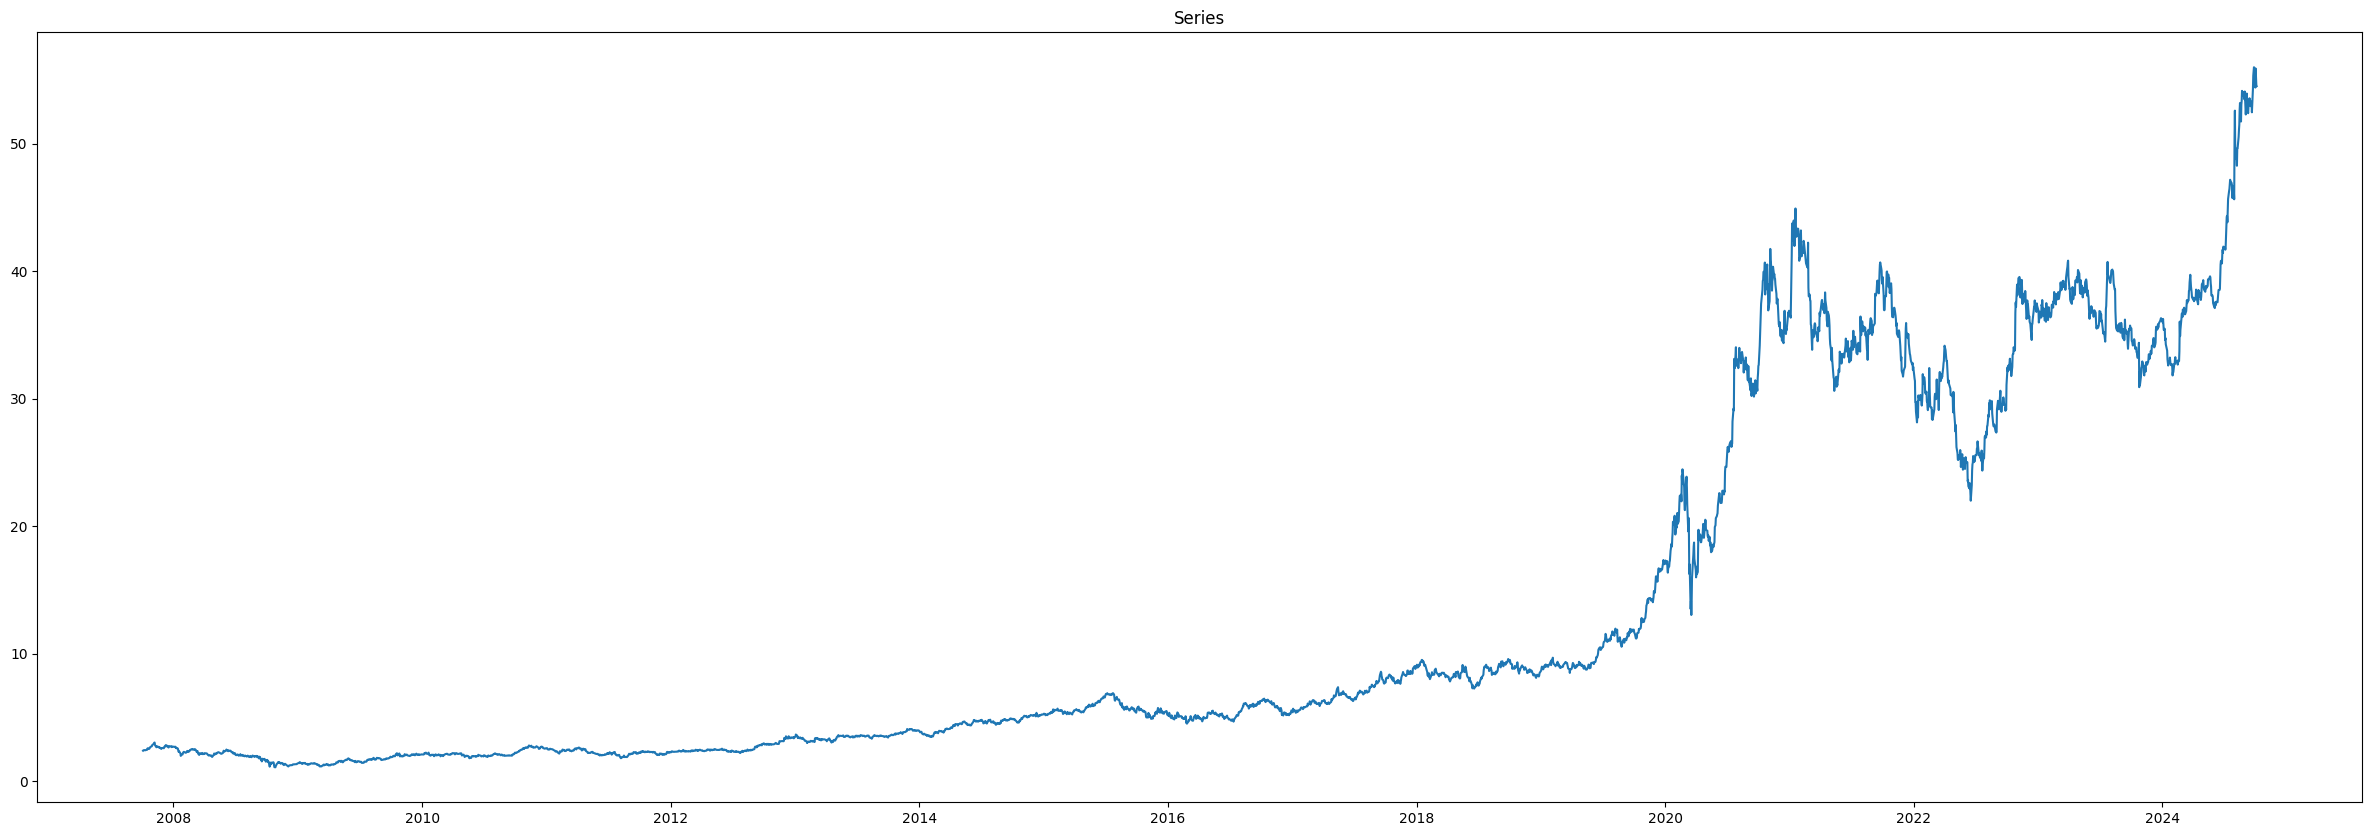

In [22]:
print_line_series(wege3)

## Lidando com dados faltantes

In [23]:
abev3.isna().sum()

Price    0
dtype: int64

In [24]:
bbdc3.isna().sum()

Price    0
dtype: int64

In [25]:
itsa3.isna().sum()

Price    0
dtype: int64

In [26]:
itub3.isna().sum()

Price    0
dtype: int64

In [27]:
wege3.isna().sum()

Price    0
dtype: int64

In [28]:
print(len(abev3))
print(len(bbdc3))
print(len(itub3))
print(len(itsa3))
print(len(wege3))

4215
4216
4215
4156
4215


Não há NaN nas séries, mas há discrepâncias no eixo temporal. Concatenando os DFs irá juntar o eixo temporal de todos eles, e as séries que não houverem registros de dias específicos passaram a ter NaN

In [29]:
stocks_df = pd.concat(
    [
        abev3.add_suffix("_abev3"), 
        bbdc3.add_suffix("_bbdc3"), 
        itub3.add_suffix("_itub3"), 
        itsa3.add_suffix("_itsa3"), 
        wege3.add_suffix("_wege3")
    ], 
    axis=1
)
stocks_df.head(10)

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3
Date                                                                       
2007-10-04         2.99         6.00         7.44         3.48         2.40
2007-10-05         3.06         6.30         7.86         3.52         2.43
2007-10-08         3.06         6.31         7.95         3.43         2.45
2007-10-09         3.08         6.38         8.30         3.44         2.44
2007-10-10         3.04         6.35         8.15         3.43         2.43
2007-10-11         3.08         6.20         7.87         3.43         2.44
2007-10-15         3.02         6.09         7.75         3.43         2.47
2007-10-16         2.94         5.97         7.61         3.48         2.47
2007-10-17         3.06         6.09         7.86         3.48         2.57
2007-10-18         3.07         6.09          NaN         3.48         2.59

In [30]:
stocks_df.isna().sum()

Price_abev3     1
Price_bbdc3     0
Price_itub3     1
Price_itsa3    60
Price_wege3     1
dtype: int64

In [31]:
def count_largest_missing_interval(df: pd.DataFrame, column: str):
    # Step 1: Create a mask for missing values in the specified column.
    mask = df[column].isna()

    # Step 2: Identify consecutive groups of NaNs using cumsum on the inverted mask.
    # Use (~mask).cumsum() to create a unique group number for consecutive NaNs.
    # Cumsum on the inverted mask will assign an increasing integer to each entry that is not NaN,
    # and repeat the last integer for each NaN entry.
    groups = (~mask).cumsum()

    # Step 3: Filter only the groups corresponding to NaN values.
    # Grouping by the assigned integers will create several unitary groups for not NaN entries,
    # and the NaN ones, that repeat the same integer, will be grouped together in sequence.
    nan_groups = stocks_df[mask].groupby(groups).size()

    # Step 4: Find the maximum size of consecutive NaNs. If a group has size > 1 it means it's
    # composed of NaNs. So the largest sequence is the max number of NaNs in sequence.
    max_nan_sequence_length = nan_groups.max() if not nan_groups.empty else 0

    # Step 5: Get the index range for this sequence if it exists.
    if max_nan_sequence_length > 0:
        longest_nan_group = nan_groups.idxmax()
        start_date = df[mask & (groups == longest_nan_group)].index.min()
        end_date = df[mask & (groups == longest_nan_group)].index.max()
        print(f"The length of the largest consecutive sequence of missing values in {column} is: {max_nan_sequence_length}")
        print(f"The time range for this sequence is from {start_date} to {end_date}")
    else:
        print(f"No missing values found in the {column} time series.")
    print("\n")


In [32]:
for col in [col for col in stocks_df.columns.tolist() if "Price_" in col]:
    count_largest_missing_interval(stocks_df, col)

The length of the largest consecutive sequence of missing values in Price_abev3 is: 1
The time range for this sequence is from 2024-05-25 00:00:00 to 2024-05-25 00:00:00


No missing values found in the Price_bbdc3 time series.


The length of the largest consecutive sequence of missing values in Price_itub3 is: 1
The time range for this sequence is from 2007-10-18 00:00:00 to 2007-10-18 00:00:00


The length of the largest consecutive sequence of missing values in Price_itsa3 is: 3
The time range for this sequence is from 2008-10-03 00:00:00 to 2008-10-07 00:00:00


The length of the largest consecutive sequence of missing values in Price_wege3 is: 1
The time range for this sequence is from 2024-05-25 00:00:00 to 2024-05-25 00:00:00




Considerando que a série de preços de ações se comporta de forma visualmente semelhante a passeios aleatórios com inclinação positiva, a suposição de que o melhor modelo para prever o próximo passo é repetir o anterior não se aplica pois não contabiliza a tendência da série. Nesse caso, será aplicada uma interpolação linear, considerando que os valores ausentes não constituem intervalos maiores que 3 valores sequenciais. https://people.duke.edu/~rnau/Notes_on_the_random_walk_model--Robert_Nau.pdf


In [33]:
exploration_df = stocks_df.interpolate(method="linear")

In [34]:
exploration_df.isna().sum()

Price_abev3    0
Price_bbdc3    0
Price_itub3    0
Price_itsa3    0
Price_wege3    0
dtype: int64

## Exploração

In [35]:
def compute_returns_for_prices(df: pd.DataFrame, column_names: list[str]):
    df = df.copy()
    for column in column_names:
        new_name = column.split("_")[1] if "_" in column else column
        df[f"Return_{new_name}"] = (df[column] / df[column].shift(1)) - 1
        df.dropna(inplace=True)
    return df

In [36]:
def shapiro_wilk_gaussian_test(array: np.ndarray):
    sw_stat, p_value = shapiro(array)

    alpha = 0.05

    print(f"Shapiro-Wilk Statistic: {sw_stat}")
    print(f"P-Value: {p_value}")

    if p_value < alpha:
        print(f"H0 rejected for an alpha of {alpha}, distribution can't be assumed Normal")
    else:
        print(f"Fail to reject H0 for an alpha of {alpha}, possibly normal distribution")
    
    return sw_stat, p_value

In [37]:
def adf_test(array: np.ndarray):
    alpha = 0.05
    result = adfuller(array)

    adf_stat = result[0]
    p_value = result[1]

    print('ADF Statistic:', adf_stat)
    print('p-value:', p_value)

    if p_value < alpha:
        print(f"H0 rejected for an alpha of {alpha}. Series is possibly stationary")
    else:
        print(f"H0 not rejected for an alpha of {alpha}. Series is possibly non-stationary")

    return adf_stat, p_value

In [38]:
exploration_df = compute_returns_for_prices(exploration_df, exploration_df.columns.tolist())
exploration_df.tail()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2024-09-30        13.08        12.89        31.41        11.08        54.39   
2024-10-01        13.60        12.96        30.89        10.85        55.88   
2024-10-02        13.72        13.38        31.09        10.90        55.35   
2024-10-03        13.40        13.25        30.40        10.55        54.60   
2024-10-04        13.28        13.29        30.46        10.63        54.50   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2024-09-30      0.012384     -0.011503     -0.015052     -0.006278   
2024-10-01      0.039755      0.005431     -0.016555     -0.020758   
2024-10-02      0.008824      0.032407      0.006475      0.004608   
2024-10-03     -0.023324     -0.009716     -0.022194     -0.032110   
2024-10-04     -0.008955      0.003019      0.001974      0.007583   

            Return_wege3  
Date                      
2024-09-30     -0.028056  
2024-10-01      0.027395  
2024-10-02     -0.009485  
2024-10-03     -0.013550  
2024-10-04     -0.001832

### Estacionariedade

ADF Statistic: -11.426433608419805
p-value: 6.677842598959476e-21
H0 rejected for an alpha of 0.05. Series is possibly stationary
ADF Statistic: -28.644695020966108
p-value: 0.0
H0 rejected for an alpha of 0.05. Series is possibly stationary
ADF Statistic: -29.548670457689372
p-value: 0.0
H0 rejected for an alpha of 0.05. Series is possibly stationary
ADF Statistic: -26.054275337285414
p-value: 0.0
H0 rejected for an alpha of 0.05. Series is possibly stationary
ADF Statistic: -13.788318518029193
p-value: 9.02451119835645e-26
H0 rejected for an alpha of 0.05. Series is possibly stationary


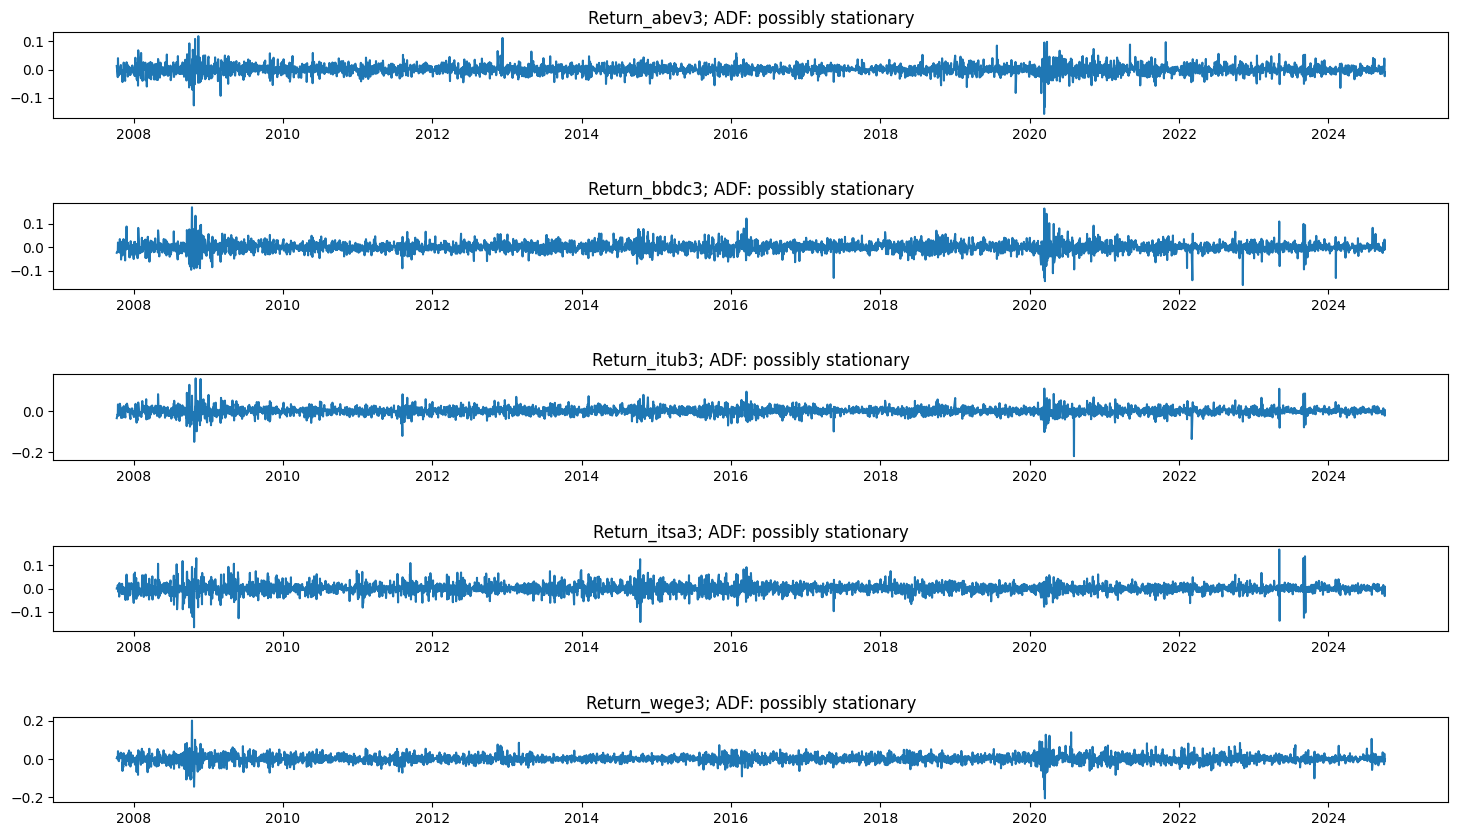

In [39]:
plt.figure(figsize=(18, 10))
for i, col in enumerate([col for col in exploration_df.columns.tolist() if "Return_" in col]):

    _, p_value = adf_test(exploration_df[col])

    plt.subplot(5, 1, i+1)
    plt.axis(True)
    plt.plot(exploration_df[col])
    plt.title(f"{col}; ADF: {'possibly stationary' if p_value < 0.05 else 'possibly non-stationary'}")
    plt.subplots_adjust(wspace=0.2, hspace=1.0)

O teste ADF com um alpha de 5% corrobora para todas as séries uma probabilidade próxima a 0 de observar séries como essas assumindo que ela são não-estacionárias, portanto, rejeitamos a hipótese nula de não-estacionariedade. Observa-se que as séries de retornos se comportam como séries de ruído, corroborando com o conhecimento da dificuldade de se trabalhar com esse tipo de série por causa da ínfima proporção sinal:ruído

### Autocorrelação

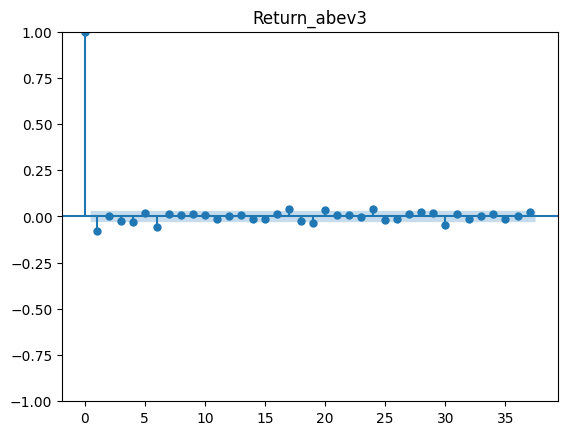

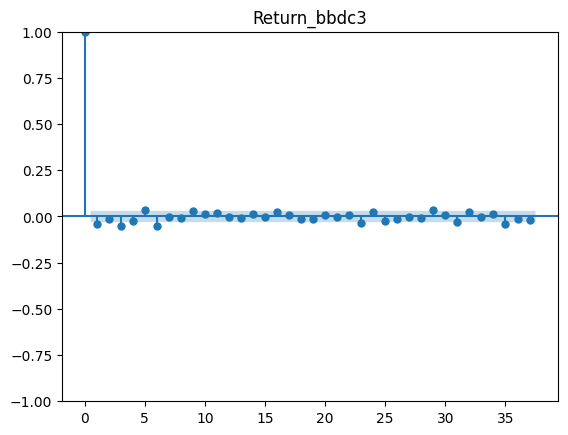

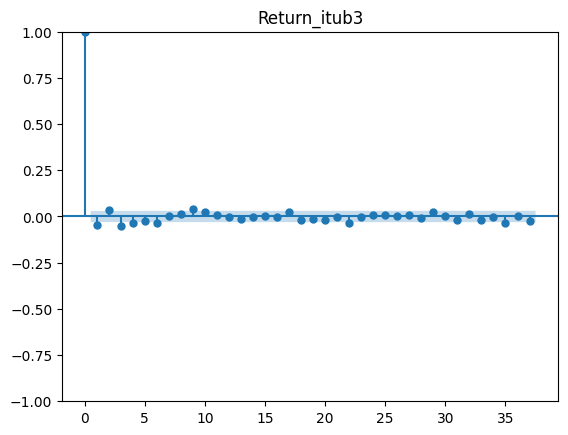

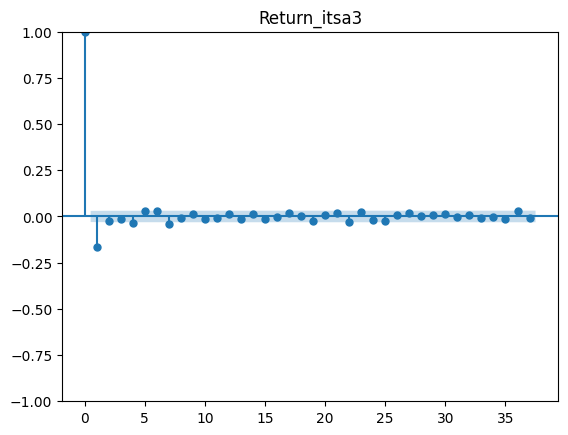

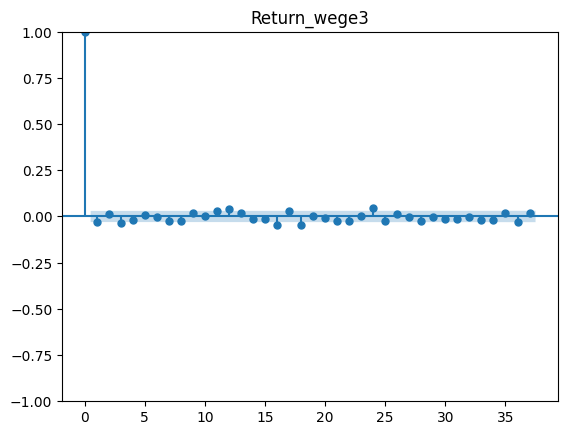

In [40]:
for i, col in enumerate([col for col in exploration_df.columns.tolist() if "Return_" in col]):
    plot_acf(exploration_df[col], title=col)
    plt.subplots_adjust(wspace=0.2, hspace=1.0)

As séries de retornos no geral não apresentam autocorrelação, exceto pela ITSA3 que apresenta um valor um pouco acima do limiar para o lag 1

In [41]:
return_cols_names = [col for col in exploration_df.columns.tolist() if "Return_" in col and "lag" not in col]

all_return_data = np.concatenate([exploration_df[col] for col in return_cols_names])
global_min_return = np.min(all_return_data)
global_max_return = np.max(all_return_data)

### Distribuições; Normalidade

Return_abev3
Shapiro-Wilk Statistic: 0.9404390537904097
P-Value: 3.4647563709880827e-38
H0 rejected for an alpha of 0.05, distribution can't be assumed Normal

Return_bbdc3
Shapiro-Wilk Statistic: 0.9348584346672091
P-Value: 1.636872547307974e-39
H0 rejected for an alpha of 0.05, distribution can't be assumed Normal

Return_itub3
Shapiro-Wilk Statistic: 0.928262637934504
P-Value: 5.755061300774304e-41
H0 rejected for an alpha of 0.05, distribution can't be assumed Normal

Return_itsa3
Shapiro-Wilk Statistic: 0.9314833558580566
P-Value: 2.8571418135973056e-40
H0 rejected for an alpha of 0.05, distribution can't be assumed Normal

Return_wege3
Shapiro-Wilk Statistic: 0.938757809286279
P-Value: 1.349529728620439e-38
H0 rejected for an alpha of 0.05, distribution can't be assumed Normal



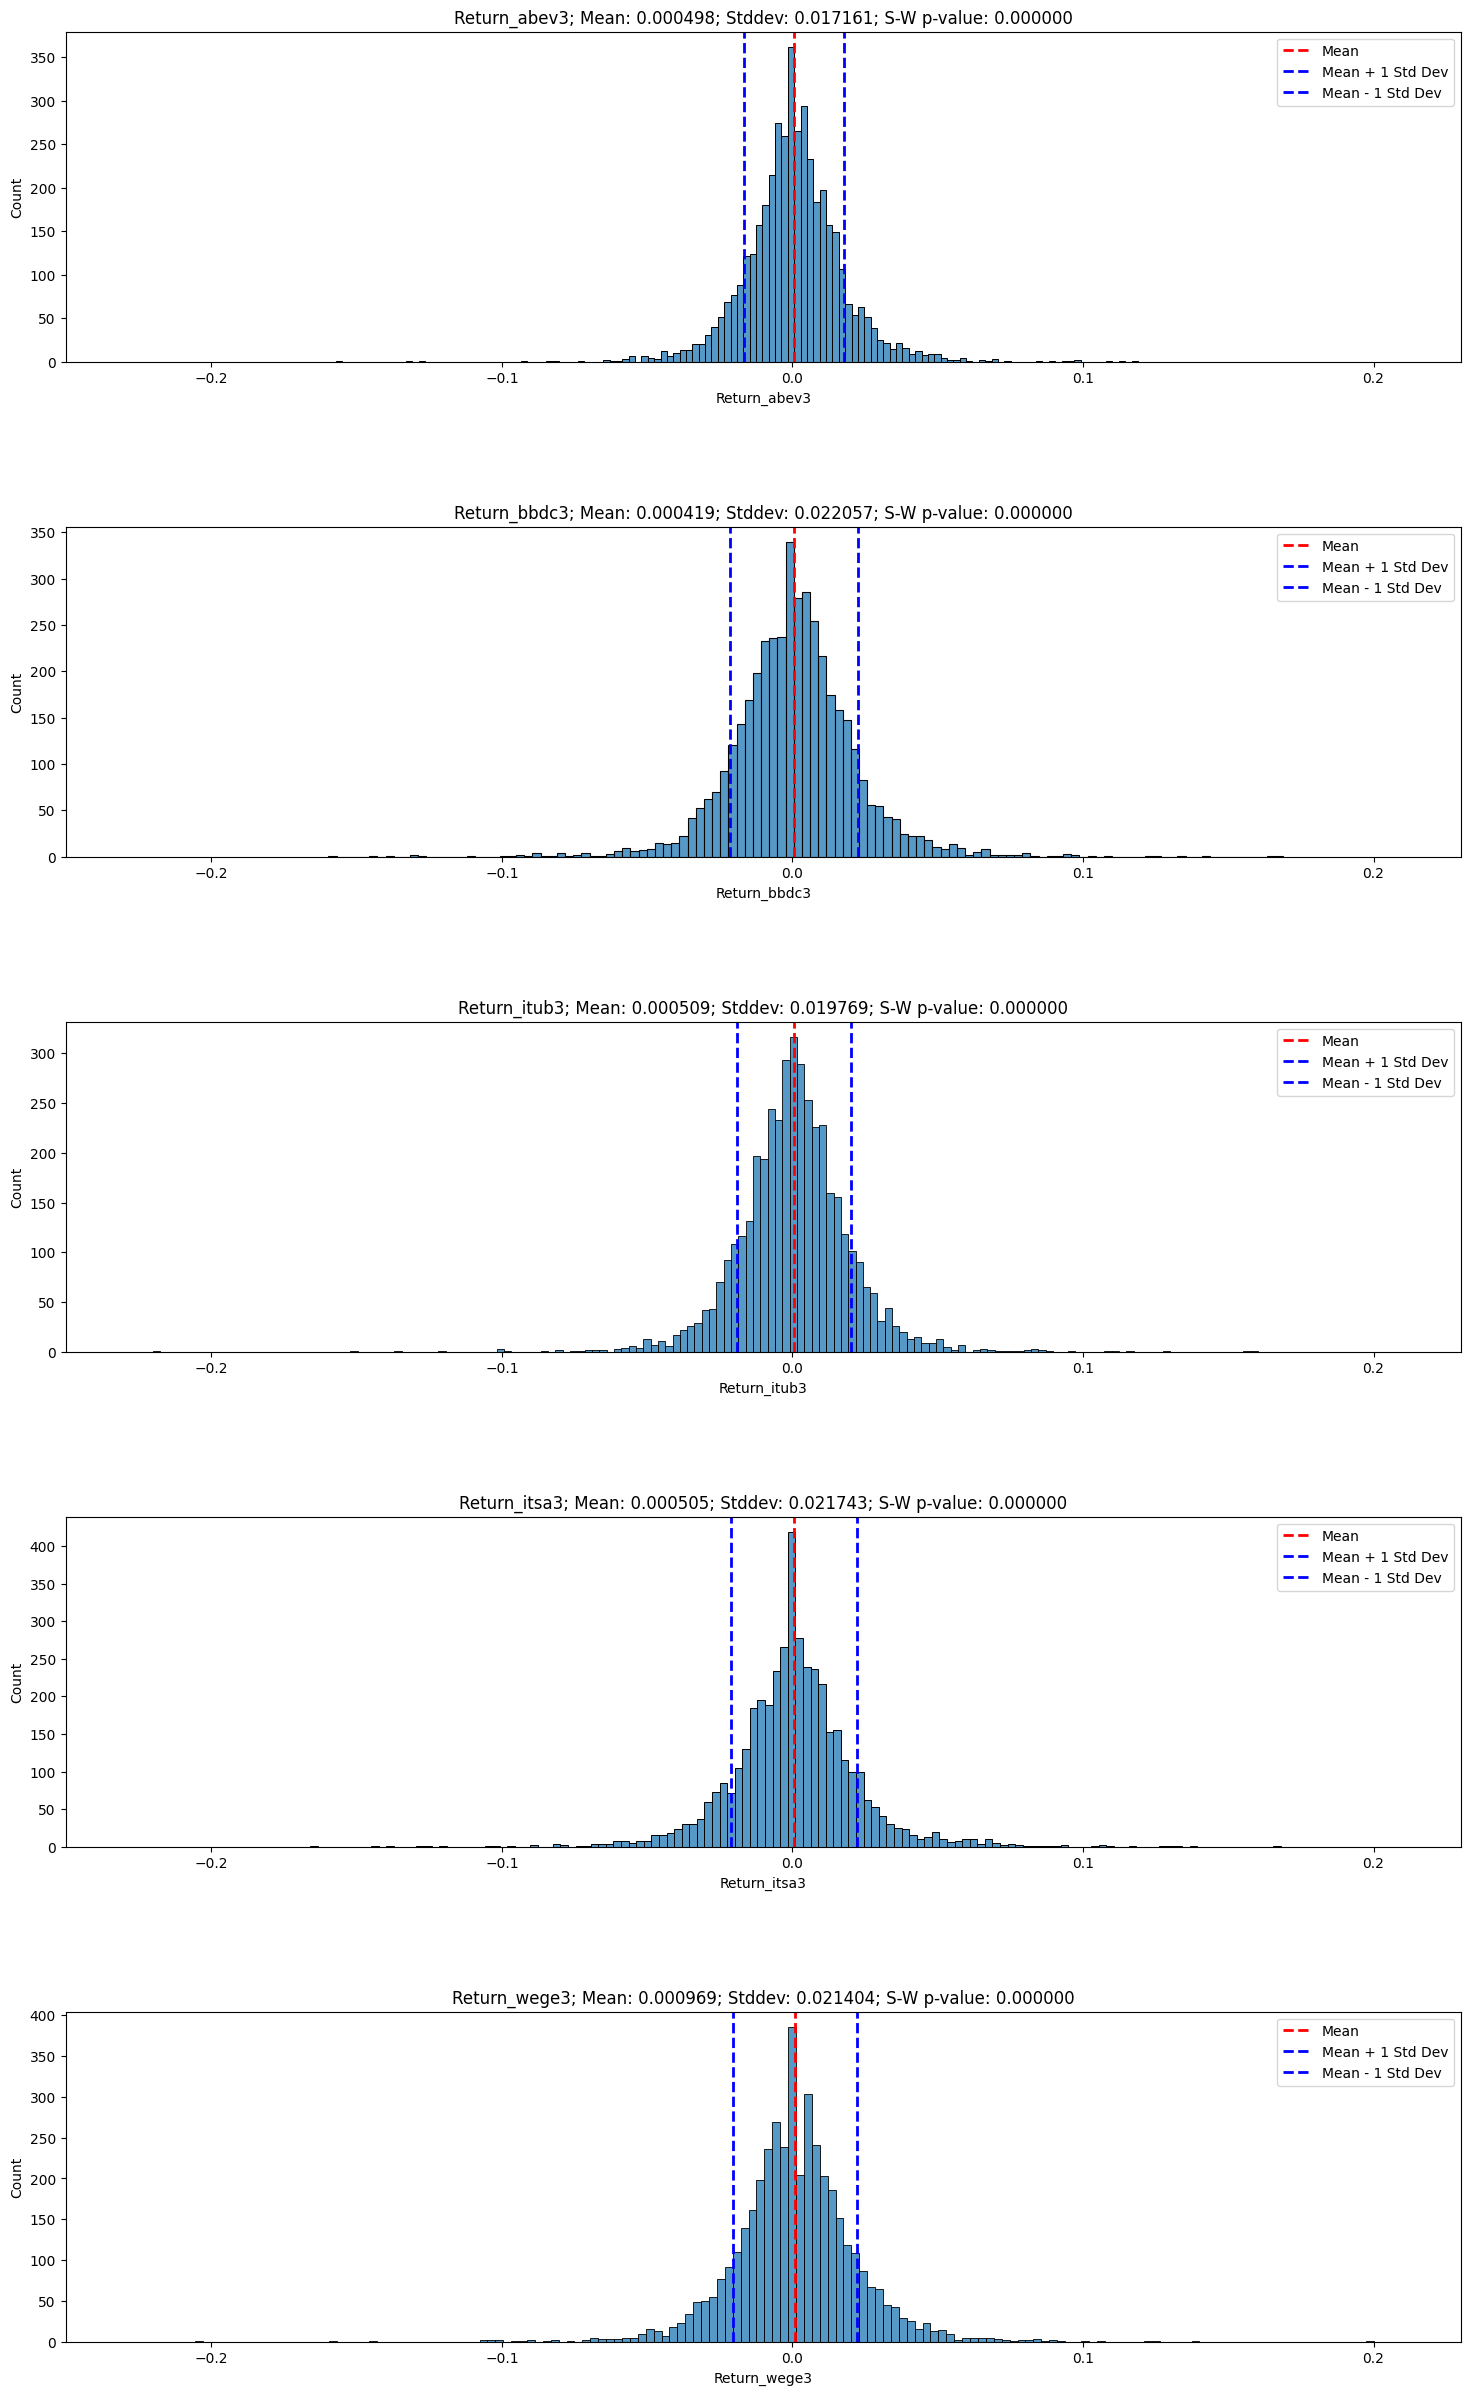

In [42]:
plt.figure(figsize=(18, 30))
for i, col in enumerate(return_cols_names):

    print(col)
    _, p_value = shapiro_wilk_gaussian_test(exploration_df[col])
    print("")

    mean = np.array(exploration_df[col]).mean()
    std = np.array(exploration_df[col]).std()

    plt.subplot(5, 1, i+1)
    plt.axis(True)
    sns.histplot(data=exploration_df, x=col, kde=False)
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean')
    plt.axvline(mean + std, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std Dev')
    plt.axvline(mean - std, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std Dev')
    plt.title(f"{col}; Mean: {mean:.6f}; Stddev: {std:.6f}; S-W p-value: {p_value:.6f}")
    plt.legend(frameon=True)
    plt.xlim(global_min_return - 0.03, global_max_return + 0.03)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

Análise dos histogramas corrobora com a observação de que os dados não seguem uma distribuição normal de acordo com o teste de Shapiro-Wilk, possivelmente por causa da grande quantidade de outliers que puxam as caudas da distribuição para ambos os lados

### Correlações entre séries

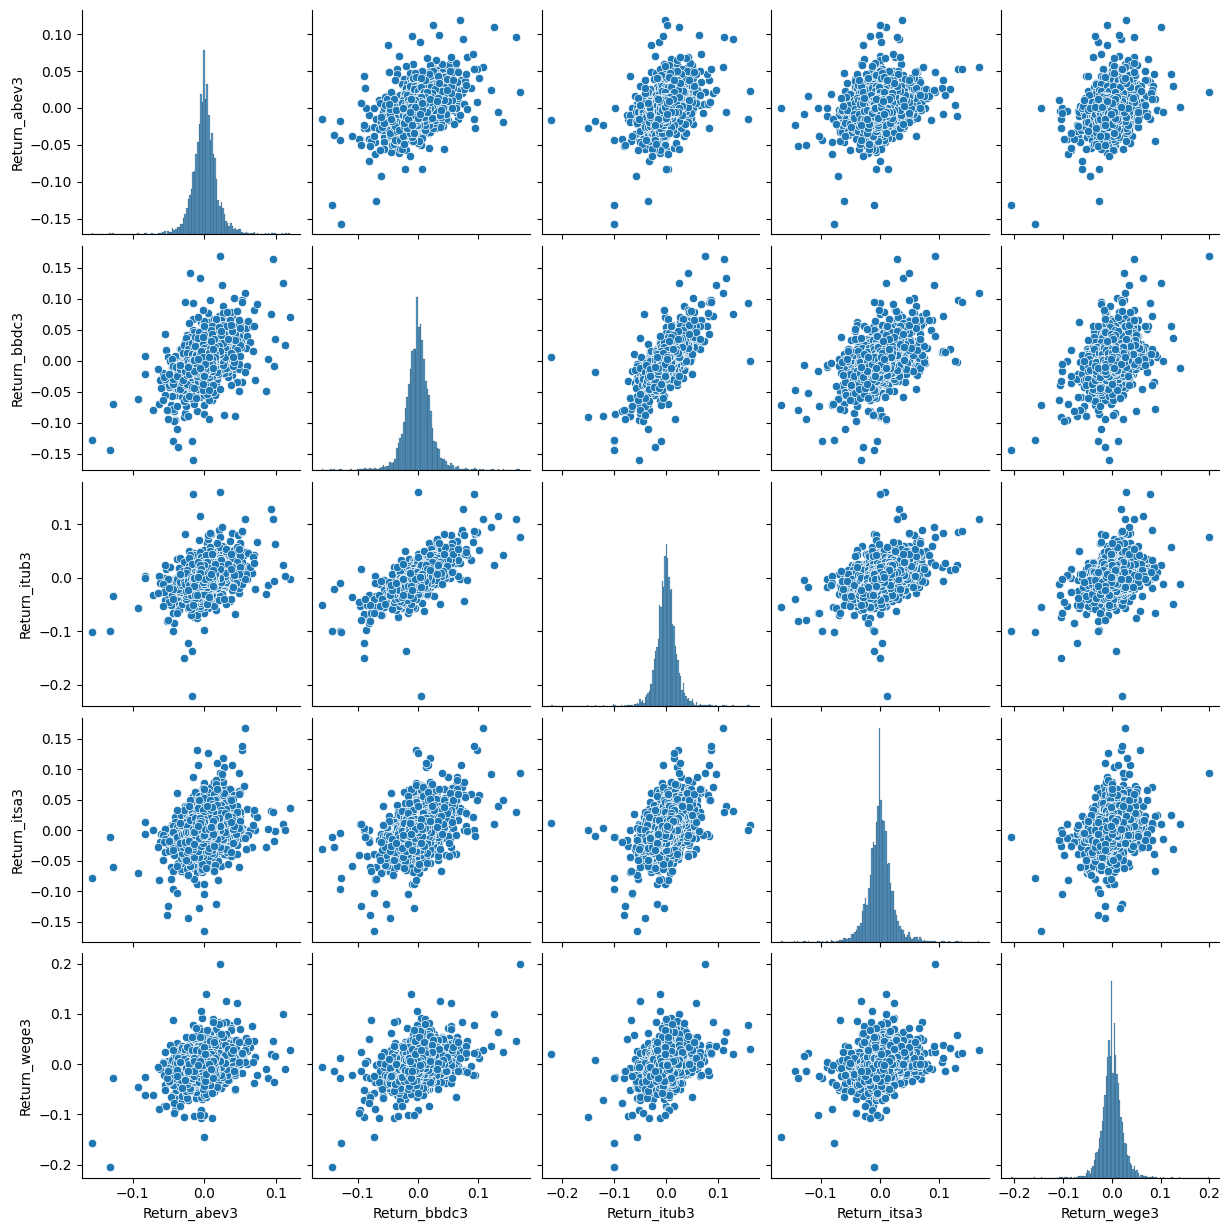

In [43]:
sns.pairplot(exploration_df[[col for col in exploration_df.columns.tolist() if "Return" in col]])

<Axes: >

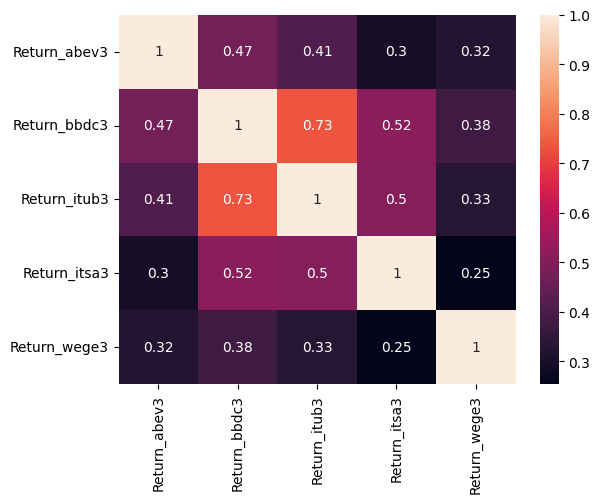

In [44]:
sns.heatmap(exploration_df[[col for col in exploration_df.columns.tolist() if "Return" in col]].corr(), annot=True)

O pairplot e o heatmap de correlação apontam que dificilmente qualquer uma série de retornos teria poder preditivo linear sobre as outras por não apresentarem uma correlação de Pearson significativa, exceto itub3 e bbdc3, o que faz sentido pois são duas ações do mesmo setor bancário, então movimentos de mercado que podem afetar uma delas também pode afetar a outra.

In [45]:
exploration_df[return_cols_names].describe()

Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  Return_wege3
count   4211.000000   4211.000000   4211.000000   4211.000000   4211.000000
mean       0.000498      0.000419      0.000509      0.000505      0.000969
std        0.017163      0.022060      0.019771      0.021746      0.021406
min       -0.157168     -0.159763     -0.220203     -0.165992     -0.205761
25%       -0.008318     -0.011242     -0.009860     -0.010506     -0.010100
50%        0.000000      0.000000      0.000000      0.000000      0.000000
75%        0.009434      0.011498      0.010580      0.010674      0.011955
max        0.118919      0.169014      0.160271      0.167989      0.200000

As séries de retornos são todas estacionárias e não seguem uma distribuição normal, de acordo com o teste ADF e o teste de Shapiro-Wilk, com uma média ligeiramente inclinada para o lado positivo. A média positiva indica que essas séries geraram retornos positivos com mais frequência do que negativos, e comprar e manter essas ações durante esse período resultaria, ao final, em um resultado financeiro positivo (isso não quer dizer que o resultado financeiro seja satisfatório). Todas as séries têm outliers bem acima e abaixo dos limites, o que pode estar influenciando o teste de Shapiro-Wilk a rejeitar a nula

### Correlação da série de preços vs Série de retornos

corr between Price_abev3 and itself lagged: PearsonRResult(statistic=0.9992001497341813, pvalue=0.0)
corr between Price_bbdc3 and itself lagged: PearsonRResult(statistic=0.9986171801430163, pvalue=0.0)
corr between Price_itub3 and itself lagged: PearsonRResult(statistic=0.9991605419974832, pvalue=0.0)
corr between Price_itsa3 and itself lagged: PearsonRResult(statistic=0.9989795140583535, pvalue=0.0)
corr between Price_wege3 and itself lagged: PearsonRResult(statistic=0.9995852267480806, pvalue=0.0)


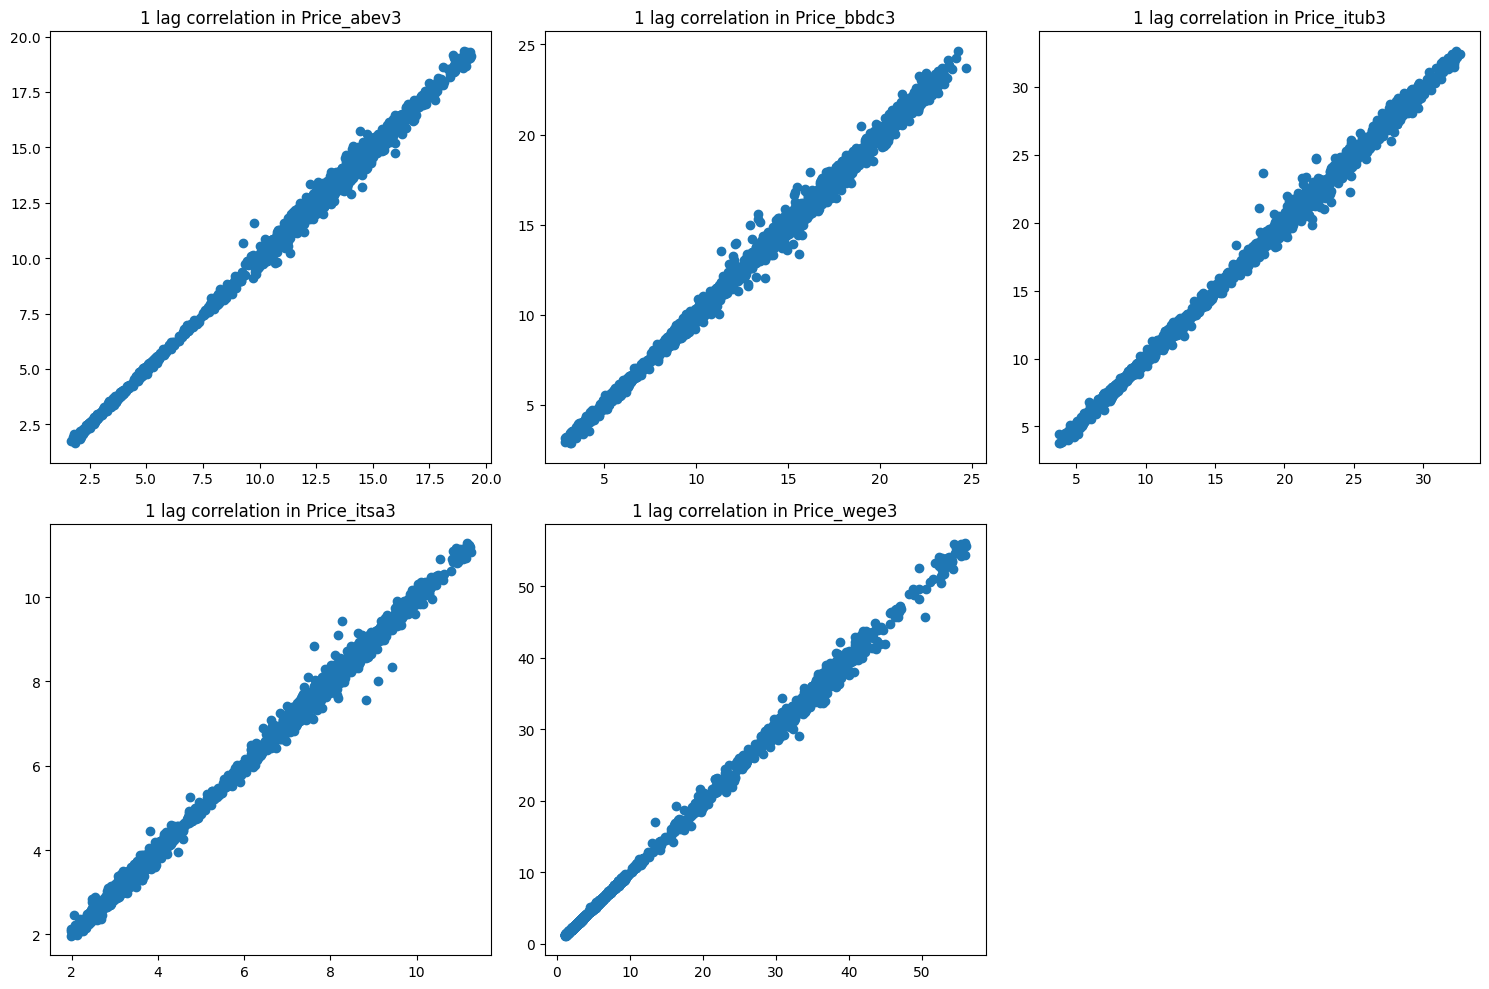

In [46]:
price_cols = [col for col in exploration_df.columns.tolist() if "Price" in col]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(price_cols):
    new_df = pd.DataFrame()
    new_df[col] = exploration_df[col]
    new_df[f"{col}_shifted"] = exploration_df[col].shift(1)
    new_df.dropna(axis=0, inplace=True)
    print(f"corr between {col} and itself lagged: {pearsonr(new_df[col], new_df[f'{col}_shifted'])}")

    axes[i].scatter(new_df[col], new_df[f'{col}_shifted'])
    axes[i].set_title(f"1 lag correlation in {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

corr between Return_abev3 and itself lagged: PearsonRResult(statistic=-0.07930281344689197, pvalue=2.5756935676892776e-07)
corr between Return_bbdc3 and itself lagged: PearsonRResult(statistic=-0.04024680613016281, pvalue=0.009009931608639065)
corr between Return_itub3 and itself lagged: PearsonRResult(statistic=-0.0474502749054975, pvalue=0.0020727296527194385)
corr between Return_itsa3 and itself lagged: PearsonRResult(statistic=-0.16604608061470363, pvalue=2.0836543654238597e-27)
corr between Return_wege3 and itself lagged: PearsonRResult(statistic=-0.03180728561731854, pvalue=0.039045267191951644)


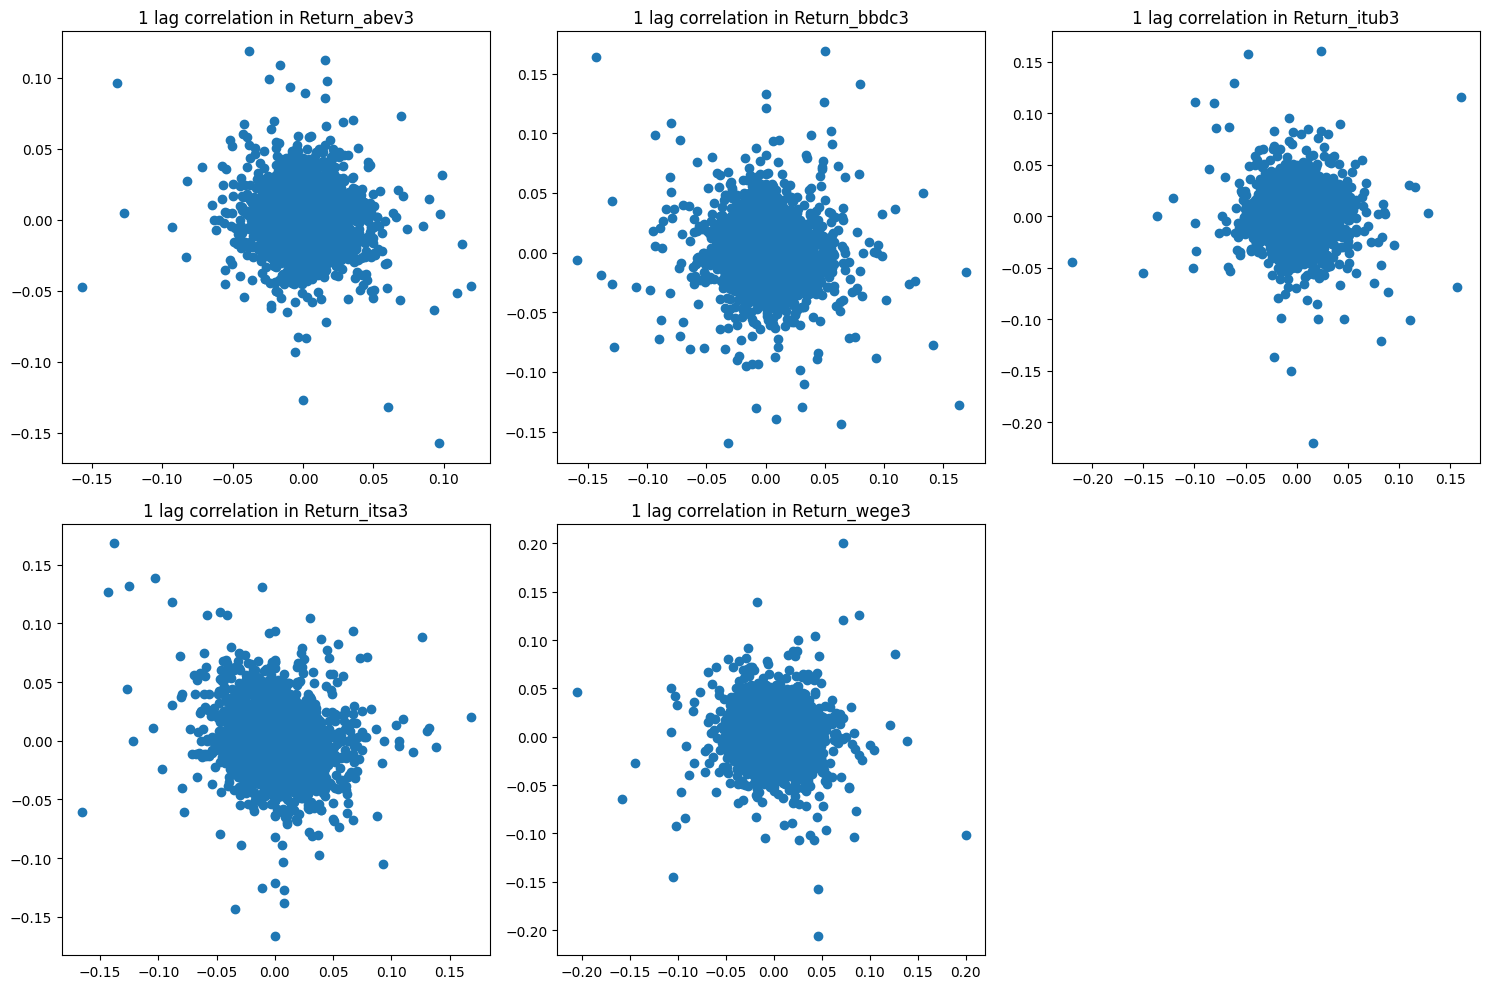

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

return_cols = [col for col in exploration_df.columns.tolist() if "Return" in col and "lag" not in col]
for i, col in enumerate(return_cols):
    new_df = pd.DataFrame()
    new_df[col] = exploration_df[col]
    new_df[f"{col}_shifted"] = exploration_df[col].shift(1)
    new_df.dropna(axis=0, inplace=True)
    print(f"corr between {col} and itself lagged: {pearsonr(new_df[col], new_df[f'{col}_shifted'])}")

    axes[i].scatter(new_df[col], new_df[f'{col}_shifted'])
    axes[i].set_title(f"1 lag correlation in {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Reforçando o argumento pró-retornos. As séries de preços tem alta correlação entre a série e a série atrasada, enquanto a série de retornos diferenciada não, mas a alta correlação é devido a tendência linear e não devido a poder preditivo real, por isso não é indicado usar a série de preços para prever movimentos. Isso não quer dizer que usar a série de retornos no lugar da série de preços garante poder preditivo real, mas evita cair no erro de ensinar o modelo a se basear no passo anterior para prever o próximo

In [48]:
stocks = ["abev3", "bbdc3", "itsa3", "itub3", "wege3"]

Observa-se que houveram mais ocorrências de retornos negativos do que positivos, mas apesar disso a média de retornos ainda é positiva, indicando que messmo na quantidade menor de retornos positivos, o valor deles superou o de retornos negativos. Além disso, as classes parecem bem balanceadas, com uma prevalência maior de ocorrências negativas

## Montando o dataframe

In [49]:
def compute_lags(df: pd.DataFrame, column_names: list[str], lags: int = 5):
    df = df.copy()
    
    for col in column_names:
        if "Return" in col:
            for i in range(lags - 1):
                df[f"{col}_lag_{i+1}"] = df[f"{col}"].shift(i+1)
    return df

In [50]:
stocks_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3
Date                                                                       
2007-10-04         2.99         6.00         7.44         3.48         2.40
2007-10-05         3.06         6.30         7.86         3.52         2.43
2007-10-08         3.06         6.31         7.95         3.43         2.45
2007-10-09         3.08         6.38         8.30         3.44         2.44
2007-10-10         3.04         6.35         8.15         3.43         2.43

In [51]:
exploration_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   

            Return_wege3  
Date                      
2007-10-11      0.004115  
2007-10-15      0.012295  
2007-10-16      0.000000  
2007-10-17      0.040486  
2007-10-18      0.007782

In [52]:
def compute_targets(df: pd.DataFrame, stock_names: list[str]):
    df = df.copy()

    for col in stock_names:
        df[f"{col}_y"] = df[f"Return_{col}"].shift(-1) > 0
    return df

In [53]:
exploration_df = compute_targets(exploration_df, stocks)
exploration_df.head(15)

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   
2007-10-19         3.00         6.09         7.52         3.43         2.57   
2007-10-22         3.00         6.13         7.57         3.50         2.54   
2007-10-23         3.00         6.19         7.70         3.38         2.58   
2007-10-24         3.00         6.23         7.59         3.46         2.65   
2007-10-25         2.95         6.09         7.44         3.45         2.66   
2007-10-26         2.97         6.30         7.71         3.45         2.70   
2007-10-29         2.99         6.29         7.87         3.40         2.74   
2007-10-30         3.03         6.21         7.76         3.43         2.75   
2007-10-31         3.08         6.36         7.87         3.43         2.84   
2007-11-01         3.09         6.03         7.61         3.44         2.87   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   
2007-10-19     -0.022801      0.000000     -0.022107     -0.014368   
2007-10-22      0.000000      0.006568      0.006649      0.020408   
2007-10-23      0.000000      0.009788      0.017173     -0.034286   
2007-10-24      0.000000      0.006462     -0.014286      0.023669   
2007-10-25     -0.016667     -0.022472     -0.019763     -0.002890   
2007-10-26      0.006780      0.034483      0.036290      0.000000   
2007-10-29      0.006734     -0.001587      0.020752     -0.014493   
2007-10-30      0.013378     -0.012719     -0.013977      0.008824   
2007-10-31      0.016502      0.024155      0.014175      0.000000   
2007-11-01      0.003247     -0.051887     -0.033037      0.002915   

            Return_wege3  abev3_y  bbdc3_y  itsa3_y  itub3_y  wege3_y  
Date                                                                   
2007-10-11      0.004115    False    False    False    False     True  
2007-10-15      0.012295    False    False     True    False    False  
2007-10-16      0.000000     True     True    False     True     True  
2007-10-17      0.040486     True    False    False    False     True  
2007-10-18      0.007782    False    False    False    False    False  
2007-10-19     -0.007722    False     True     True     True    False  
2007-10-22     -0.011673    False     True    False     True     True  
2007-10-23      0.015748    False     True     True    False     True  
2007-10-24      0.027132    False    False    False    False     True  
2007-10-25      0.003774     True     True    False     True     True  
2007-10-26      0.015038     True    False    False     True     True  
2007-10-29      0.014815     True    False     True    False     True  
2007-10-30      0.003650     True     True    False     True     True  
2007-10-31      0.032727     True    False     True    False     True  
2007-11-01      0.010563    False     True    False    False     True

In [54]:
exploration_df = compute_lags(exploration_df, exploration_df.columns.tolist())

exploration_df.head(15)

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   
2007-10-19         3.00         6.09         7.52         3.43         2.57   
2007-10-22         3.00         6.13         7.57         3.50         2.54   
2007-10-23         3.00         6.19         7.70         3.38         2.58   
2007-10-24         3.00         6.23         7.59         3.46         2.65   
2007-10-25         2.95         6.09         7.44         3.45         2.66   
2007-10-26         2.97         6.30         7.71         3.45         2.70   
2007-10-29         2.99         6.29         7.87         3.40         2.74   
2007-10-30         3.03         6.21         7.76         3.43         2.75   
2007-10-31         3.08         6.36         7.87         3.43         2.84   
2007-11-01         3.09         6.03         7.61         3.44         2.87   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   
2007-10-19     -0.022801      0.000000     -0.022107     -0.014368   
2007-10-22      0.000000      0.006568      0.006649      0.020408   
2007-10-23      0.000000      0.009788      0.017173     -0.034286   
2007-10-24      0.000000      0.006462     -0.014286      0.023669   
2007-10-25     -0.016667     -0.022472     -0.019763     -0.002890   
2007-10-26      0.006780      0.034483      0.036290      0.000000   
2007-10-29      0.006734     -0.001587      0.020752     -0.014493   
2007-10-30      0.013378     -0.012719     -0.013977      0.008824   
2007-10-31      0.016502      0.024155      0.014175      0.000000   
2007-11-01      0.003247     -0.051887     -0.033037      0.002915   

            Return_wege3  ...  Return_itub3_lag_3  Return_itub3_lag_4  \
Date                      ...                                           
2007-10-11      0.004115  ...                 NaN                 NaN   
2007-10-15      0.012295  ...                 NaN                 NaN   
2007-10-16      0.000000  ...                 NaN                 NaN   
2007-10-17      0.040486  ...           -0.034356                 NaN   
2007-10-18      0.007782  ...           -0.015248           -0.034356   
2007-10-19     -0.007722  ...           -0.018065           -0.015248   
2007-10-22     -0.011673  ...            0.032852           -0.018065   
2007-10-23      0.015748  ...           -0.021628            0.032852   
2007-10-24      0.027132  ...           -0.022107           -0.021628   
2007-10-25      0.003774  ...            0.006649           -0.022107   
2007-10-26      0.015038  ...            0.017173            0.006649   
2007-10-29      0.014815  ...           -0.014286            0.017173   
2007-10-30      0.003650  ...           -0.019763           -0.014286   
2007-10-31      0.032727  ...            0.036290           -0.019763   
2007-11-01      0.010563  ...            0.020752            0.036290   

            Return_itsa3_lag_1  Return_itsa3_lag_2  Return_itsa3_lag_3  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15   

In [55]:
exploration_df[[col for col in exploration_df.columns.tolist() if "abev3" in col]].head()

Price_abev3  Return_abev3  abev3_y  Return_abev3_lag_1  \
Date                                                                 
2007-10-11         3.08      0.013158    False                 NaN   
2007-10-15         3.02     -0.019481    False            0.013158   
2007-10-16         2.94     -0.026490     True           -0.019481   
2007-10-17         3.06      0.040816     True           -0.026490   
2007-10-18         3.07      0.003268    False            0.040816   

            Return_abev3_lag_2  Return_abev3_lag_3  Return_abev3_lag_4  
Date                                                                    
2007-10-11                 NaN                 NaN                 NaN  
2007-10-15                 NaN                 NaN                 NaN  
2007-10-16            0.013158                 NaN                 NaN  
2007-10-17           -0.019481            0.013158                 NaN  
2007-10-18           -0.026490           -0.019481            0.013158

In [56]:
exploration_df[[col for col in exploration_df.columns.tolist() if "abev3" in col or "median" in col]].head(10)

Price_abev3  Return_abev3  abev3_y  Return_abev3_lag_1  \
Date                                                                 
2007-10-11         3.08      0.013158    False                 NaN   
2007-10-15         3.02     -0.019481    False            0.013158   
2007-10-16         2.94     -0.026490     True           -0.019481   
2007-10-17         3.06      0.040816     True           -0.026490   
2007-10-18         3.07      0.003268    False            0.040816   
2007-10-19         3.00     -0.022801    False            0.003268   
2007-10-22         3.00      0.000000    False           -0.022801   
2007-10-23         3.00      0.000000    False            0.000000   
2007-10-24         3.00      0.000000    False            0.000000   
2007-10-25         2.95     -0.016667     True            0.000000   

            Return_abev3_lag_2  Return_abev3_lag_3  Return_abev3_lag_4  
Date                                                                    
2007-10-11                 NaN                 NaN                 NaN  
2007-10-15                 NaN                 NaN                 NaN  
2007-10-16            0.013158                 NaN                 NaN  
2007-10-17           -0.019481            0.013158                 NaN  
2007-10-18           -0.026490           -0.019481            0.013158  
2007-10-19            0.040816           -0.026490           -0.019481  
2007-10-22            0.003268            0.040816           -0.026490  
2007-10-23           -0.022801            0.003268            0.040816  
2007-10-24            0.000000           -0.022801            0.003268  
2007-10-25            0.000000            0.000000           -0.022801

In [57]:
exploration_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3  \
Date                                                                          
2007-10-11         3.08         6.20         7.87         3.43         2.44   
2007-10-15         3.02         6.09         7.75         3.43         2.47   
2007-10-16         2.94         5.97         7.61         3.48         2.47   
2007-10-17         3.06         6.09         7.86         3.48         2.57   
2007-10-18         3.07         6.09         7.69         3.48         2.59   

            Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2007-10-11      0.013158     -0.023622     -0.034356      0.000000   
2007-10-15     -0.019481     -0.017742     -0.015248      0.000000   
2007-10-16     -0.026490     -0.019704     -0.018065      0.014577   
2007-10-17      0.040816      0.020101      0.032852      0.000000   
2007-10-18      0.003268      0.000000     -0.021628      0.000000   

            Return_wege3  ...  Return_itub3_lag_3  Return_itub3_lag_4  \
Date                      ...                                           
2007-10-11      0.004115  ...                 NaN                 NaN   
2007-10-15      0.012295  ...                 NaN                 NaN   
2007-10-16      0.000000  ...                 NaN                 NaN   
2007-10-17      0.040486  ...           -0.034356                 NaN   
2007-10-18      0.007782  ...           -0.015248           -0.034356   

            Return_itsa3_lag_1  Return_itsa3_lag_2  Return_itsa3_lag_3  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15            0.000000                 NaN                 NaN   
2007-10-16            0.000000            0.000000                 NaN   
2007-10-17            0.014577            0.000000                 0.0   
2007-10-18            0.000000            0.014577                 0.0   

            Return_itsa3_lag_4  Return_wege3_lag_1  Return_wege3_lag_2  \
Date                                                                     
2007-10-11                 NaN                 NaN                 NaN   
2007-10-15                 NaN            0.004115                 NaN   
2007-10-16                 NaN            0.012295            0.004115   
2007-10-17                 NaN            0.000000            0.012295   
2007-10-18                 0.0            0.040486            0.000000   

            Return_wege3_lag_3  Return_wege3_lag_4  
Date                                                
2007-10-11                 NaN                 NaN  
2007-10-15                 NaN                 NaN  
2007-10-16                 NaN                 NaN  
2007-10-17            0.004115                 NaN  
2007-10-18            0.012295            0.004115  

[5 rows x 35 columns]

In [58]:
stocks_df.head()

Price_abev3  Price_bbdc3  Price_itub3  Price_itsa3  Price_wege3
Date                                                                       
2007-10-04         2.99         6.00         7.44         3.48         2.40
2007-10-05         3.06         6.30         7.86         3.52         2.43
2007-10-08         3.06         6.31         7.95         3.43         2.45
2007-10-09         3.08         6.38         8.30         3.44         2.44
2007-10-10         3.04         6.35         8.15         3.43         2.43

### Distribuição de classes

abev3_y
False    2176
True     2035
Name: count, dtype: int64
bbdc3_y
False    2132
True     2079
Name: count, dtype: int64
itsa3_y
False    2238
True     1973
Name: count, dtype: int64
itub3_y
False    2122
True     2089
Name: count, dtype: int64
wege3_y
False    2176
True     2035
Name: count, dtype: int64


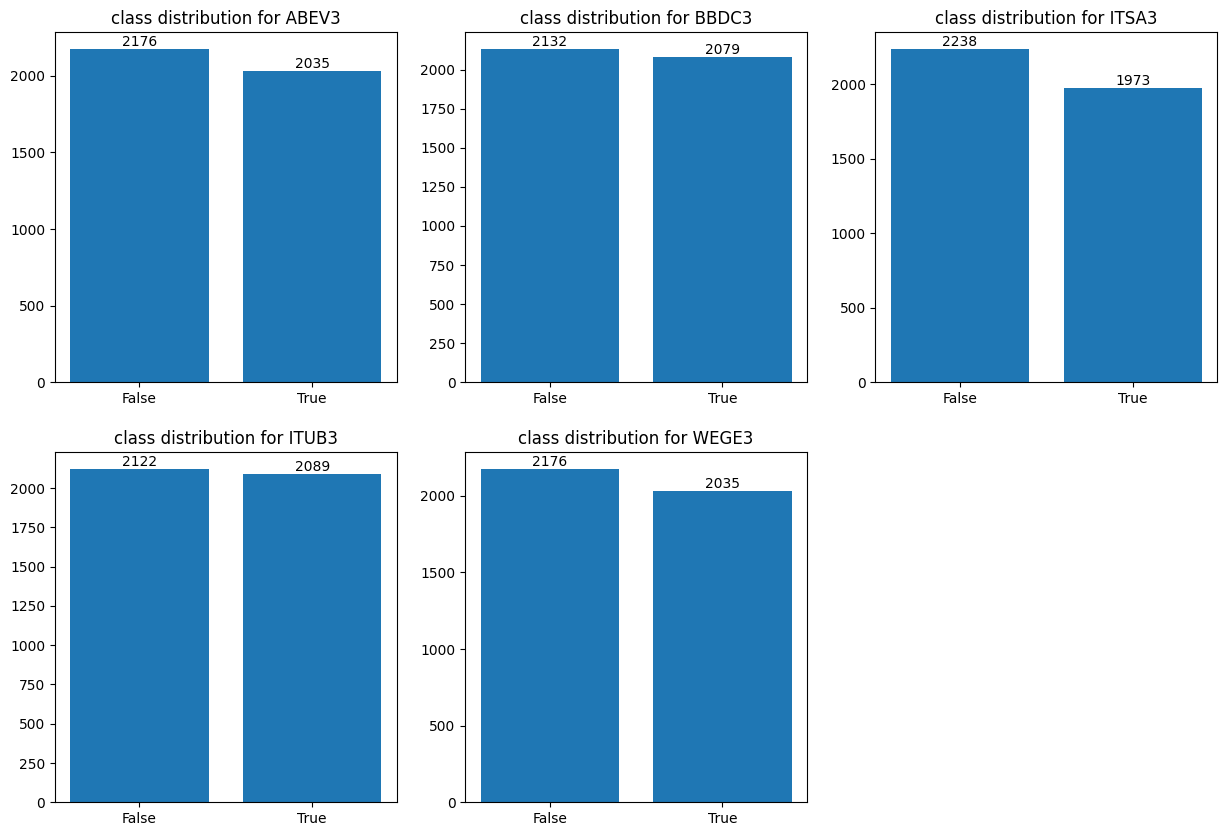

In [59]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(stocks):
    bars = axes[i].bar(["False", "True"], exploration_df[f"{col}_y"].value_counts())
    for bar in bars:
        height = bar.get_height()
        axes[i].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height}',
            ha='center', va='bottom'
        )
    print(exploration_df[f"{col}_y"].value_counts())
    axes[i].set_title(f"class distribution for {col.upper()}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

### Agregando todas as transformações necessárias em uma função

In [60]:
def preprocess_data(data: pd.DataFrame, stock_name: str) -> pd.DataFrame:
    data = data.copy()
    data = data.interpolate(method="linear")
    data = compute_returns_for_prices(data, [f"Price_{stock_name}"])
    data = compute_lags(data, [f"Return_{stock_name}"])
    data = compute_targets(data, [stock_name])
    data = data[[col for col in data.columns.tolist() if stock_name in col or "median" in col]].copy()
    data = data.drop(f"Price_{stock_name}", axis=1)
    data = data.dropna(axis=0)
    return data

preprocess_data(stocks_df.copy(), "abev3").head(10)

Return_abev3  Return_abev3_lag_1  Return_abev3_lag_2  \
Date                                                               
2007-10-11      0.013158           -0.012987            0.006536   
2007-10-15     -0.019481            0.013158           -0.012987   
2007-10-16     -0.026490           -0.019481            0.013158   
2007-10-17      0.040816           -0.026490           -0.019481   
2007-10-18      0.003268            0.040816           -0.026490   
2007-10-19     -0.022801            0.003268            0.040816   
2007-10-22      0.000000           -0.022801            0.003268   
2007-10-23      0.000000            0.000000           -0.022801   
2007-10-24      0.000000            0.000000            0.000000   
2007-10-25     -0.016667            0.000000            0.000000   

            Return_abev3_lag_3  Return_abev3_lag_4  abev3_y  
Date                                                         
2007-10-11            0.000000            0.023411    False  
2007-10-15            0.006536            0.000000    False  
2007-10-16           -0.012987            0.006536     True  
2007-10-17            0.013158           -0.012987     True  
2007-10-18           -0.019481            0.013158    False  
2007-10-19           -0.026490           -0.019481    False  
2007-10-22            0.040816           -0.026490    False  
2007-10-23            0.003268            0.040816    False  
2007-10-24           -0.022801            0.003268    False  
2007-10-25            0.000000           -0.022801     True

## Definindo o Sliding Window CV

In [61]:
class SlidingWindowExclusiveTestCV(BaseCrossValidator):
    def __init__(self, train_size: int, val_size: int):
        self.train_size = train_size
        self.val_size = val_size

    def get_n_splits(self, X=None, y=None, groups=None):
        """
        On a CV splitter (not an estimator), returns the number of elements one would get if iterating through 
        the return value of split given the same parameters. Takes the same parameters as split.
        """
        n_samples = len(X)
        count = 0
        for _ in range(0, n_samples - self.train_size - self.val_size + 1, self.val_size):
            count += 1
        return count

    def split(self, X=None, y=None, groups=None):
        """
        On a CV splitter (not an estimator), this method accepts parameters (X, y, groups), where all may be optional, 
        and returns an iterator over (train_idx, test_idx) pairs. Each of {train,test}_idx is a 1d integer array, 
        with values from 0 from X.shape[0] - 1 of any length, such that no values appear in both some train_idx and 
        its corresponding test_idx.
        """
        n_samples = len(X)
        for start in range(0, n_samples - self.train_size - self.val_size + 1, self.val_size):
            train_indices = np.arange(start, start + self.train_size)
            test_indices = np.arange(start + self.train_size, start + self.train_size + self.val_size)
            yield train_indices, test_indices

In [62]:
def check_time_index_overlap(dataframes):
    # Convert each DataFrame's index to a set for faster intersection checking
    index_sets = [set(df.index) for df in dataframes]
    
    # Check each pair of DataFrames for overlap
    for i in range(len(index_sets)):
        for j in range(i + 1, len(index_sets)):
            if index_sets[i].intersection(index_sets[j]):
                print(f"Overlap found between DataFrame {i} and DataFrame {j}")
                return True

    print("No overlap found; all time indices are mutually exclusive.")
    return False

### Visualizando o Cross Validator em ação

No overlap found; all time indices are mutually exclusive.


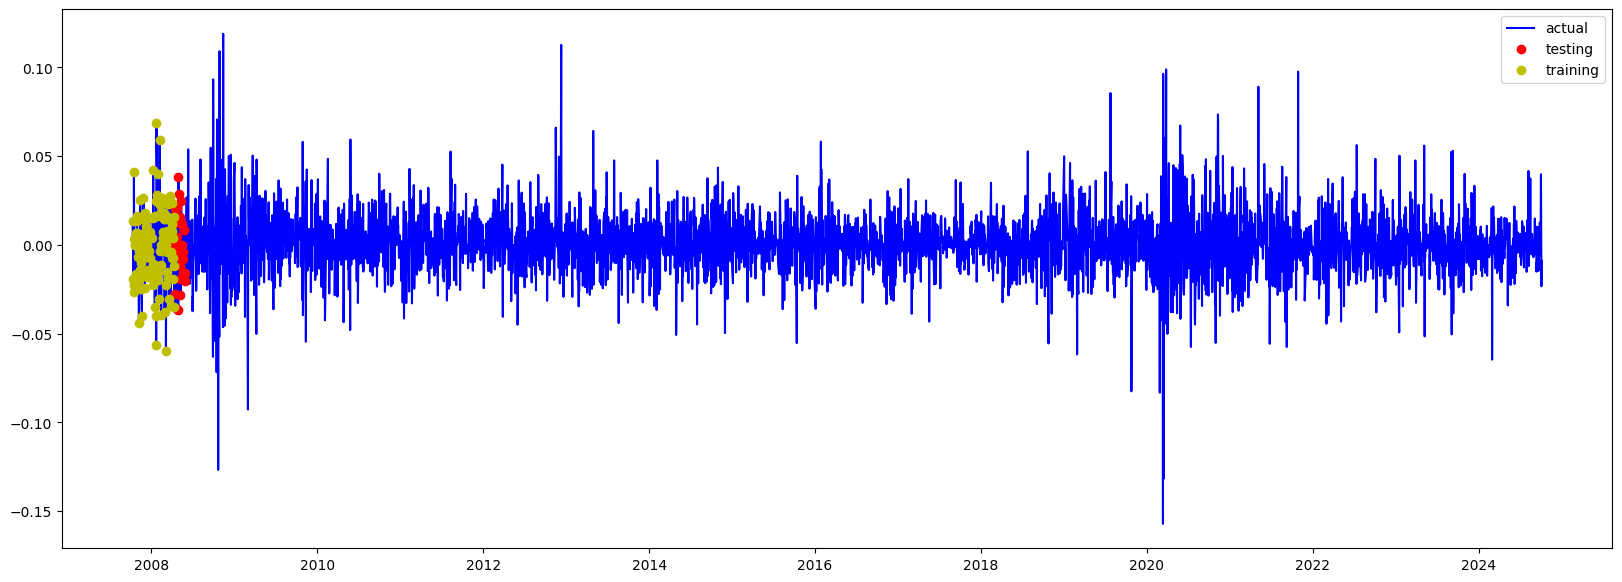

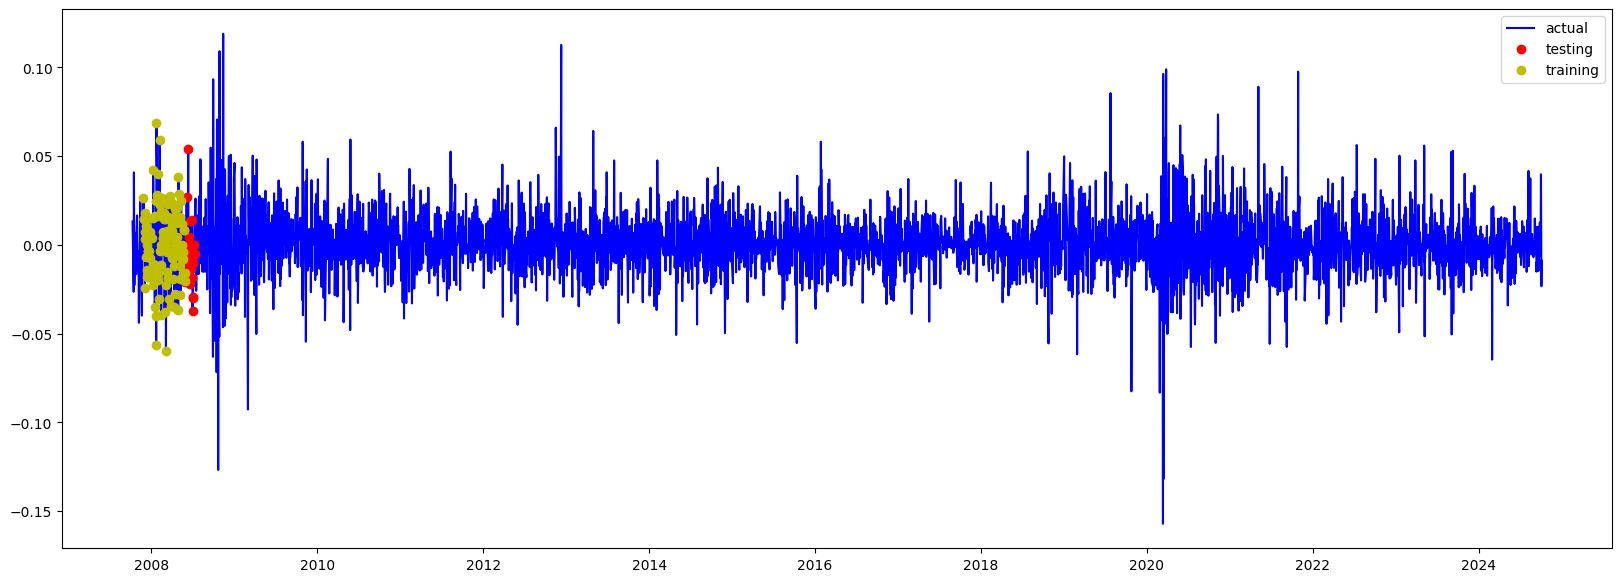

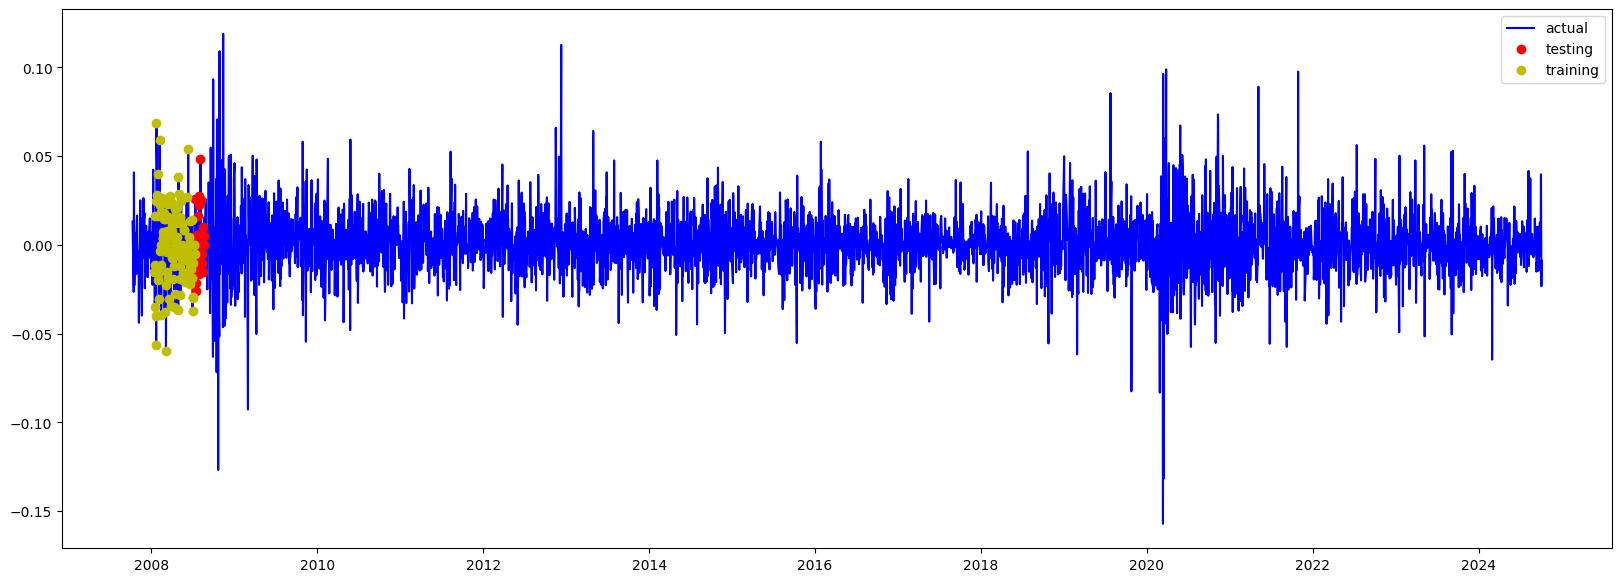

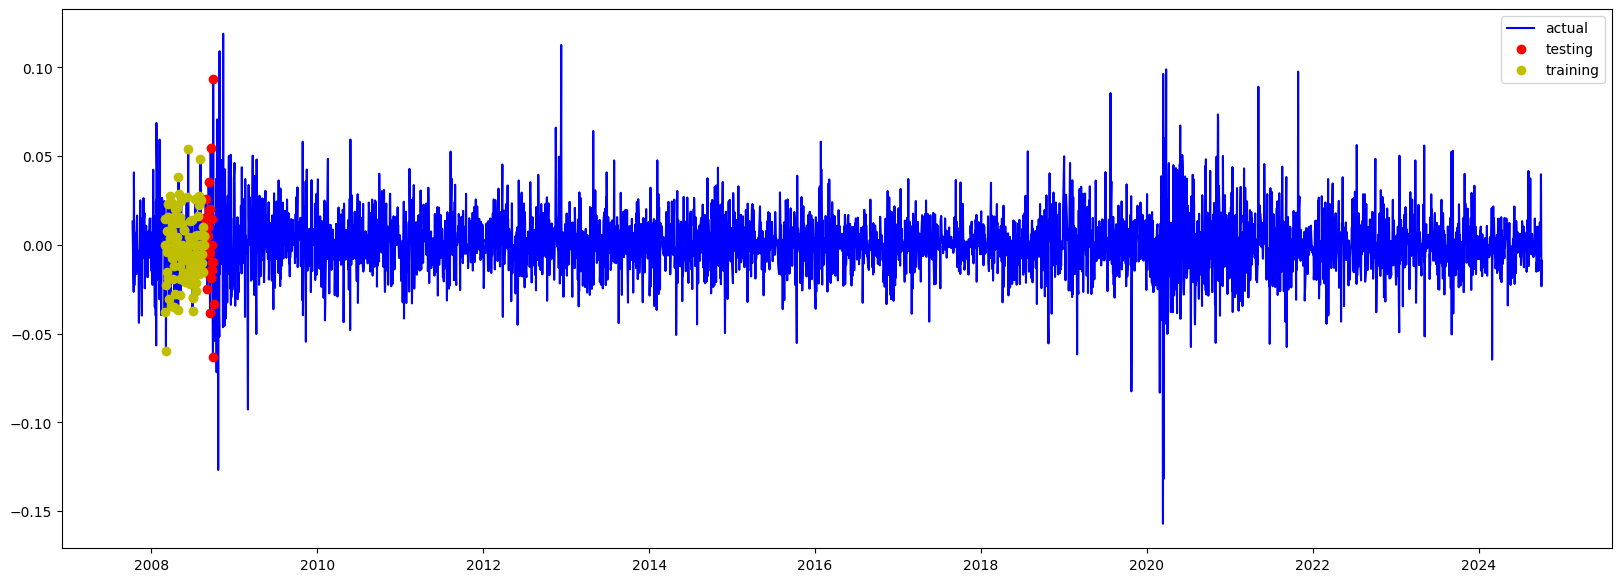

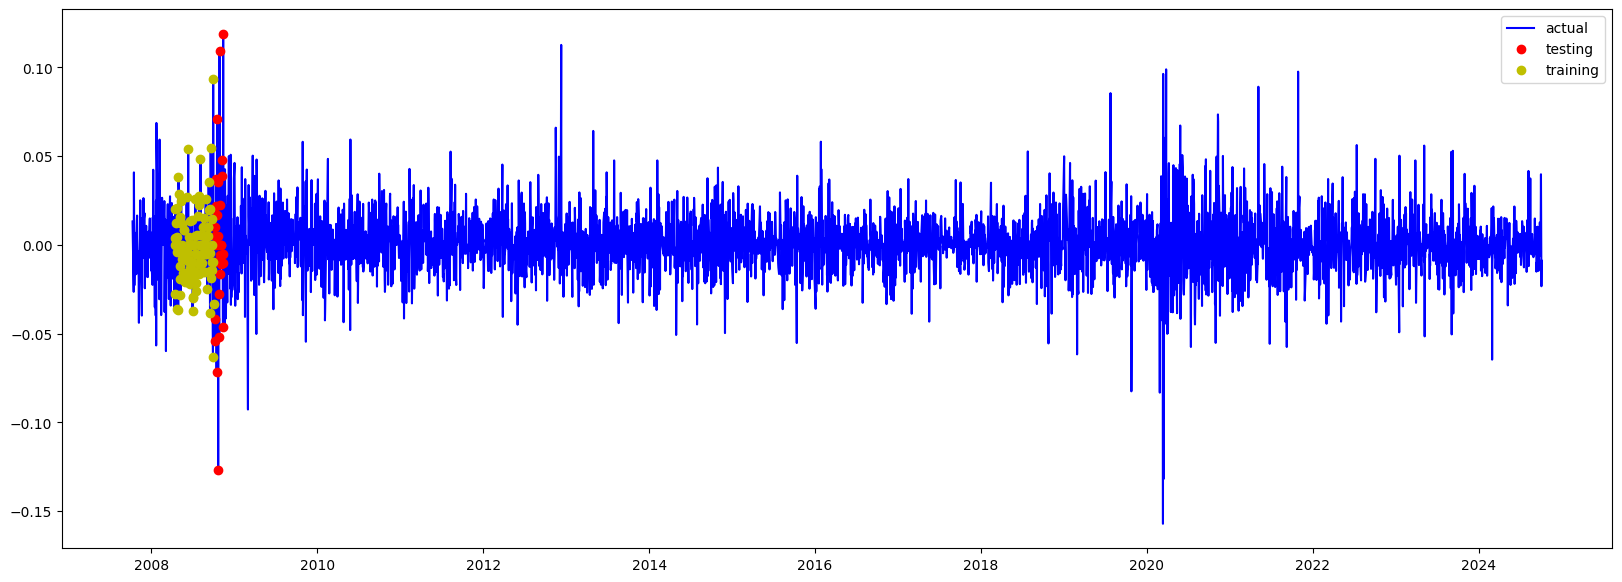

In [63]:
cv = SlidingWindowExclusiveTestCV(120, 30)

count = 0

tests = []
trains = []

df = preprocess_data(stocks_df, "abev3")

for train_index, test_index in cv.split(df["Return_abev3"]):
    X_train, X_test = df["Return_abev3"].iloc[train_index], df["Return_abev3"].iloc[test_index]
    tests.append(X_test)
    trains.append(X_train)

    if count in range(5):
        plt.figure(figsize=(20, 7))
        plt.plot(df.index, df["Return_abev3"], 'b-', label = 'actual')
        plt.plot(X_test.index, X_test, 'ro', label = 'testing')
        plt.plot(X_train.index, X_train, 'yo', label = 'training')
        plt.legend()
        plt.plot()

    count += 1

assert check_time_index_overlap(tests) == False
assert type(tests[0]) == pd.Series
assert trains[0].index[0] == df["Return_abev3"].index[0]

In [64]:
tests[0].index[-1], tests[1].index[0], tests[1].index[-1], tests[2].index[0], tests[2].index[-1], tests[3].index[0]

(Timestamp('2008-05-28 00:00:00'),
 Timestamp('2008-05-29 00:00:00'),
 Timestamp('2008-07-10 00:00:00'),
 Timestamp('2008-07-11 00:00:00'),
 Timestamp('2008-08-21 00:00:00'),
 Timestamp('2008-08-22 00:00:00'))

In [65]:
trains[1].index[-1], tests[1].index[0], trains[2].index[-1], tests[2].index[0], trains[3].index[-1], tests[3].index[0]

(Timestamp('2008-05-28 00:00:00'),
 Timestamp('2008-05-29 00:00:00'),
 Timestamp('2008-07-10 00:00:00'),
 Timestamp('2008-07-11 00:00:00'),
 Timestamp('2008-08-21 00:00:00'),
 Timestamp('2008-08-22 00:00:00'))

Treino e teste não aparentam estar vazando um no outro

# LSTM

In [66]:
TRAINING_EPOCHS = 200
PATIENCE = int(TRAINING_EPOCHS * 0.1)

BATCH_SIZE = 64
NUM_EXPERIMENTS = 60

TRAIN_SIZE = 120
VAL_SIZE = 30

In [67]:
NN_HIDDEN_UNITS = 2

In [68]:
def define_lstm(data_shape, num_units):
    lstm = Sequential()

    lstm.add(Input(shape=data_shape))
    lstm.add(LSTM(num_units, return_sequences=True))
    lstm.add(LSTM(num_units))
    lstm.add(Dense(1, activation="sigmoid"))

    lstm.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return lstm

In [69]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=PATIENCE,
    restore_best_weights=True,
	mode='max'
)

In [70]:
def run_lstm_experiment(train_size: int, val_size: int, stock: str, num_units: int, random_seed: int):
    print(stock)
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    model = define_lstm((5, 1), num_units) # 5 time steps, 1 feature (return)
    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []
    results = {}
    ground_y = []

    start_time = datetime.now()
    for train_index, test_index in cv_splitter.split(stocks_df):
        preprocessed_train_data = preprocess_data(stocks_df.iloc[train_index], stock)
        preprocessed_test_data = preprocess_data(stocks_df.iloc[test_index], stock)
        
        train_features = preprocessed_train_data.drop([f"{stock}_y"], axis=1)
        train_targets = preprocessed_train_data[f"{stock}_y"]

        test_features = preprocessed_test_data.drop([f"{stock}_y"], axis=1)
        test_targets = preprocessed_test_data[f"{stock}_y"]

        # just so I can rename variables
        X_train, X_test = train_features, test_features
        y_train, y_test = train_targets, test_targets

        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(
            X_train, y_train,
            epochs = TRAINING_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping],
            shuffle=False,
            verbose=False,
        )

        y_hat = model.predict(X_test, verbose=False)

        # turn probas into labels
        y_hat = np.array(y_hat)
        for i in range(len(y_hat)):
            if y_hat[i] > 0.5:
                y_hat[i] = True
            else:
                y_hat[i] = False

        # append preds and grounds into array
        for i, y_pred in enumerate(y_hat):
            tests.append({y_test.index[i]: y_pred.astype(int)[0]})
        
        for i, y_true in enumerate(y_hat):
            ground_y.append({y_test.index[i]: y_test.iloc[i].astype(int)})
            
    end_time = datetime.now()
    
    # extract values from result data structure
    preds_to_compute = [list(i.values())[0] for i in tests]
    grounds_to_compute = [list(i.values())[0] for i in ground_y]
    
    results = {
        "preds": preds_to_compute,
        "ground": grounds_to_compute,
        "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
        "f1": f1_score(grounds_to_compute, preds_to_compute),
        "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
        "recall": recall_score(grounds_to_compute, preds_to_compute),
        "dataset_fit_predict_time": (end_time - start_time).total_seconds()
    }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [71]:
results_lstm_1_path = "./results/lstm_01"

if not os.path.isfile(results_lstm_1_path):
    results_lstm_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"EXECUTION NUMBER {i+1}")
        abev3_lstm_res, abev3_preds = run_lstm_experiment( 
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3", 
            NN_HIDDEN_UNITS,
            i
        )

        bbdc3_lstm_res, bbdc3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            NN_HIDDEN_UNITS,
            i
        )

        itsa3_lstm_res, itsa3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            NN_HIDDEN_UNITS,
            i
        )

        itub3_lstm_res, itub3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            NN_HIDDEN_UNITS,
            i
        )

        wege3_lstm_res, wege3_preds = run_lstm_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            NN_HIDDEN_UNITS,
            i
        )

        results_lstm_1.append({
            "abev3": (abev3_lstm_res, abev3_preds),
            "bbdc3": (bbdc3_lstm_res, bbdc3_preds),
            "itsa3": (itsa3_lstm_res, itsa3_preds),
            "itub3": (itub3_lstm_res, itub3_preds),
            "wege3": (wege3_lstm_res, wege3_preds)
        })

    !mkdir "./results/"
    with open(results_lstm_1_path, "wb") as f:
        pickle.dump(results_lstm_1, f)

else:
    with open(results_lstm_1_path, "rb") as f:
        results_lstm_1 = pickle.load(f)

In [72]:
return_cols = [col for col in exploration_df.columns.tolist() if "Return" in col and "lag" not in col]
return_cols

['Return_abev3',
 'Return_bbdc3',
 'Return_itub3',
 'Return_itsa3',
 'Return_wege3']

In [73]:
start_date1 = list(results_lstm_1[0]["abev3"][1][0].keys())[0]
end_date1 = list(results_lstm_1[0]["abev3"][1][-1].keys())[0]

In [74]:
daily_returns = exploration_df[return_cols].loc[start_date1 : end_date1]
daily_returns

Return_abev3  Return_bbdc3  Return_itub3  Return_itsa3  \
Date                                                                 
2008-04-14      0.000000     -0.019455      0.013554      0.003086   
2008-04-15      0.004032      0.005952     -0.004458      0.003077   
2008-04-16      0.020080      0.037475      0.014925      0.015337   
2008-04-17     -0.027559      0.013308      0.026471      0.039275   
2008-04-18      0.012146      0.007505      0.025788     -0.029070   
...                  ...           ...           ...           ...   
2024-09-06      0.001542     -0.014604     -0.008576      0.001792   
2024-09-09      0.009238      0.002823      0.002162      0.000894   
2024-09-10      0.009916      0.002815      0.001850      0.004468   
2024-09-11     -0.015106     -0.015439     -0.002154     -0.002669   
2024-09-12     -0.009969     -0.006415     -0.003084      0.000000   

            Return_wege3  
Date                      
2008-04-14     -0.033493  
2008-04-15      0.009901  
2008-04-16      0.004902  
2008-04-17      0.000000  
2008-04-18     -0.014634  
...                  ...  
2024-09-06     -0.020586  
2024-09-09     -0.008142  
2024-09-10      0.008400  
2024-09-11      0.011549  
2024-09-12     -0.003556  

[4075 rows x 5 columns]

In [75]:
def compute_sharpe_ratio(portfolio_daily_returns):
    risk_free_daily_rate = ((1 + 0.10) ** (1 / 252)) - 1  # considering SELIC at an arbitrary avg of 10% year over 252 trading days

    avg_return = portfolio_daily_returns.mean()
    std_dev_return = portfolio_daily_returns.std(ddof=1)

    return (avg_return - risk_free_daily_rate) / std_dev_return

In [76]:
def compute_buyandhold_cumulative_returns(returns_series):
    # Define equal weights for each stock
    weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

    # Calculate daily portfolio returns
    # portfolio_returns = returns_series.dot(weights)
    portfolio_returns = (returns_series * weights).sum(axis=1)

    # Calculate cumulative returns
    cumulative_returns = (1 + portfolio_returns).cumprod()

    # Convert to DataFrame for plotting
    cumulative_returns_df = pd.DataFrame({'Cumulative Return': cumulative_returns}, index=returns_series.index)

    return cumulative_returns_df, portfolio_returns

In [77]:
import matplotlib.colors as mcolors
import colorsys

def adjust_saturation(color, saturation_factor=0.5):
    """Modify the saturation of an RGB color."""
    rgb = mcolors.to_rgb(color)  # Convert to RGB
    h, l, s = colorsys.rgb_to_hls(*rgb)  # Convert to HLS
    new_rgb = colorsys.hls_to_rgb(h, l, s * saturation_factor)  # Modify saturation
    return new_rgb

In [78]:
# Define consistent colors for each model
sat = 0.45
model_colors = {
    "LSTM": adjust_saturation("blue", sat),
    "GRU": adjust_saturation("orange", sat),
    "RNN": adjust_saturation("green", sat),
    "RF": adjust_saturation("red", sat),
    "RG": adjust_saturation("purple", sat),
    "B&H": adjust_saturation("grey", sat),
    "Ensemble": adjust_saturation("yellow", sat),
}

In [79]:
def plot_many_returns_series(series, labels, index, colors, title="Portfolio Comparison between Buy & Hold and Model"):
    if len(series) > 4:
        raise Exception("Cannot handle more than 3 series")
    
    plt.figure(figsize=(25, 10))
    for i_pos, cuml_series in enumerate(series):
        plt.plot(index, cuml_series, label = labels[i_pos], linestyle='-', color=colors[i_pos])
    plt.title(title)
    plt.legend()

    for i_pos, cuml_series in enumerate(series):
        max_idx = -1

        plt.annotate(
            f"{cuml_series.to_numpy()[max_idx]}",
            (cuml_series.index[max_idx], cuml_series.to_numpy()[max_idx]),
            xytext=(cuml_series.index[max_idx], cuml_series.to_numpy()[max_idx] + 0.5),
            arrowprops=dict(facecolor=colors[i_pos], arrowstyle='->'),
            color=colors[i_pos],
        )

    plt.plot()

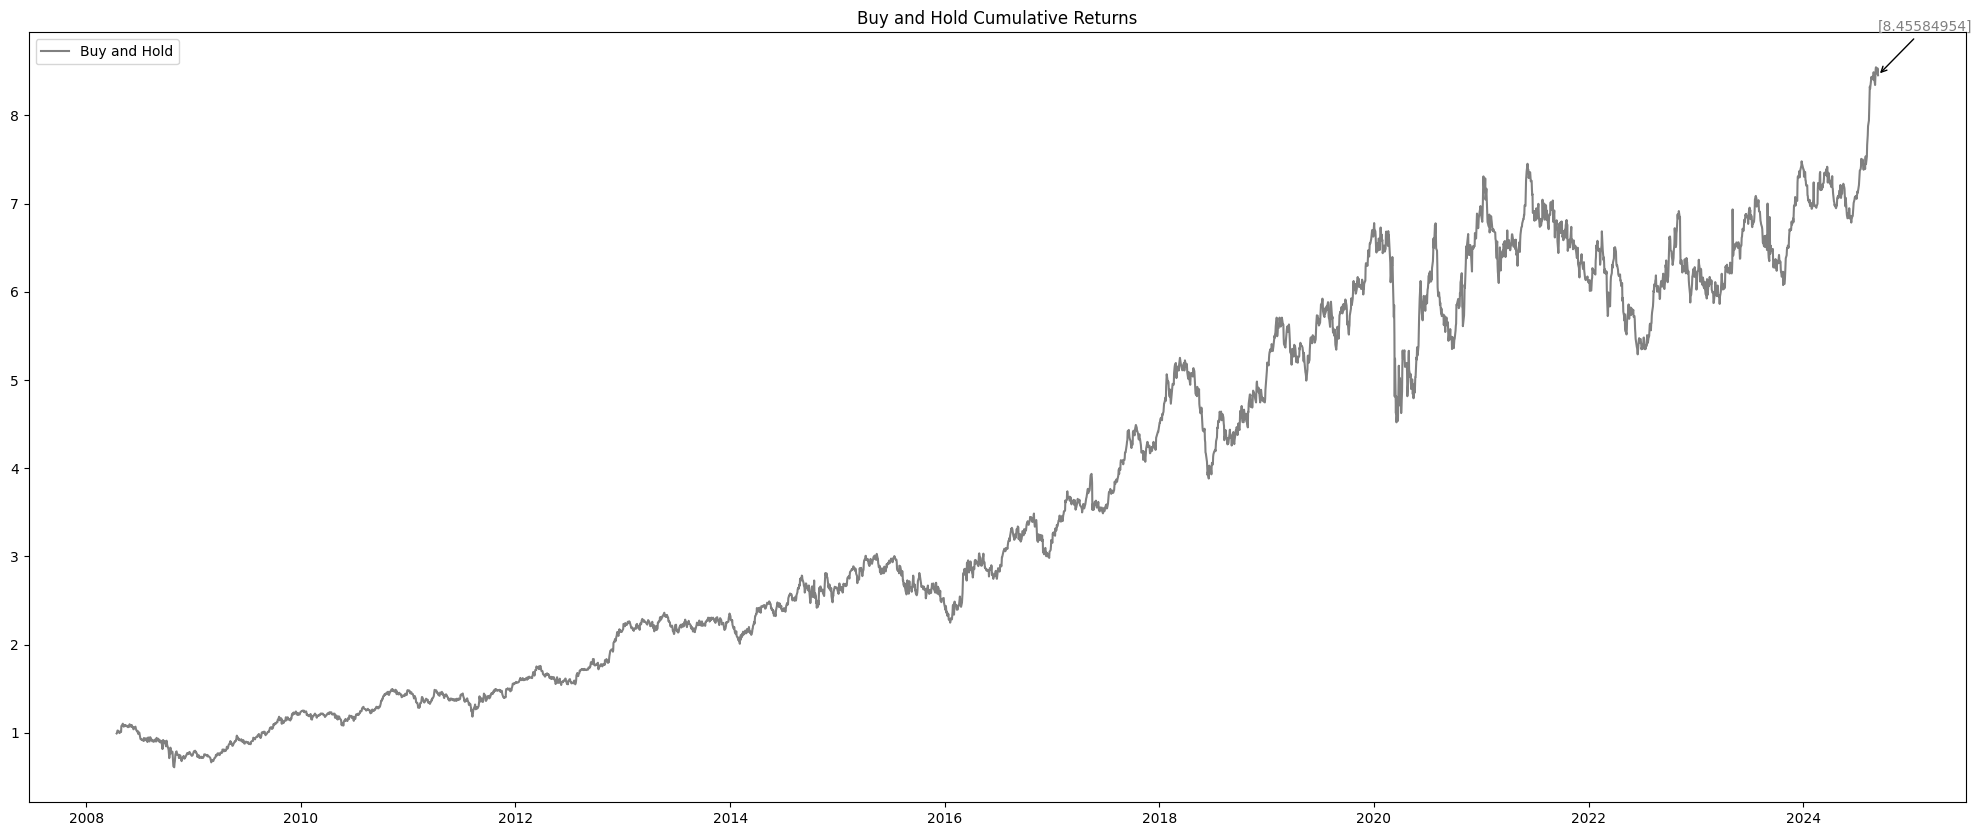

In [80]:
buy_and_hold_cuml_returns, portfolio_returns = compute_buyandhold_cumulative_returns(daily_returns)
plot_many_returns_series([buy_and_hold_cuml_returns], ["Buy and Hold"], buy_and_hold_cuml_returns.index, [model_colors["B&H"]], title="Buy and Hold Cumulative Returns")

In [81]:
buy_and_hold_sharpe = compute_sharpe_ratio(portfolio_returns)
buy_and_hold_sharpe

0.017230075011876338

In [82]:
def compute_cumulative_returns_pred(abev3_preds, bbdc3_preds, itsa3_preds, itub3_preds, wege3_preds):
    inclusion_mask = pd.DataFrame({
        'Return_abev3': pd.Series([list(val.values())[0] for val in abev3_preds], index=[list(val.keys())[0] for val in abev3_preds]),
        'Return_bbdc3': pd.Series([list(val.values())[0] for val in bbdc3_preds], index=[list(val.keys())[0] for val in bbdc3_preds]),
        'Return_itsa3': pd.Series([list(val.values())[0] for val in itsa3_preds], index=[list(val.keys())[0] for val in itsa3_preds]),
        'Return_itub3': pd.Series([list(val.values())[0] for val in itub3_preds], index=[list(val.keys())[0] for val in itub3_preds]),
        'Return_wege3': pd.Series([list(val.values())[0] for val in wege3_preds], index=[list(val.keys())[0] for val in wege3_preds]),
    })

    # Apply mask to daily returns
    adjusted_returns = daily_returns * inclusion_mask.shift(1)
    adjusted_returns = adjusted_returns.dropna(axis=0)

    weights = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
    # Adjust weights based on inclusion mask
    effective_weights = inclusion_mask * weights  # Set weight to 0 for excluded days

    # Calculate daily portfolio returns with adjusted weights
    portfolio_returns = (adjusted_returns * effective_weights).sum(axis=1)

    # Step 6: Calculate cumulative returns
    cumulative_returns_pred = (1 + portfolio_returns).cumprod()

    # Convert to DataFrame for plotting
    cumulative_returns_pred_df = pd.DataFrame({'Cumulative Return': cumulative_returns_pred}, index=daily_returns.index)

    return cumulative_returns_pred_df, portfolio_returns # daily

In [83]:
def find_best_experiment(experiments):
    max_sharpe = float("-inf")
    best_results = None
    best_cuml_performance = None
    best_idx = -1

    for i, experiment in enumerate(experiments):
        cuml_pred_df, exp_portfolio_returns = compute_cumulative_returns_pred(
            experiment["abev3"][1],
            experiment["bbdc3"][1],
            experiment["itsa3"][1],
            experiment["itub3"][1],
            experiment["wege3"][1]
        )

        sharpe = compute_sharpe_ratio(exp_portfolio_returns)
        if sharpe > max_sharpe:
            max_sharpe = sharpe
            best_results = experiment
            best_cuml_performance = cuml_pred_df
            best_idx = i

    print(f"Selected exp number {best_idx+1}")

    return best_results, best_cuml_performance, max_sharpe, best_idx

In [84]:
def get_mean_cuml_returns_across_exps(experiments):
    cuml_returns_across_exps = []

    for i, experiment in enumerate(experiments):
        cuml_pred_df, _ = compute_cumulative_returns_pred(
            experiment["abev3"][1],
            experiment["bbdc3"][1],
            experiment["itsa3"][1],
            experiment["itub3"][1],
            experiment["wege3"][1]
        )

        cuml_returns_across_exps.append(cuml_pred_df.to_numpy()[-1])
    
    return np.mean(cuml_returns_across_exps), np.std(cuml_returns_across_exps, ddof=1)

In [85]:
best_results_lstm_01, cuml_perf_lstm_01, max_sharpe_lstm_01, best_exp_idx_lstm = find_best_experiment(results_lstm_1)

Selected exp number 57


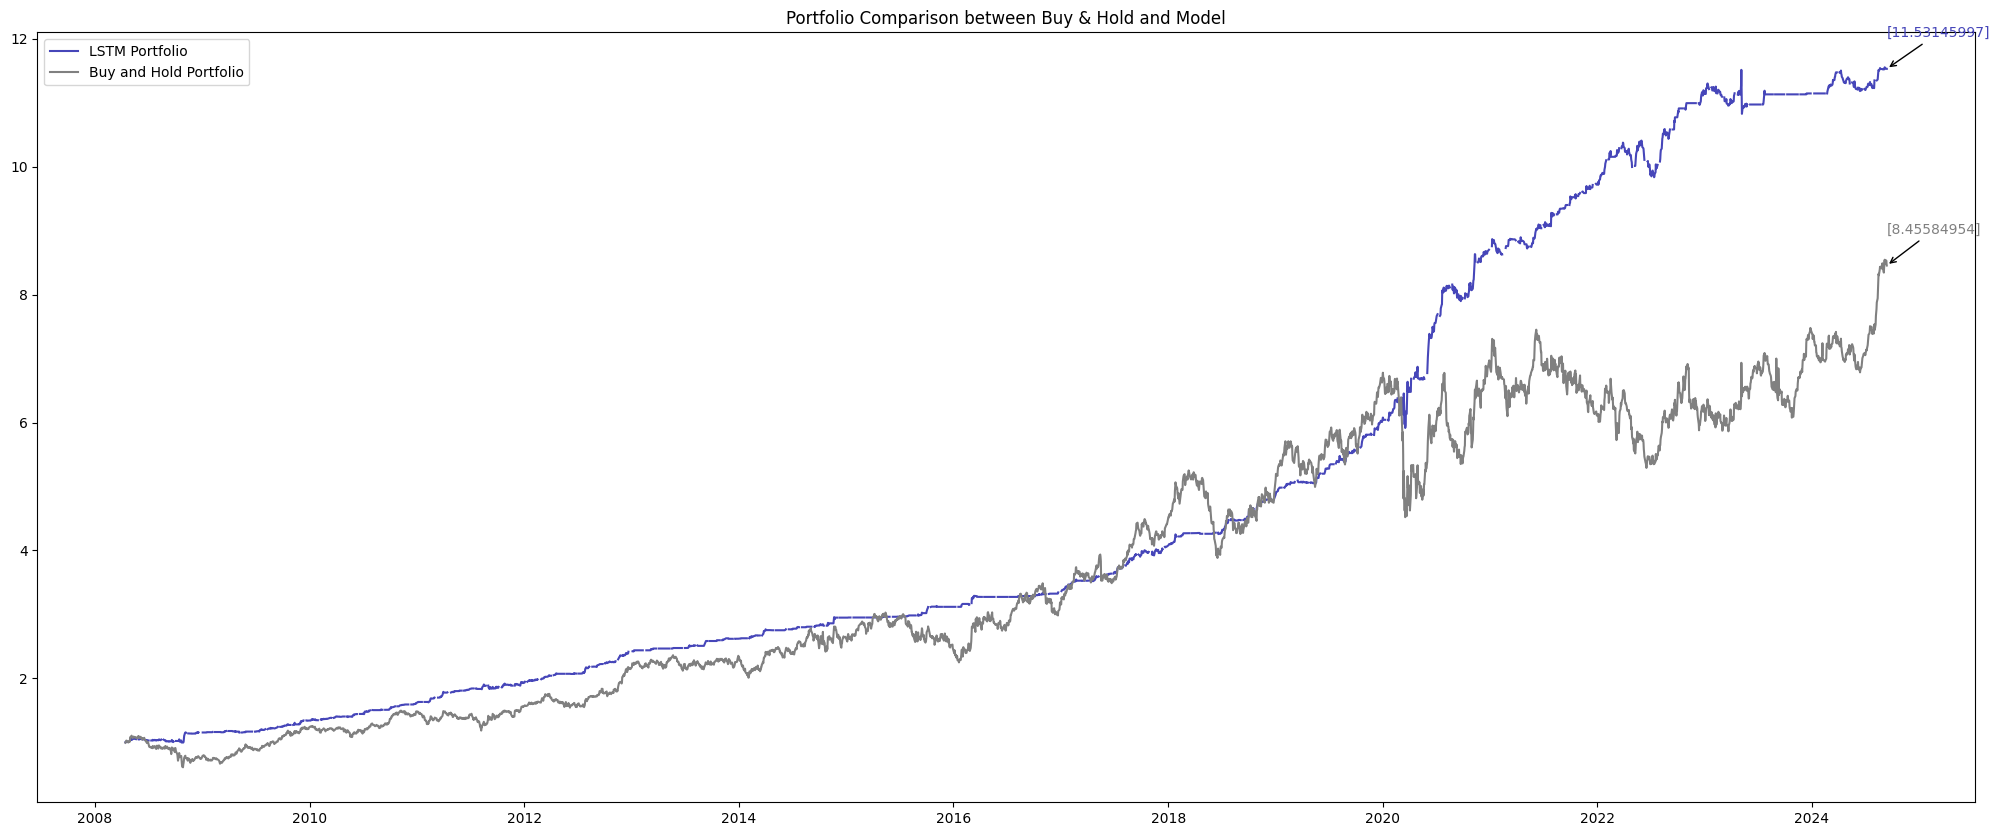

In [86]:
buy_and_hold1, _ = compute_buyandhold_cumulative_returns(exploration_df[return_cols].loc[start_date1 : end_date1])

plot_many_returns_series(
    [cuml_perf_lstm_01, buy_and_hold1],
    ["LSTM Portfolio", "Buy and Hold Portfolio"], 
    daily_returns.index,
    colors=[model_colors["LSTM"], model_colors["B&H"]]
)

In [87]:
max_sharpe_lstm_01, buy_and_hold_sharpe

(0.0755829517801281, 0.017230075011876338)

# GRU

In [88]:
def define_gru(data_shape, num_units):
    gru = Sequential()

    gru.add(Input(shape=data_shape))
    gru.add(GRU(num_units, return_sequences=True))
    gru.add(GRU(num_units))
    gru.add(Dense(1, activation="sigmoid"))

    gru.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return gru

In [89]:
def run_gru_experiment(train_size: int, val_size: int, stock: str, num_units: int, random_seed: int):
    print(stock)
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    model = define_gru((5, 1), num_units) # 5 time steps, 1 feature (return)
    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []
    results = {}
    ground_y = []

    start_time = datetime.now()
    for train_index, test_index in cv_splitter.split(stocks_df):
        preprocessed_train_data = preprocess_data(stocks_df.iloc[train_index], stock)
        preprocessed_test_data = preprocess_data(stocks_df.iloc[test_index], stock)
        
        train_features = preprocessed_train_data.drop([f"{stock}_y"], axis=1)
        train_targets = preprocessed_train_data[f"{stock}_y"]

        test_features = preprocessed_test_data.drop([f"{stock}_y"], axis=1)
        test_targets = preprocessed_test_data[f"{stock}_y"]

        # just so I can rename variables
        X_train, X_test = train_features, test_features
        y_train, y_test = train_targets, test_targets

        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(
            X_train, y_train,
            epochs = TRAINING_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping],
            shuffle=False,
            verbose=False,
        )

        y_hat = model.predict(X_test, verbose=False)

        # turn probas into labels
        y_hat = np.array(y_hat)
        for i in range(len(y_hat)):
            if y_hat[i] > 0.5:
                y_hat[i] = True
            else:
                y_hat[i] = False

        # append preds and grounds into array
        for i, y_pred in enumerate(y_hat):
            tests.append({y_test.index[i]: y_pred.astype(int)[0]})
        
        for i, y_true in enumerate(y_hat):
            ground_y.append({y_test.index[i]: y_test.iloc[i].astype(int)})
            
    end_time = datetime.now()
    
    # extract values from result data structure
    preds_to_compute = [list(i.values())[0] for i in tests]
    grounds_to_compute = [list(i.values())[0] for i in ground_y]
    
    results = {
        "preds": preds_to_compute,
        "ground": grounds_to_compute,
        "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
        "f1": f1_score(grounds_to_compute, preds_to_compute),
        "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
        "recall": recall_score(grounds_to_compute, preds_to_compute),
        "dataset_fit_predict_time": (end_time - start_time).total_seconds()
    }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [90]:
results_gru_1_path = "./results/gru_01"

if not os.path.isfile(results_gru_1_path):
    results_gru_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"Experiment {i+1}")
        abev3_gru_res, abev3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3",
            NN_HIDDEN_UNITS,
            i
        )

        bbdc3_gru_res, bbdc3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            NN_HIDDEN_UNITS,
            i
        )

        itsa3_gru_res, itsa3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            NN_HIDDEN_UNITS,
            i
        )

        itub3_gru_res, itub3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            NN_HIDDEN_UNITS,
            i
        )

        wege3_gru_res, wege3_gru_preds = run_gru_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            NN_HIDDEN_UNITS,
            i
        )

        results_gru_1.append({
            "abev3": (abev3_gru_res, abev3_gru_preds),
            "bbdc3": (bbdc3_gru_res, bbdc3_gru_preds),
            "itsa3": (itsa3_gru_res, itsa3_gru_preds),
            "itub3": (itub3_gru_res, itub3_gru_preds),
            "wege3": (wege3_gru_res, wege3_gru_preds)
        })

    !mkdir "./results/"
    with open(results_gru_1_path, "wb") as f:
        pickle.dump(results_gru_1, f)

else:
    with open(results_gru_1_path, "rb") as f:
        results_gru_1 = pickle.load(f)

In [91]:
best_results_gru_1, cuml_perf_gru_1, max_sharpe_gru_1, best_exp_idx_gru = find_best_experiment(results_gru_1)
# plot_cumulative_returns_line_chart(cuml_perf_gru_1)

Selected exp number 57


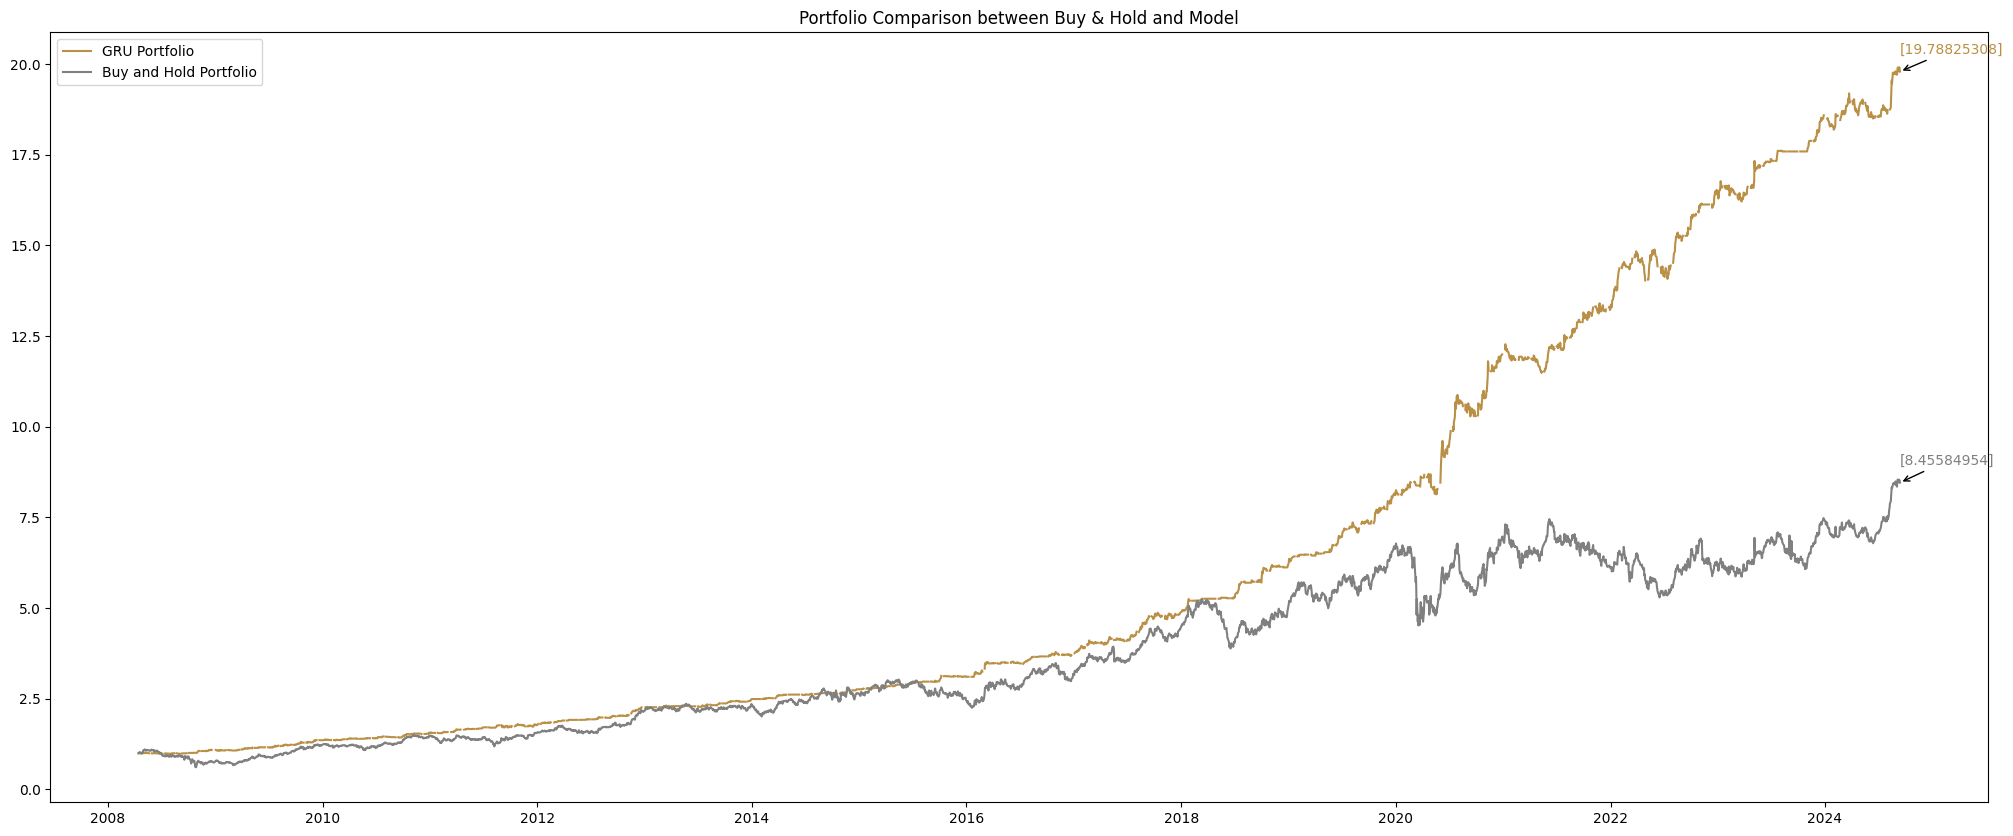

In [92]:
plot_many_returns_series(
    [cuml_perf_gru_1, buy_and_hold1],
    ["GRU Portfolio", "Buy and Hold Portfolio"], 
    daily_returns.index,
    colors=[model_colors["GRU"], model_colors["B&H"]]
)

In [93]:
max_sharpe_gru_1, buy_and_hold_sharpe

(0.09447207563381496, 0.017230075011876338)

# RNN Simples

In [94]:
def define_rnn(data_shape, num_units):
    rnn = Sequential()

    rnn.add(Input(shape=data_shape))
    rnn.add(SimpleRNN(num_units, return_sequences=True))
    rnn.add(SimpleRNN(num_units))
    rnn.add(Dense(1, activation="sigmoid"))

    rnn.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

    return rnn

In [95]:
def run_rnn_experiment(train_size: int, val_size: int, stock: str, num_units: int, random_seed: int):
    print(stock)
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    model = define_rnn((5, 1), num_units) # 5 time steps, 1 feature (return)
    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []
    results = {}
    ground_y = []

    start_time = datetime.now()
    for train_index, test_index in cv_splitter.split(stocks_df):
        preprocessed_train_data = preprocess_data(stocks_df.iloc[train_index], stock)
        preprocessed_test_data = preprocess_data(stocks_df.iloc[test_index], stock)
        
        train_features = preprocessed_train_data.drop([f"{stock}_y"], axis=1)
        train_targets = preprocessed_train_data[f"{stock}_y"]

        test_features = preprocessed_test_data.drop([f"{stock}_y"], axis=1)
        test_targets = preprocessed_test_data[f"{stock}_y"]

        # just so I can rename variables
        X_train, X_test = train_features, test_features
        y_train, y_test = train_targets, test_targets

        scaler = MinMaxScaler(feature_range=(-1, 1))
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        model.fit(
            X_train, y_train,
            epochs = TRAINING_EPOCHS,
            batch_size=BATCH_SIZE,
            validation_split=0.2,
            callbacks=[early_stopping],
            shuffle=False,
            verbose=False,
        )

        y_hat = model.predict(X_test, verbose=False)

        # turn probas into labels
        y_hat = np.array(y_hat)
        for i in range(len(y_hat)):
            if y_hat[i] > 0.5:
                y_hat[i] = True
            else:
                y_hat[i] = False

        # append preds and grounds into array
        for i, y_pred in enumerate(y_hat):
            tests.append({y_test.index[i]: y_pred.astype(int)[0]})
        
        for i, y_true in enumerate(y_hat):
            ground_y.append({y_test.index[i]: y_test.iloc[i].astype(int)})
            
    end_time = datetime.now()
    
    # extract values from result data structure
    preds_to_compute = [list(i.values())[0] for i in tests]
    grounds_to_compute = [list(i.values())[0] for i in ground_y]
    
    results = {
        "preds": preds_to_compute,
        "ground": grounds_to_compute,
        "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
        "f1": f1_score(grounds_to_compute, preds_to_compute),
        "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
        "recall": recall_score(grounds_to_compute, preds_to_compute),
        "dataset_fit_predict_time": (end_time - start_time).total_seconds()
    }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [96]:
results_rnn_1_path = "./results/rnn_01"

if not os.path.isfile(results_rnn_1_path):
    results_rnn_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"EXECUTION NUMBER {i+1}")
        abev3_rnn_res, abev3_preds_rnn = run_rnn_experiment( 
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3", 
            NN_HIDDEN_UNITS,
            i
        )

        bbdc3_rnn_res, bbdc3_preds_rnn = run_rnn_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            NN_HIDDEN_UNITS,
            i
        )

        itsa3_rnn_res, itsa3_preds_rnn = run_rnn_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            NN_HIDDEN_UNITS,
            i
        )

        itub3_rnn_res, itub3_preds_rnn = run_rnn_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            NN_HIDDEN_UNITS,
            i
        )

        wege3_rnn_res, wege3_preds_rnn = run_rnn_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            NN_HIDDEN_UNITS,
            i
        )

        results_rnn_1.append({
            "abev3": (abev3_rnn_res, abev3_preds_rnn),
            "bbdc3": (bbdc3_rnn_res, bbdc3_preds_rnn),
            "itsa3": (itsa3_rnn_res, itsa3_preds_rnn),
            "itub3": (itub3_rnn_res, itub3_preds_rnn),
            "wege3": (wege3_rnn_res, wege3_preds_rnn)
        })

    !mkdir "./results/"
    with open(results_rnn_1_path, "wb") as f:
        pickle.dump(results_rnn_1, f)

else:
    with open(results_rnn_1_path, "rb") as f:
        results_rnn_1 = pickle.load(f)

Selected exp number 55


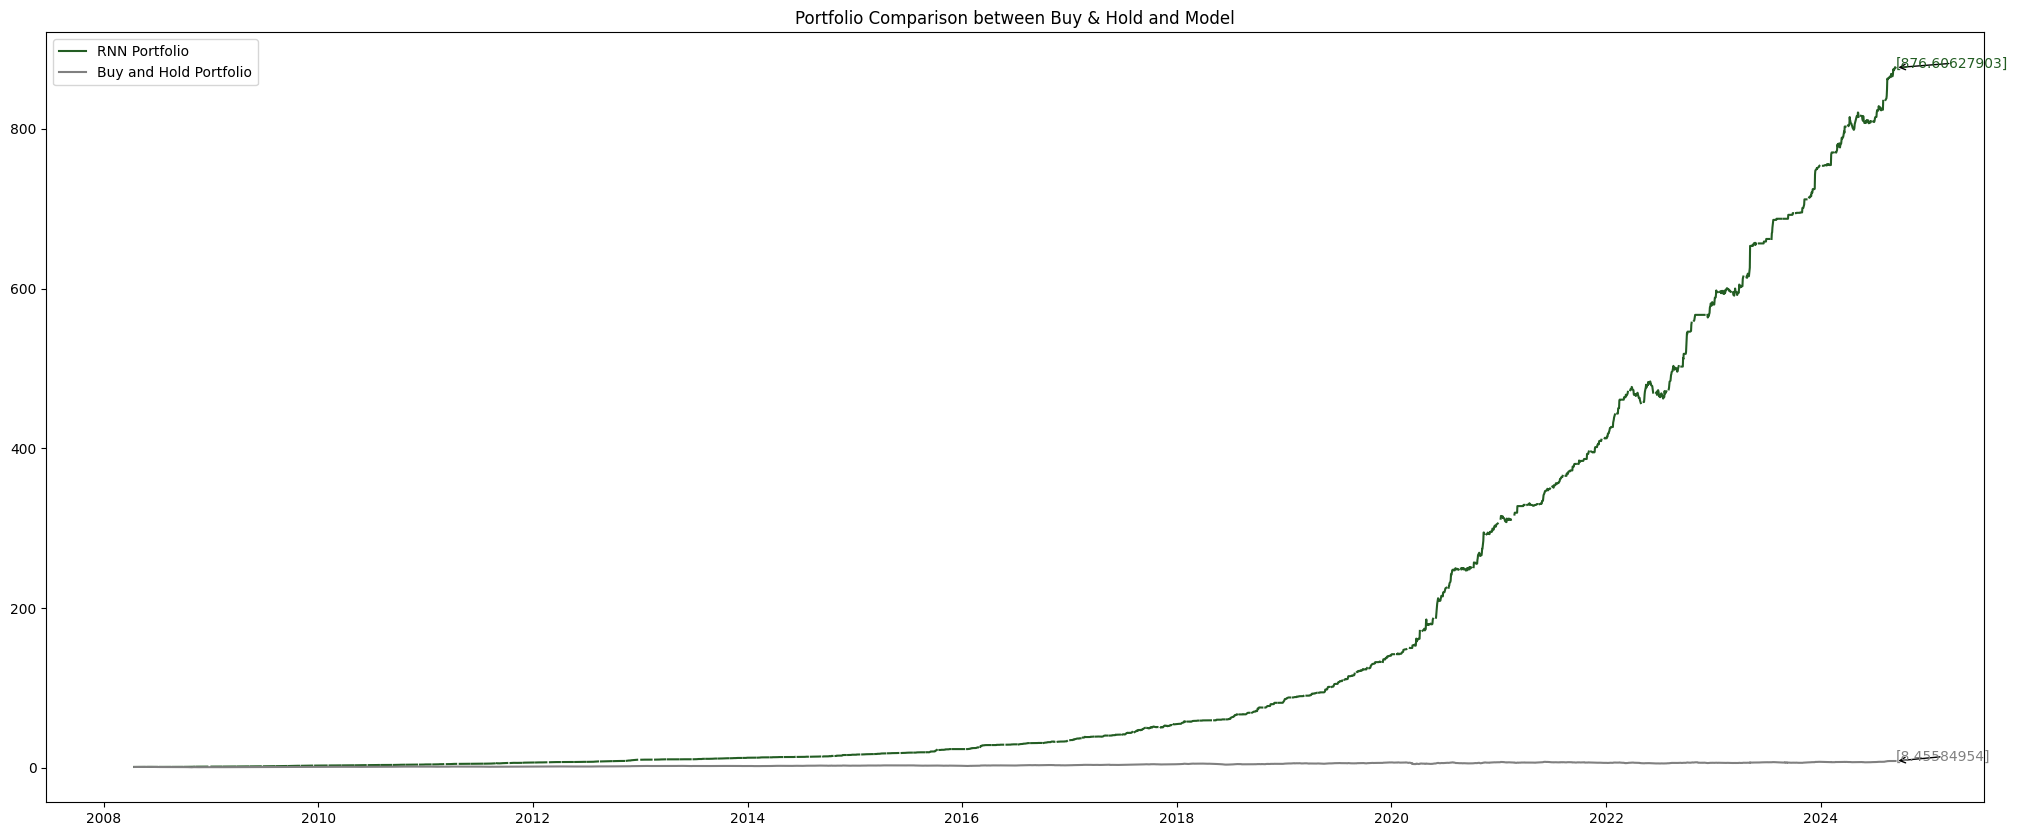

In [97]:
best_results_rnn_1, cuml_perf_rnn_1, max_sharpe_rnn_1, best_exp_idx_rnn = find_best_experiment(results_rnn_1)

plot_many_returns_series(
    [cuml_perf_rnn_1, buy_and_hold1],
    ["RNN Portfolio", "Buy and Hold Portfolio"], 
    daily_returns.index,
    colors=[model_colors["RNN"], model_colors["B&H"]]
)

# Random Forest

In [98]:
def define_rf(random_seed: int):
    rf = RandomForestClassifier(verbose=False, random_state=random_seed, n_jobs=-1)

    return rf

In [99]:
def run_rf_experiment(train_size: int, val_size: int, stock: str, random_seed: int):
    print(stock)
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    model = define_rf(random_seed)
    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []
    results = {}
    ground_y = []

    start_time = datetime.now()
    for train_index, test_index in cv_splitter.split(stocks_df):
        preprocessed_train_data = preprocess_data(stocks_df.iloc[train_index], stock)
        preprocessed_test_data = preprocess_data(stocks_df.iloc[test_index], stock)
        
        train_features = preprocessed_train_data.drop([f"{stock}_y"], axis=1)
        train_targets = preprocessed_train_data[f"{stock}_y"]

        test_features = preprocessed_test_data.drop([f"{stock}_y"], axis=1)
        test_targets = preprocessed_test_data[f"{stock}_y"]

        # just so I can rename variables
        X_train, X_test = train_features, test_features
        y_train, y_test = train_targets, test_targets

        model.fit(
            X_train, y_train
        )
        y_hat = model.predict(X_test)

        y_hat = np.array(y_hat)

        # append preds and grounds into array
        for i, y_pred in enumerate(y_hat):
            tests.append({y_test.index[i]: y_pred.astype(int)})
        
        for i, y_true in enumerate(y_hat):
            ground_y.append({y_test.index[i]: y_test.iloc[i].astype(int)})
            
    end_time = datetime.now()
    
    # extract values from result data structure
    preds_to_compute = [list(i.values())[0] for i in tests]
    grounds_to_compute = [list(i.values())[0] for i in ground_y]
    
    results = {
        "preds": preds_to_compute,
        "ground": grounds_to_compute,
        "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
        "f1": f1_score(grounds_to_compute, preds_to_compute),
        "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
        "recall": recall_score(grounds_to_compute, preds_to_compute),
        "dataset_fit_predict_time": (end_time - start_time).total_seconds()
    }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [100]:
results_rf_1_path = "./results/rf_01"

if not os.path.isfile(results_rf_1_path):
    results_rf_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"EXECUTION NUMBER {i+1}")
        abev3_rf_res, abev3_preds_rf = run_rf_experiment( 
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3", 
            i
        )

        bbdc3_rf_res, bbdc3_preds_rf = run_rf_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            i
        )

        itsa3_rf_res, itsa3_preds_rf = run_rf_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            i
        )

        itub3_rf_res, itub3_preds_rf = run_rf_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            i
        )

        wege3_rf_res, wege3_preds_rf = run_rf_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            i
        )

        results_rf_1.append({
            "abev3": (abev3_rf_res, abev3_preds_rf),
            "bbdc3": (bbdc3_rf_res, bbdc3_preds_rf),
            "itsa3": (itsa3_rf_res, itsa3_preds_rf),
            "itub3": (itub3_rf_res, itub3_preds_rf),
            "wege3": (wege3_rf_res, wege3_preds_rf)
        })

    !mkdir "./results/"
    with open(results_rf_1_path, "wb") as f:
        pickle.dump(results_rf_1, f)

else:
    with open(results_rf_1_path, "rb") as f:
        results_rf_1 = pickle.load(f)

Selected exp number 11


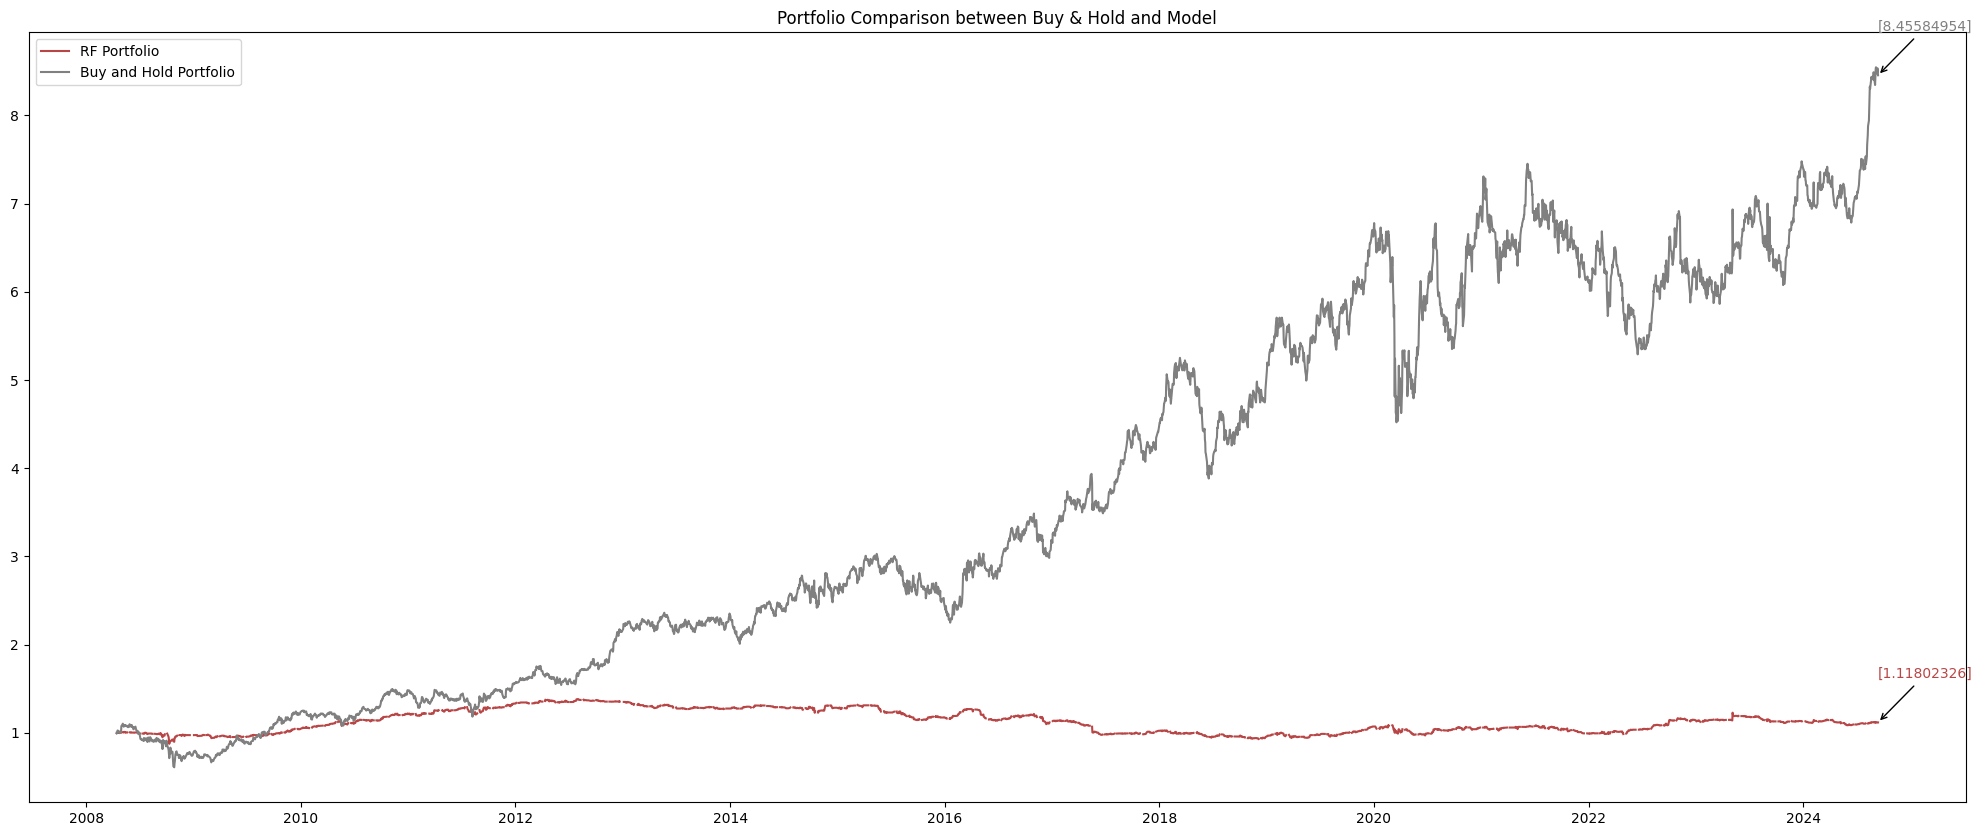

In [101]:
best_results_rf_1, cuml_perf_rf_1, max_sharpe_rf_1, best_exp_idx_rf = find_best_experiment(results_rf_1)

plot_many_returns_series(
    [cuml_perf_rf_1, buy_and_hold1],
    ["RF Portfolio", "Buy and Hold Portfolio"], 
    daily_returns.index,
    colors=[model_colors["RF"], model_colors["B&H"]]
)

# Random Guessing

In [102]:
def run_random_guessing_experiment(train_size: int, val_size: int, stock: str, random_seed: int):
    print(stock)
    np.random.seed(random_seed)
    random.seed(random_seed)
    tf.random.set_seed(random_seed)

    data = preprocess_data(stocks_df, stock)

    X = data.drop([f"{stock}_y"], axis=1)
    y_ground = data[f"{stock}_y"]

    cv_splitter = SlidingWindowExclusiveTestCV(train_size, val_size)

    tests = []
    results = {}
    ground_y = []

    for train_index, test_index in cv_splitter.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_ground.iloc[train_index], y_ground.iloc[test_index]

        y_hat = np.random.choice([True, False], size=len(X_test))

        y_hat = np.array(y_hat)

        # append preds and grounds into array
        for i, y_pred in enumerate(y_hat):
            tests.append({y_test.index[i]: y_pred.astype(int)})
        
        for i, y_true in enumerate(y_hat):
            ground_y.append({y_test.index[i]: y_test.iloc[i].astype(int)})
            
    # extract values from result data structure

    preds_to_compute = [list(i.values())[0] for i in tests]
    grounds_to_compute = [list(i.values())[0] for i in ground_y]

    results = {
        "preds": preds_to_compute,
        "ground": grounds_to_compute,
        "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
        "f1": f1_score(grounds_to_compute, preds_to_compute),
        "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
        "recall": recall_score(grounds_to_compute, preds_to_compute),
    }

    # all_accs.append(np.array(accs).mean())
    np.random.seed(RANDOM_STATE)
    random.seed(RANDOM_STATE)
    tf.random.set_seed(RANDOM_STATE)

    return results, tests

In [103]:
results_rg_1_path = "./results/rg_01"

if not os.path.isfile(results_rg_1_path):
    results_rg_1 = []

    for i in range(NUM_EXPERIMENTS):
        print(f"EXECUTION NUMBER {i+1}")
        abev3_rg_res, abev3_preds_rg = run_random_guessing_experiment( 
            TRAIN_SIZE, 
            VAL_SIZE, 
            "abev3", 
            i
        )

        bbdc3_rg_res, bbdc3_preds_rg = run_random_guessing_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "bbdc3", 
            i
        )

        itsa3_rg_res, itsa3_preds_rg = run_random_guessing_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itsa3", 
            i
        )

        itub3_rg_res, itub3_preds_rg = run_random_guessing_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "itub3", 
            i
        )

        wege3_rg_res, wege3_preds_rg = run_random_guessing_experiment(
            TRAIN_SIZE, 
            VAL_SIZE, 
            "wege3", 
            i
        )

        results_rg_1.append({
            "abev3": (abev3_rg_res, abev3_preds_rg),
            "bbdc3": (bbdc3_rg_res, bbdc3_preds_rg),
            "itsa3": (itsa3_rg_res, itsa3_preds_rg),
            "itub3": (itub3_rg_res, itub3_preds_rg),
            "wege3": (wege3_rg_res, wege3_preds_rg)
        })

    !mkdir "./results/"
    with open(results_rg_1_path, "wb") as f:
        pickle.dump(results_rg_1, f)

else:
    with open(results_rg_1_path, "rb") as f:
        results_rg_1 = pickle.load(f)

Selected exp number 28


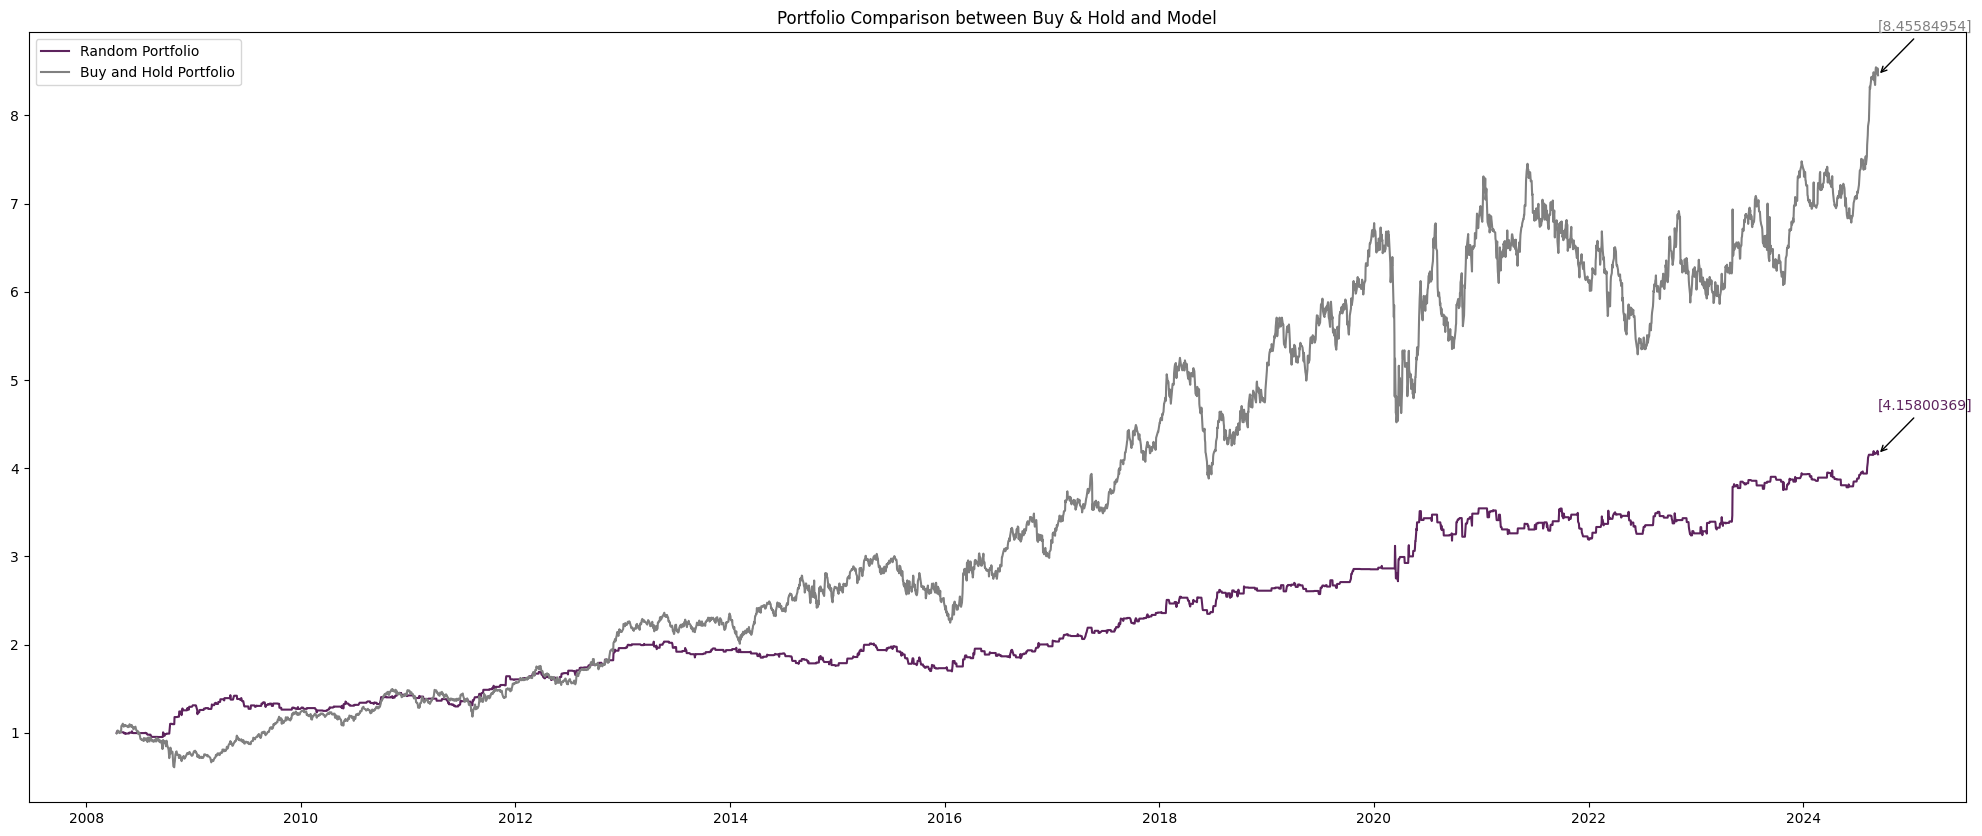

In [104]:
best_results_rg_1, cuml_perf_rg_1, max_sharpe_rg_1, best_exp_idx_rg = find_best_experiment(results_rg_1)

plot_many_returns_series(
    [cuml_perf_rg_1, buy_and_hold1],
    ["Random Portfolio", "Buy and Hold Portfolio"], 
    daily_returns.index,
    colors=[model_colors["RG"], model_colors["B&H"]]
)

# Análise dos Resultados

In [105]:
def get_sharpe_series_from_results(experiments):
    sharpes = []

    for experiment in experiments:
        _, exp_portfolio_returns = compute_cumulative_returns_pred(
            experiment["abev3"][1],
            experiment["bbdc3"][1],
            experiment["itsa3"][1],
            experiment["itub3"][1],
            experiment["wege3"][1]
        )

        sharpe = compute_sharpe_ratio(exp_portfolio_returns)
        sharpes.append(sharpe)
        
    
    return sharpes

In [106]:
lstm_sharpes_1 = get_sharpe_series_from_results(results_lstm_1)
gru_sharpes_1 = get_sharpe_series_from_results(results_gru_1)
rf_sharpes_1 = get_sharpe_series_from_results(results_rf_1)
rnn_sharpes_1 = get_sharpe_series_from_results(results_rnn_1)
rg_sharpes_1 = get_sharpe_series_from_results(results_rg_1)

In [107]:
def plot_distribution_and_stddev_o(all_data, metric, models = ["LSTM", "GRU", "RNN", "RF", "RG"]):

    fig, axes = plt.subplots(1, 2, figsize=(25, 10))

    labels = [f"{models[i]}" for i in range(len(all_data))]

    axes[0].boxplot(
        all_data, 
        labels=labels
    )
    axes[0].set_title(f'Boxplot of {metric}')

    bars = axes[1].bar(
        labels,
        [
            np.array(model).std() for model in all_data
        ], 
        color='skyblue'
    )
    for bar in bars:
        height = bar.get_height()
        axes[1].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.4f}',
            ha='center', va='bottom'
        )
    axes[1].set_title(f'Standard Deviations of {metric}')

    plt.tight_layout()
    plt.show()

In [108]:
def plot_distribution_and_stddev(all_data, metric, models=["LSTM", "GRU", "RNN", "RF", "RG"]):
    fig, axes = plt.subplots(1, 2, figsize=(25, 10))

    labels = [models[i] for i in range(len(all_data))]

    # --- Boxplot ---
    box = axes[0].boxplot(
        all_data, 
        labels=labels,
        patch_artist=True  # Enable box fill colors
    )

    # Apply colors to boxplot
    for patch, model in zip(box['boxes'], labels):
        patch.set_facecolor(model_colors.get(model, "black"))  # Use black if model is not in dictionary

    axes[0].set_title(f'Boxplot of {metric}')

    # --- Bar Chart ---
    std_devs = [np.array(model).std() for model in all_data]
    bars = axes[1].bar(
        labels,
        std_devs, 
        color=[model_colors.get(model, "black") for model in labels]
    )

    for bar in bars:
        height = bar.get_height()
        axes[1].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.4f}',
            ha='center', va='bottom'
        )

    axes[1].set_title(f'Standard Deviations of {metric}')

    plt.tight_layout()
    plt.show()

In [109]:
def print_statistics_table_for_series(all_data, models = ["LSTM", "GRU", "RNN", "RF", "RG"]):
    table = PrettyTable(["model", "mean", "median", "max", "min", "stddev", "full range"])

    for series, model in zip(all_data, models):
        table.add_row([
            model,
            np.array(series).mean(),
            np.median(np.array(series)),
            np.array(series).max(),
            np.array(series).min(),
            np.array(series).std(),
            np.array(series).max() - np.array(series).min()
        ])
    
    print(table)

### Distribuição de Sharpe Ratios

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_26105/2299270969.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(


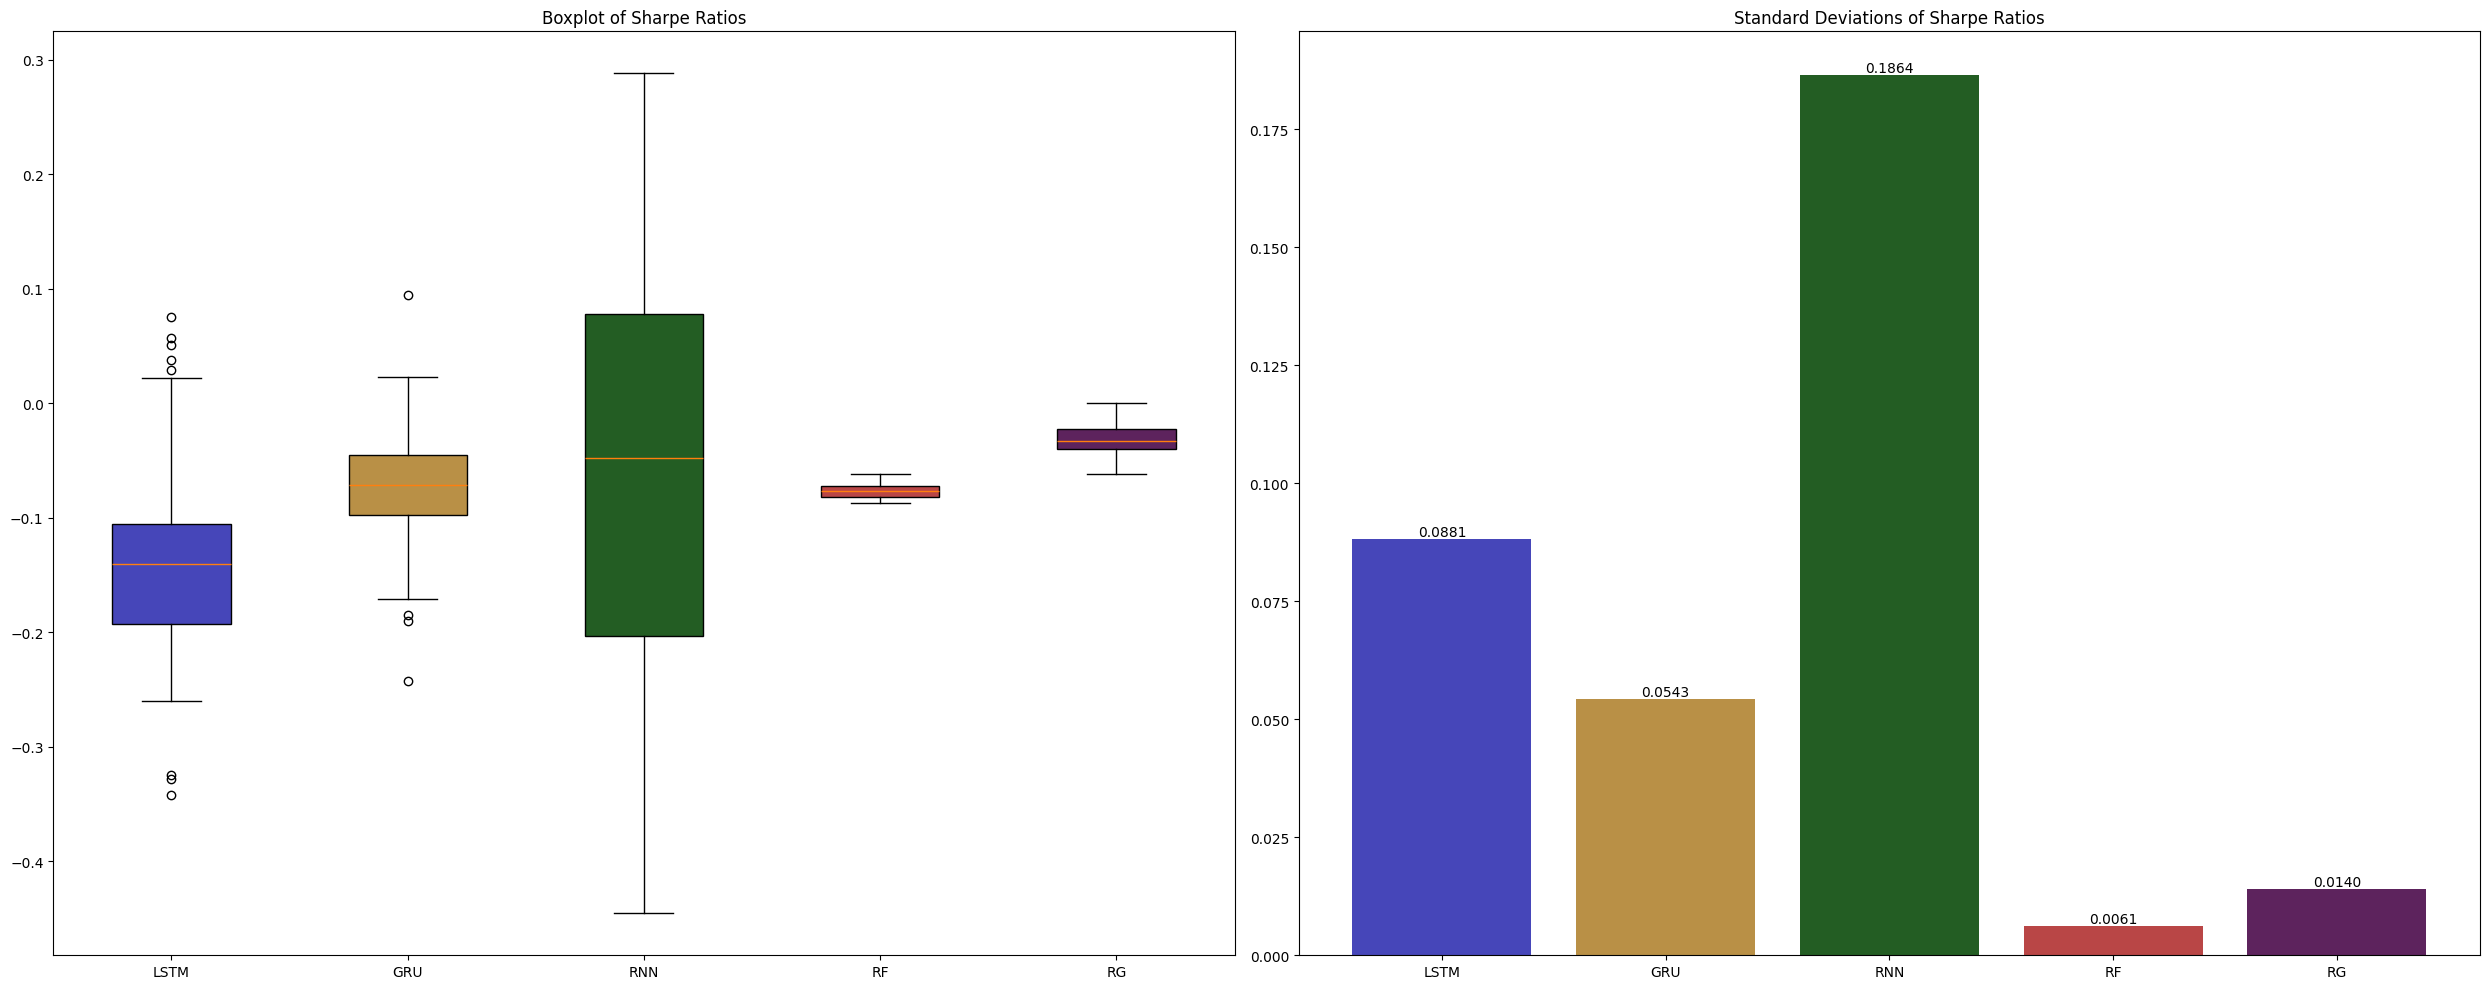

In [110]:
plot_distribution_and_stddev([           
    lstm_sharpes_1,
    gru_sharpes_1,
    rnn_sharpes_1,
    rf_sharpes_1,
    rg_sharpes_1
],
"Sharpe Ratios"
)

In [111]:
print_statistics_table_for_series([
    lstm_sharpes_1,
    gru_sharpes_1,
    rnn_sharpes_1,
    rf_sharpes_1,
    rg_sharpes_1
])

+-------+-----------------------+----------------------+-------------------------+-----------------------+----------------------+---------------------+
| model |          mean         |        median        |           max           |          min          |        stddev        |      full range     |
+-------+-----------------------+----------------------+-------------------------+-----------------------+----------------------+---------------------+
|  LSTM |  -0.13800432260573034 | -0.14055181995159138 |    0.0755829517801281   |  -0.34243339899441233 | 0.08813601825831485  |  0.4180163507745404 |
|  GRU  |  -0.0755252571992296  | -0.07170767165188129 |   0.09447207563381496   |  -0.2424764989467605  | 0.05430140553897011  |  0.3369485745805755 |
|  RNN  | -0.061687625560306124 | -0.0477391121700161  |   0.28809911144658285   |  -0.4453719950375224  | 0.18640246951682776  |  0.7334711064841053 |
|   RF  |  -0.07675205331773852 | -0.07677843474604816 |  -0.061984943362898726  |  -0.0

In [112]:
buy_and_hold_sharpe

0.017230075011876338

Inicialmente, destaca-se o fato de a maior parte dos sharpe ratios serem negativos, visualizando pelas medianas. Isso já é um indicativo de que os modelos, pelo menos metade das vezes, fazem com que o capital investido seja diminuido com o tempo. Apesar disso, analisando o range de sharpe ratios, é evidente que a RNN simples tem uma variação bem maior na performance dos portfólios preditos, dado o desvio padrão maior que o dobro do segundo maior desvio padrão. O próximo maior desvio padrão é da LSTM, que tem uma complexidade maior que a RNN simples, e pode ter variado menos nas suas predições. Em seguida, a GRU, que estaria entre a LSTM e a RNN simples em complexidade, tem um desvio padrão menor que os outros dois modelos, e superando por pouco a performance máxima da LSTM. Por fim, o Random Forest apresenta o menor desvio padrão, indicando uma certeza mais contida apesar da aleatoriedade, com o detrimento de não alcançar resultados máximos tão positivos quanto os outros modelos, ficando abaixo ainda do modelo aleatório. Os experimentos com portfólios aleatórios apresentam seu valor máximo ainda abaixo de 0, da mesma forma que a Random Forest, a menor máxima entre todos os modelos. Ainda se destaca o fato de que as redes neurais em seus piores casos performam ainda pior do que adivinhação aleatória e a RF. O Sharpe ratio negativo indica retornos de baixissimo prêmio e alto risco (uma decisão de investimentos que ninguém costuma tomar). Um sharpe maior que 0 e menor que 1 ainda indica um baixo risco e um prêmio pequeno, sendo considerado bom a partir de 1.0. Quanto maior o sharpe ratio, melhor é o prêmio em relação ao risco. Nenhum modelo consegue atingir um sharpe bom (acima de 1), mas isso pode ser causado também pelo comportamento das séries de preços em questão, corrobora-se essa teoria observando o sharpe do portfólio Buy and Hold, que fica em aprox. 0.0172, de baixo risco e prêmio pequeno.

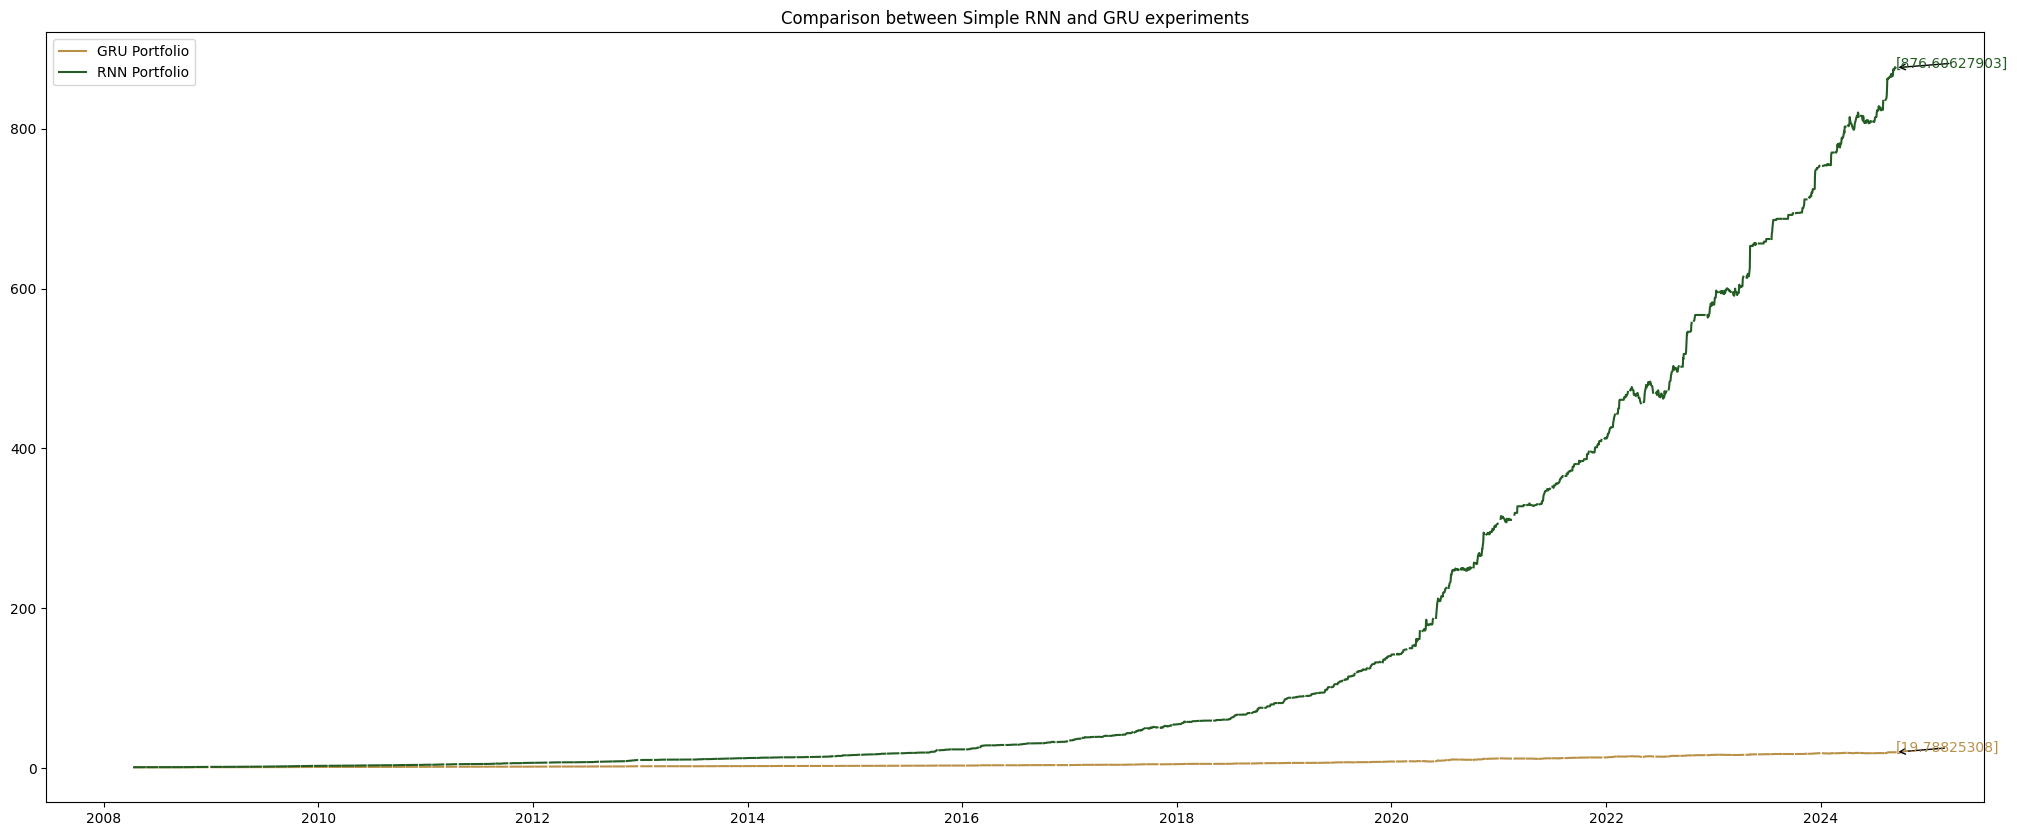

In [113]:
plot_many_returns_series(
    [cuml_perf_gru_1, cuml_perf_rnn_1],
    ["GRU Portfolio", "RNN Portfolio"], 
    daily_returns.index,
    [model_colors["GRU"], model_colors["RNN"]],
    "Comparison between Simple RNN and GRU experiments",
)

O melhor experimento da RNN com o maior sharpe ratio multiplica o valor investido em 877, enquanto o melhor GRU multiplica o valor investido em 19x, ambos superando o buy and hold, de aproximadamente 8x

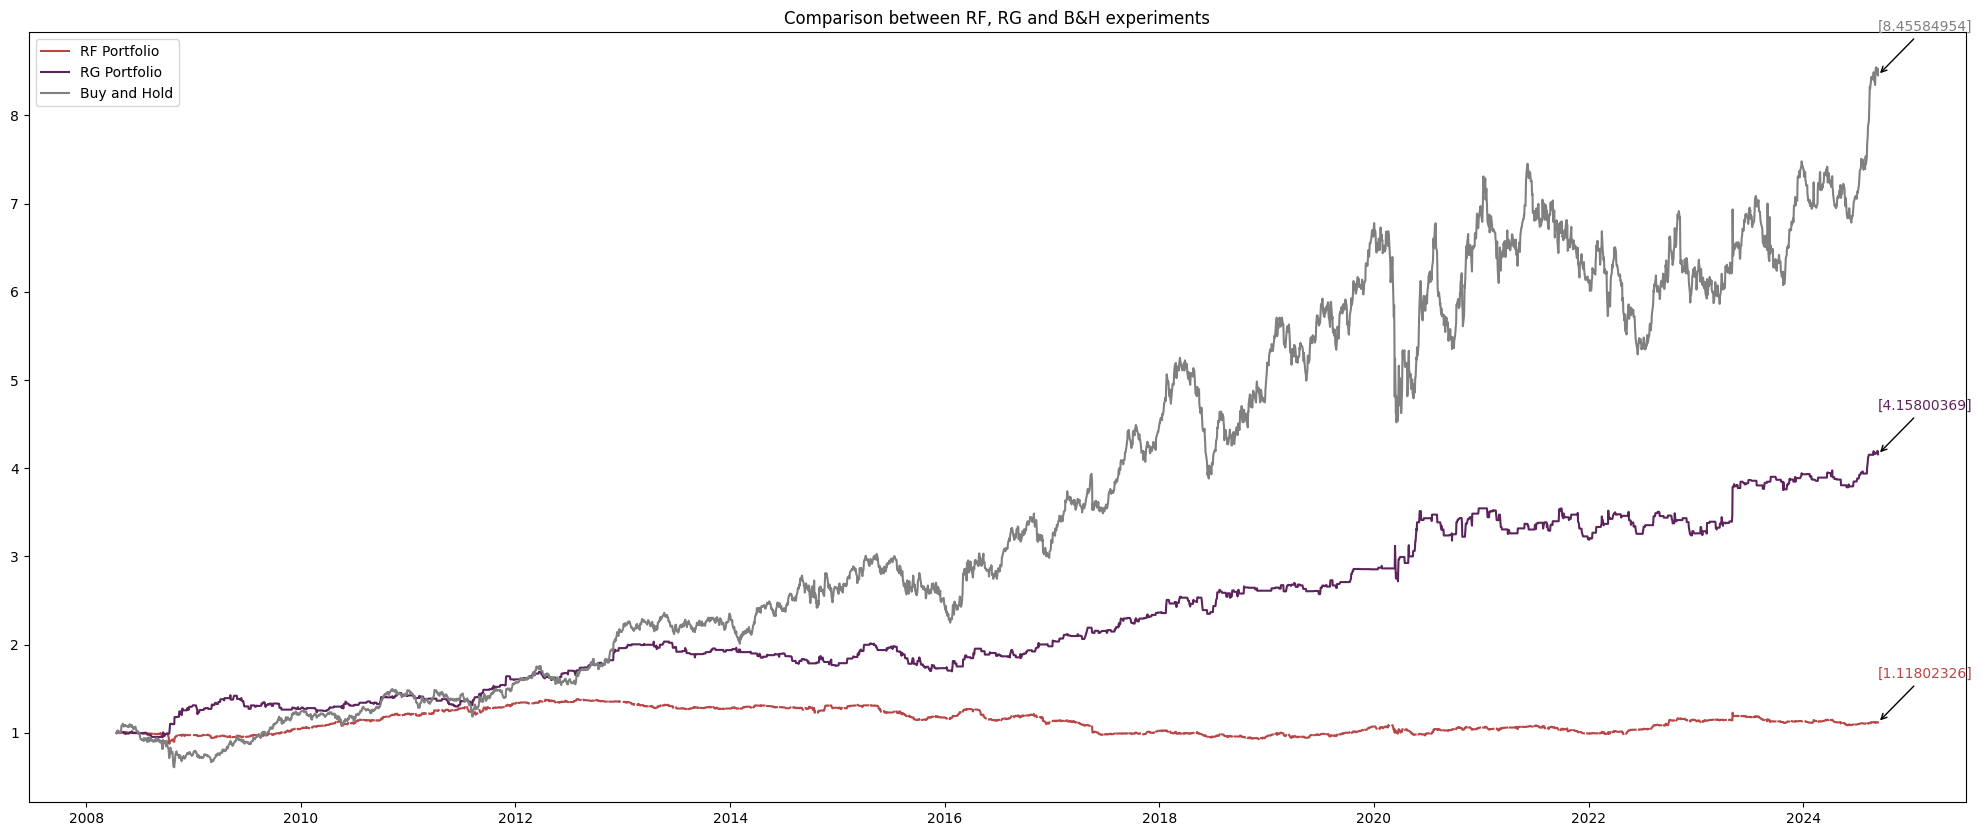

In [114]:
plot_many_returns_series(
    [cuml_perf_rf_1, cuml_perf_rg_1, buy_and_hold_cuml_returns],
    ["RF Portfolio", "RG Portfolio", "Buy and Hold"], 
    daily_returns.index,
    [model_colors["RF"], model_colors["RG"], model_colors["B&H"]],
    "Comparison between RF, RG and B&H experiments"
)

Os dois piores modelos, em seus melhores casos, não superam o buy and hold. A random forest ainda consegue perder para o portfólio aleatório.

### Distribuição das acurácias

In [115]:
def get_metric_distribution_from_results(results, metric):
    metric_series = []
    for result in results:
        metric_sum = result["abev3"][0][metric] + result["bbdc3"][0][metric] + result["itub3"][0][metric] + result["itsa3"][0][metric] + result["wege3"][0][metric]
        metric_series.append(metric_sum / 5)

    return metric_series

In [116]:
lstm_accs_1 = get_metric_distribution_from_results(results_lstm_1, "accuracy")
gru_accs_1 = get_metric_distribution_from_results(results_gru_1, "accuracy")
rnn_accs_1 = get_metric_distribution_from_results(results_rnn_1, "accuracy")
rf_accs_1 = get_metric_distribution_from_results(results_rf_1, "accuracy")
rg_accs_1 = get_metric_distribution_from_results(results_rg_1, "accuracy")

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_26105/2299270969.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(


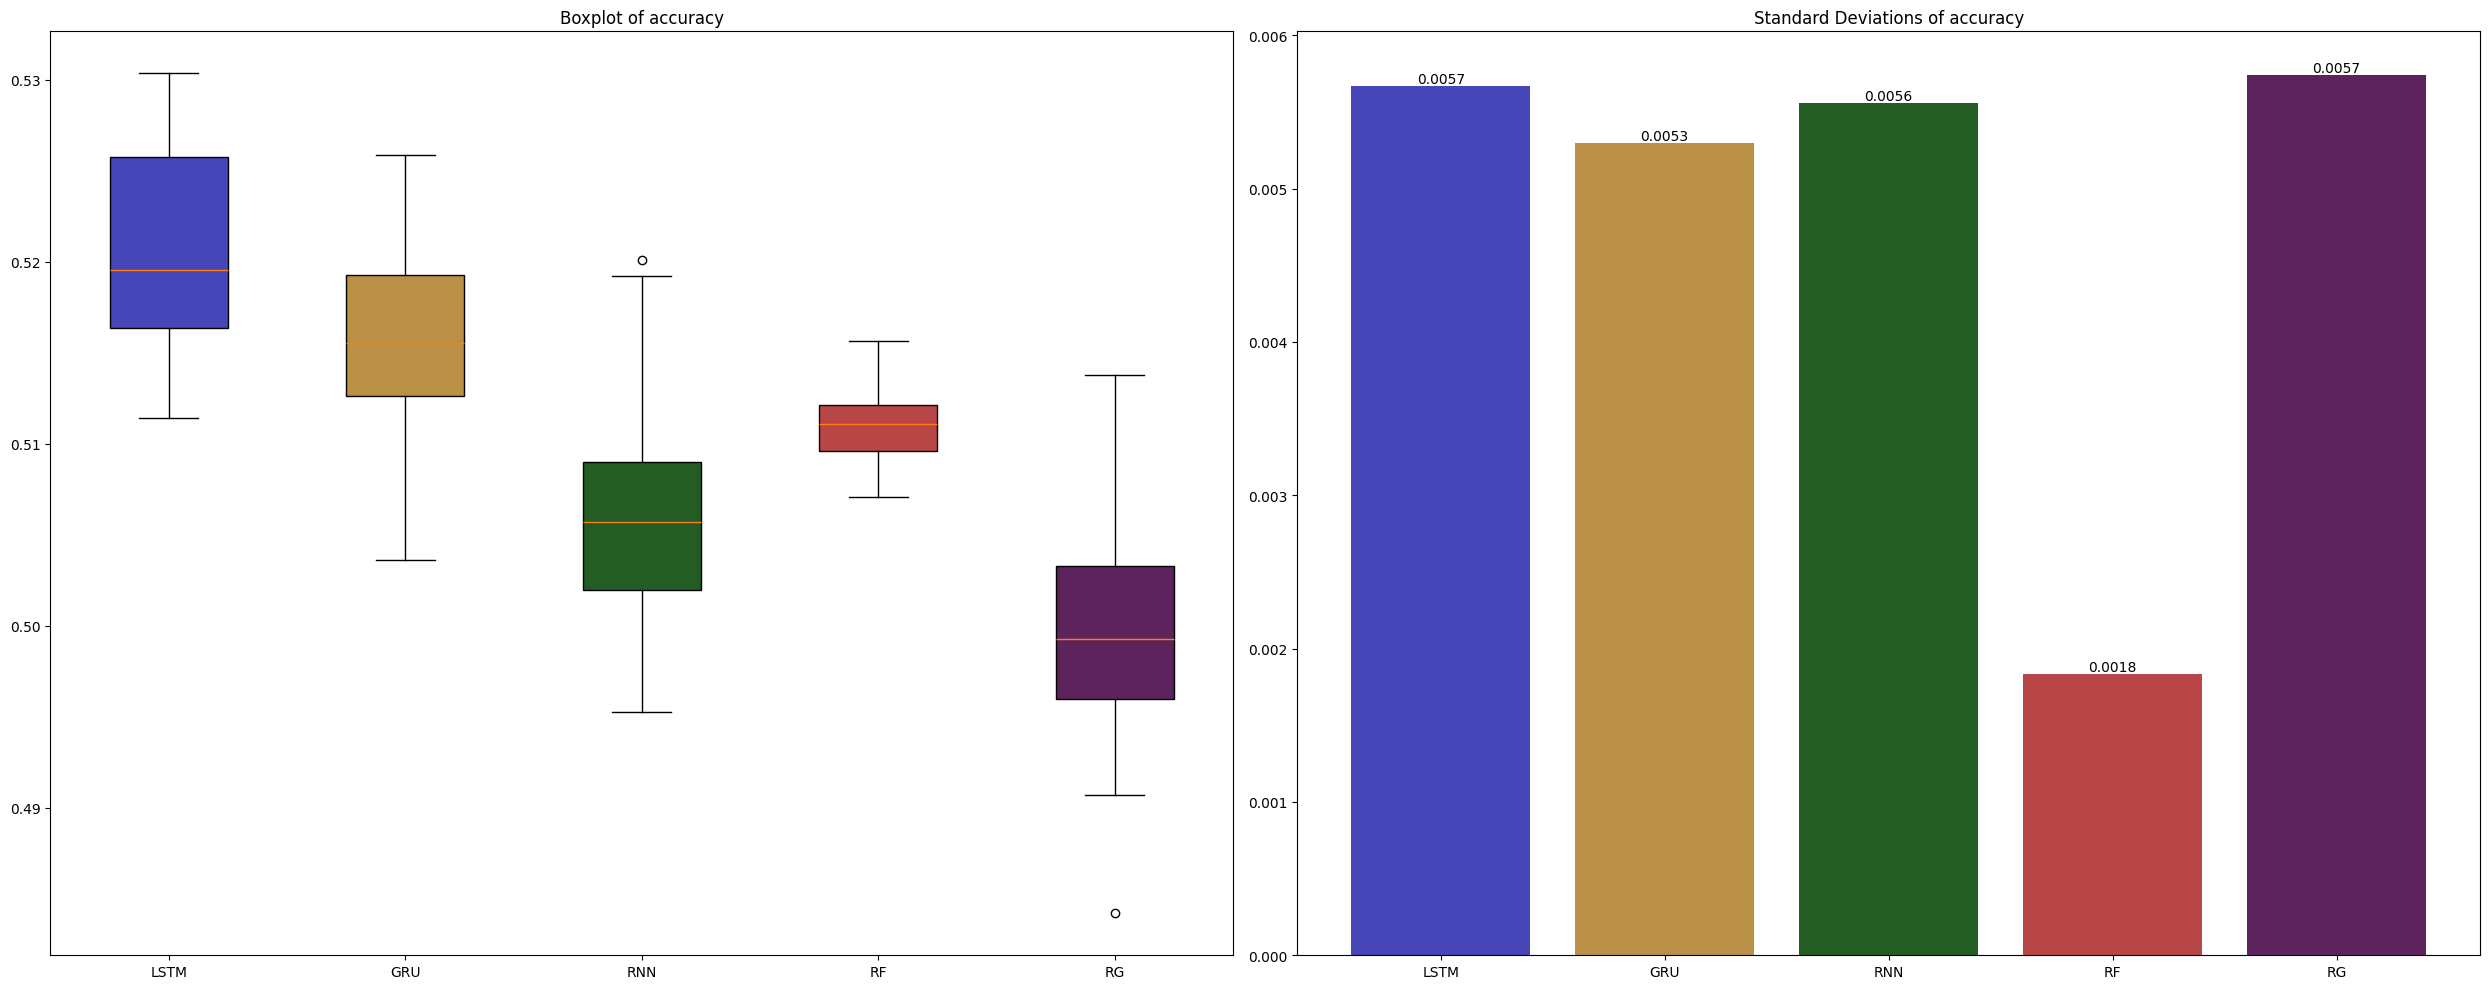

In [117]:
plot_distribution_and_stddev([
    lstm_accs_1,
    gru_accs_1,
    rnn_accs_1,
    rf_accs_1,
    rg_accs_1
], "accuracy")

In [118]:
print_statistics_table_for_series([
    lstm_accs_1,
    gru_accs_1,
    rnn_accs_1,
    rf_accs_1,
    rg_accs_1
])

+-------+---------------------+---------------------+--------------------+--------------------+-----------------------+----------------------+
| model |         mean        |        median       |        max         |        min         |         stddev        |      full range      |
+-------+---------------------+---------------------+--------------------+--------------------+-----------------------+----------------------+
|  LSTM |  0.5208795750672252 |  0.5195345531973826 | 0.5303586192570025 | 0.5114155731745318 |  0.005671188141263187 | 0.01894304608247066  |
|  GRU  |  0.515519278352895  |  0.5155639995845307 | 0.5258880310217082 | 0.5036497939964686 |  0.005294395474250628 | 0.022238237025239638 |
|  RNN  |  0.5060718329120937 |  0.505737354152962  | 0.5201230135373749 | 0.4952939099124052 |  0.005555926775671381 | 0.024829103624969706 |
|   RF  |  0.5109509342289005 |  0.5110911608904891 | 0.5156501748433334 | 0.5070612471003704 | 0.0018353661498625173 | 0.008588927742963048 |

As acurácias revolvem ao redor de 50%, todas superando a adivinhação aleatória em mediana, e com um range não muito alto, nunca passando da máxima dos 53% de acurácia. Novamente, a Random Forest apresenta o menor desvio padrão, apresentando mais consistência frente a aleatoriedade com ganhos menores. Aqui, diferente dos sharpe ratios, o maior desvio padrão é da LSTM, mostrando que essa arquitetura tem uma variação maior na corretude, e apesar disso, não supera a RNN simples em sharpe ratios. O fato de nenhum modelo quebrar a marca dos 50% de acurácia informa que nenhum tem "muito mais certeza do que está fazendo" do que o modelo aleatório, confirmando a observação geral da literatura sobre a dificuldade de realizar previsões em séries ruidosas como essas de retornos.

### Distribuição dos F1 Scores

In [119]:
lstm_f1_1 = get_metric_distribution_from_results(results_lstm_1, "f1")
gru_f1_1 = get_metric_distribution_from_results(results_gru_1, "f1")
rnn_f1_1 = get_metric_distribution_from_results(results_rnn_1, "f1")
rf_f1_1 = get_metric_distribution_from_results(results_rf_1, "f1")
rg_f1_1 = get_metric_distribution_from_results(results_rg_1, "f1")

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_26105/2299270969.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(


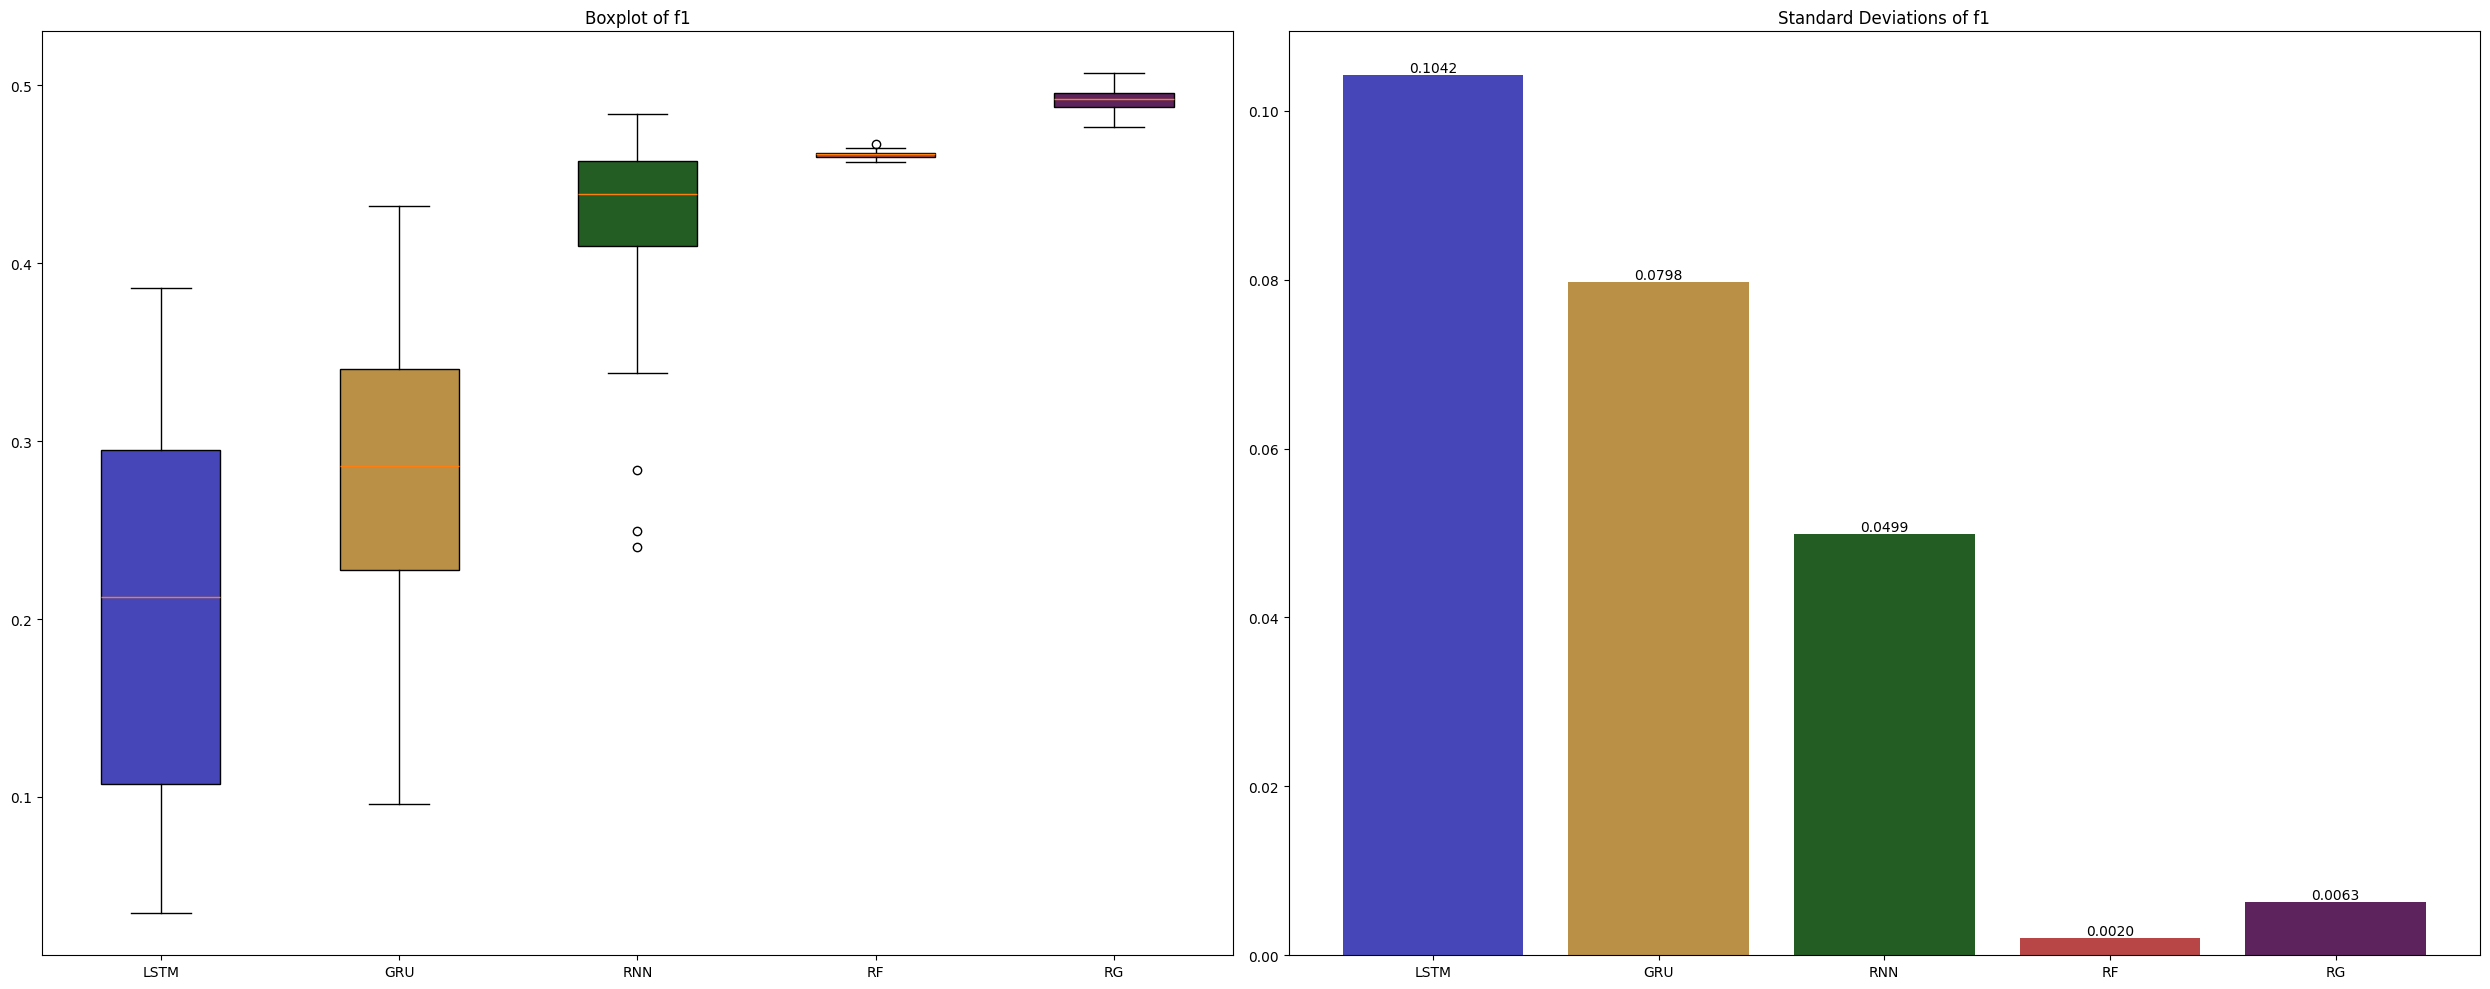

In [120]:
plot_distribution_and_stddev([
    lstm_f1_1,
    gru_f1_1,
    rnn_f1_1,
    rf_f1_1,
    rg_f1_1
], "f1")

In [121]:
print_statistics_table_for_series([
    lstm_f1_1,
    gru_f1_1,
    rnn_f1_1,
    rf_f1_1,
    rg_f1_1
])

+-------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+
| model |         mean        |        median       |         max         |         min          |        stddev        |      full range      |
+-------+---------------------+---------------------+---------------------+----------------------+----------------------+----------------------+
|  LSTM | 0.20480204675188568 | 0.21261696386953144 |  0.3860949744163055 | 0.034582514970059874 | 0.10419117165236465  | 0.35151245944624565  |
|  GRU  |  0.2797965199175454 |  0.2862720725256227 | 0.43208942016370894 | 0.09579742961973109  | 0.07977347781685551  | 0.33629199054397785  |
|  RNN  | 0.42539353313032335 |  0.438775844219773  | 0.48394112924388705 | 0.24061059263409312  | 0.04987750264245889  | 0.24333053660979392  |
|   RF  | 0.46101682319043713 |  0.4612008486611088 |  0.4668992539358989 | 0.45713307249945173  | 0.002046952197165178 | 0.009766

É interessante ver que a adivinhação aleatória apresenta uma série de valores para o F1 mais contida próxima ao valor máximo. A máxima de 0.5 ainda não é suficiente para admitir uma boa performance, mas corrobora com a aleatoriedade, que não faz um grande tradeoff entre precisão e recall, é apenas aleatória. As redes neurais, por outro lado, alcançam valores tão baixos quanto 0.03 como no caso da LSTM, apontando um tradeoff grave de um em detrimento do outro, em diferentes tentativas de aprender os padrões para tomar uma decisão.

### Análise de tempo de treinamento

In [122]:
lstm_time_1 = get_metric_distribution_from_results(results_lstm_1, "dataset_fit_predict_time")
gru_time_1 = get_metric_distribution_from_results(results_gru_1, "dataset_fit_predict_time")
rnn_time_1 = get_metric_distribution_from_results(results_rnn_1, "dataset_fit_predict_time")
rf_time_1 = get_metric_distribution_from_results(results_rf_1, "dataset_fit_predict_time")

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_26105/2299270969.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(


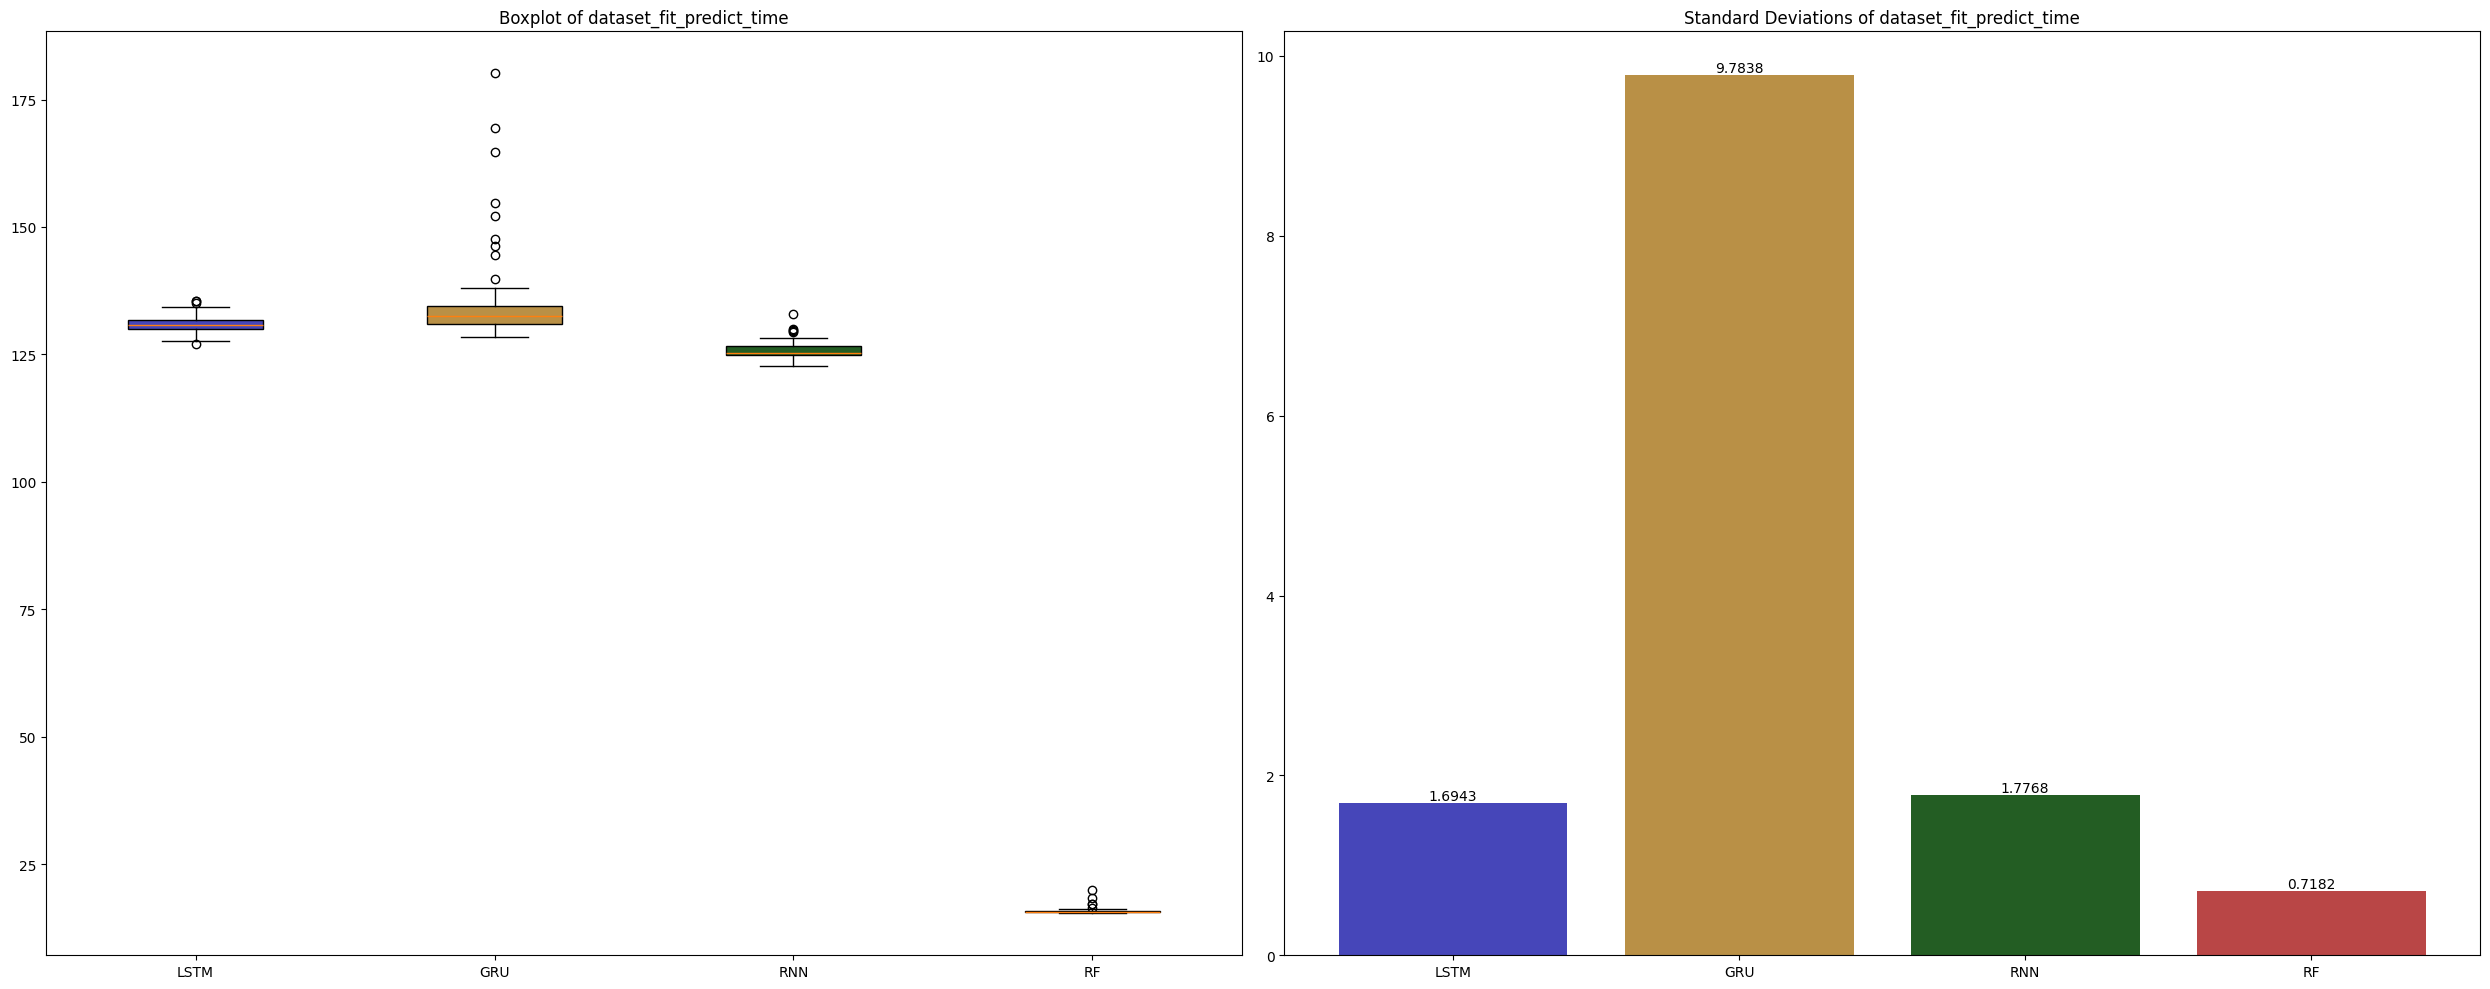

In [123]:
plot_distribution_and_stddev([
    lstm_time_1,
    gru_time_1,
    rnn_time_1,
    rf_time_1
], "dataset_fit_predict_time")

Apenas visualizando o box plot, não parece haver uma clara correlação entre a complexidade da rede neural e o tempo de treinamento/inferencia. Todas as redes neurais tem um tempo mais ou menos similar, com a característica em comum de durar mais do que a Random Forest, um algoritmo consideravelmente mais simples que não implementa o gradiente descendente.

### Correlação entre Sharpes e acurácias; Sharpes e F1; Acc e F1

In [124]:
sharpes_accs_pairs = [
    (lstm_sharpes_1, lstm_accs_1),
    (gru_sharpes_1, gru_accs_1),
    (rnn_sharpes_1, rnn_accs_1),
    (rf_sharpes_1, rf_accs_1)
]

sharpes_f1s_pairs = [
    (lstm_sharpes_1, lstm_f1_1),
    (gru_sharpes_1, gru_f1_1),
    (rnn_sharpes_1, rnn_f1_1),
    (rf_sharpes_1, rf_f1_1)
]

accs_f1s_pairs = [
    (lstm_accs_1, lstm_f1_1),
    (gru_accs_1, gru_f1_1),
    (rnn_accs_1, rnn_f1_1),
    (rf_accs_1, rf_f1_1)
]

model_list = ["LSTM", "GRU", "RNN", "RF"]

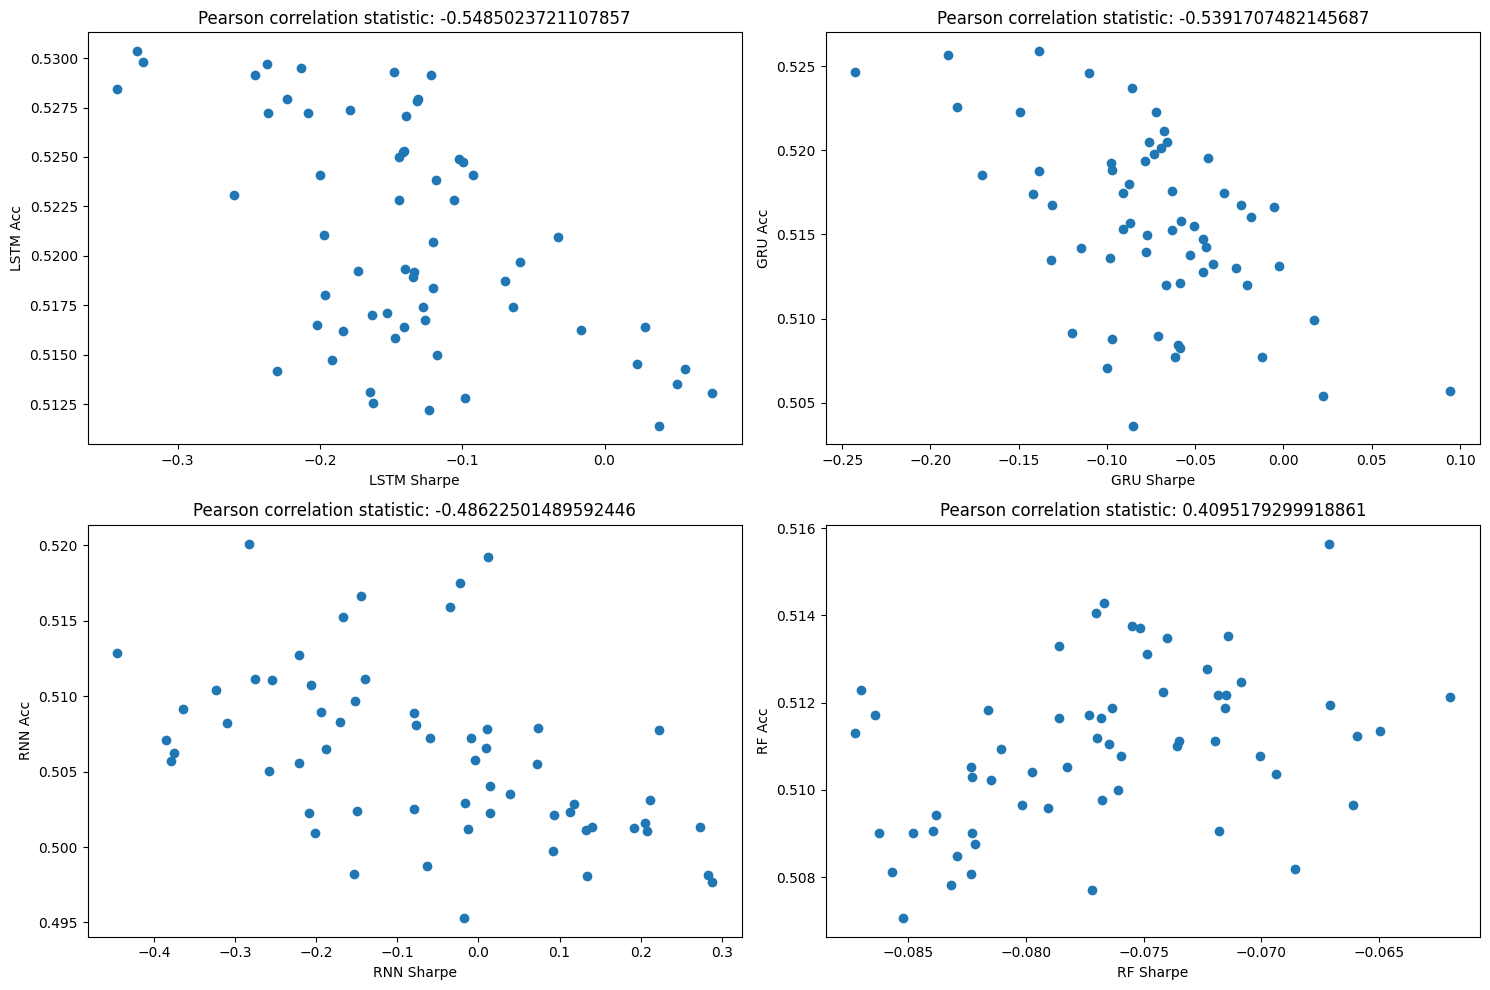

In [125]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = sharpes_accs_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"Pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} Sharpe")
    ax.set_ylabel(f"{model_list[i]} Acc")

plt.tight_layout()
plt.show()

Aqui é evidente que não há muita correlação entre o sharpe e as acurácias nos modelos. A correlação mais forte é de -0.54 no caso da LSTM, mas no geral, não se pode afirmar que uma acurácia maior de classificação leva a um sharpe ratio maior também. Pode-se teorizar que pra esse tipo de problema, com essa base de dados e esses modelos, a melhor performance por vias de sharpe ratio não é atingida por um modelo com acurácias mais satisfatórias, e a boa performance pode ser puramente pelo acaso.

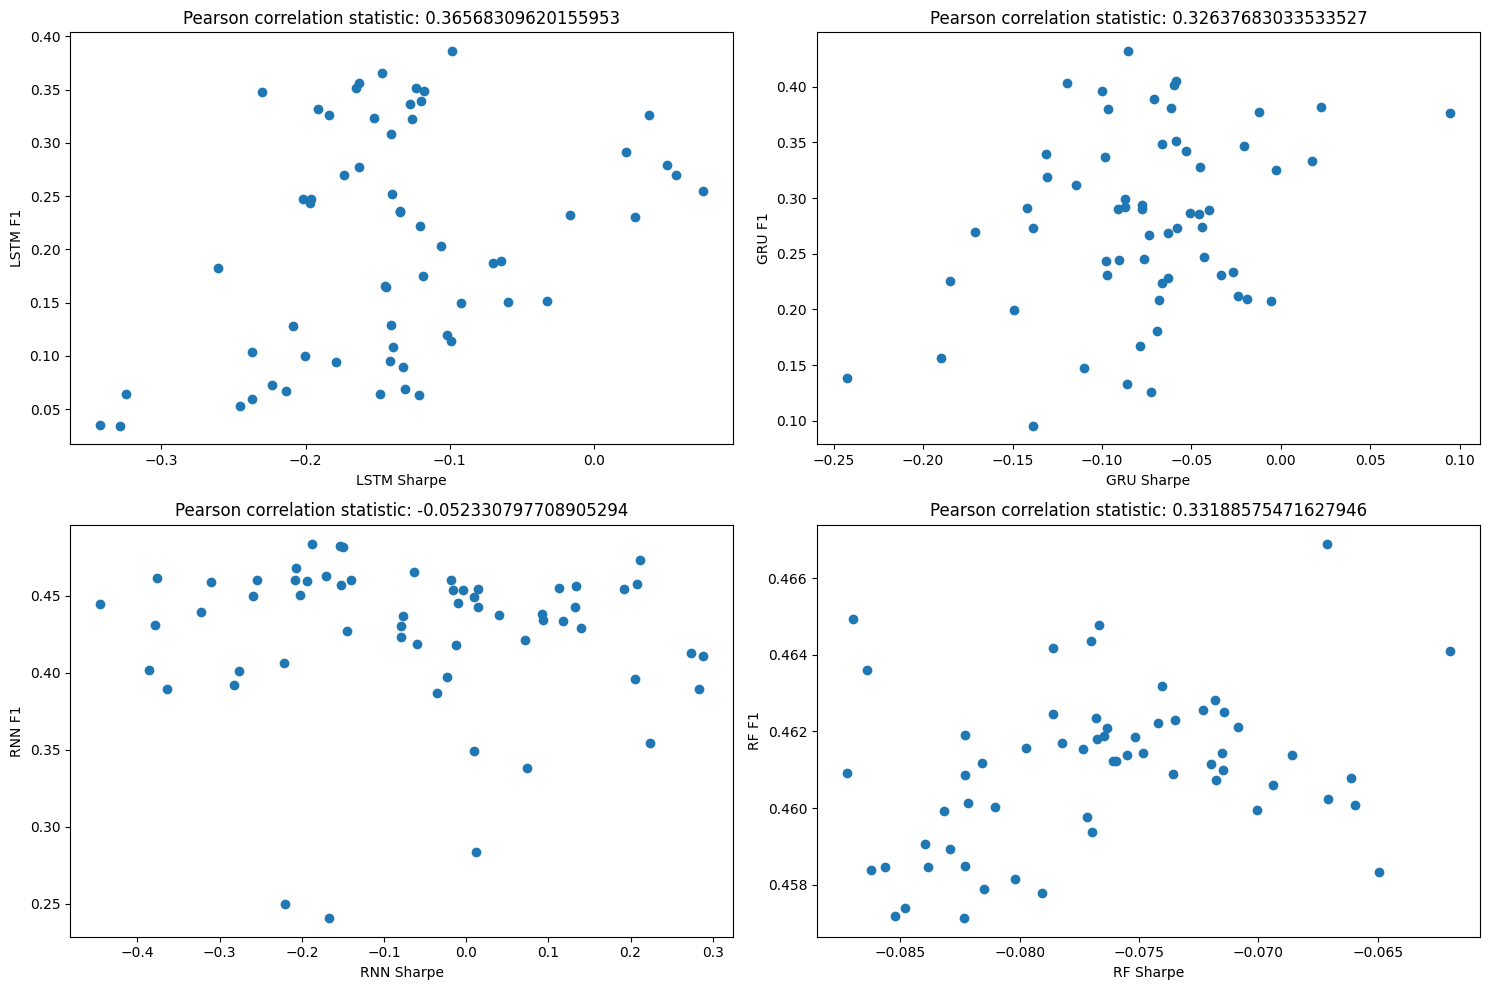

In [126]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = sharpes_f1s_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"Pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} Sharpe")
    ax.set_ylabel(f"{model_list[i]} F1")

plt.tight_layout()
plt.show()

A mesma observação feita sobre a correlação entre as acurácias e o sharpe ratio pode ser feita sobre o F1 Score

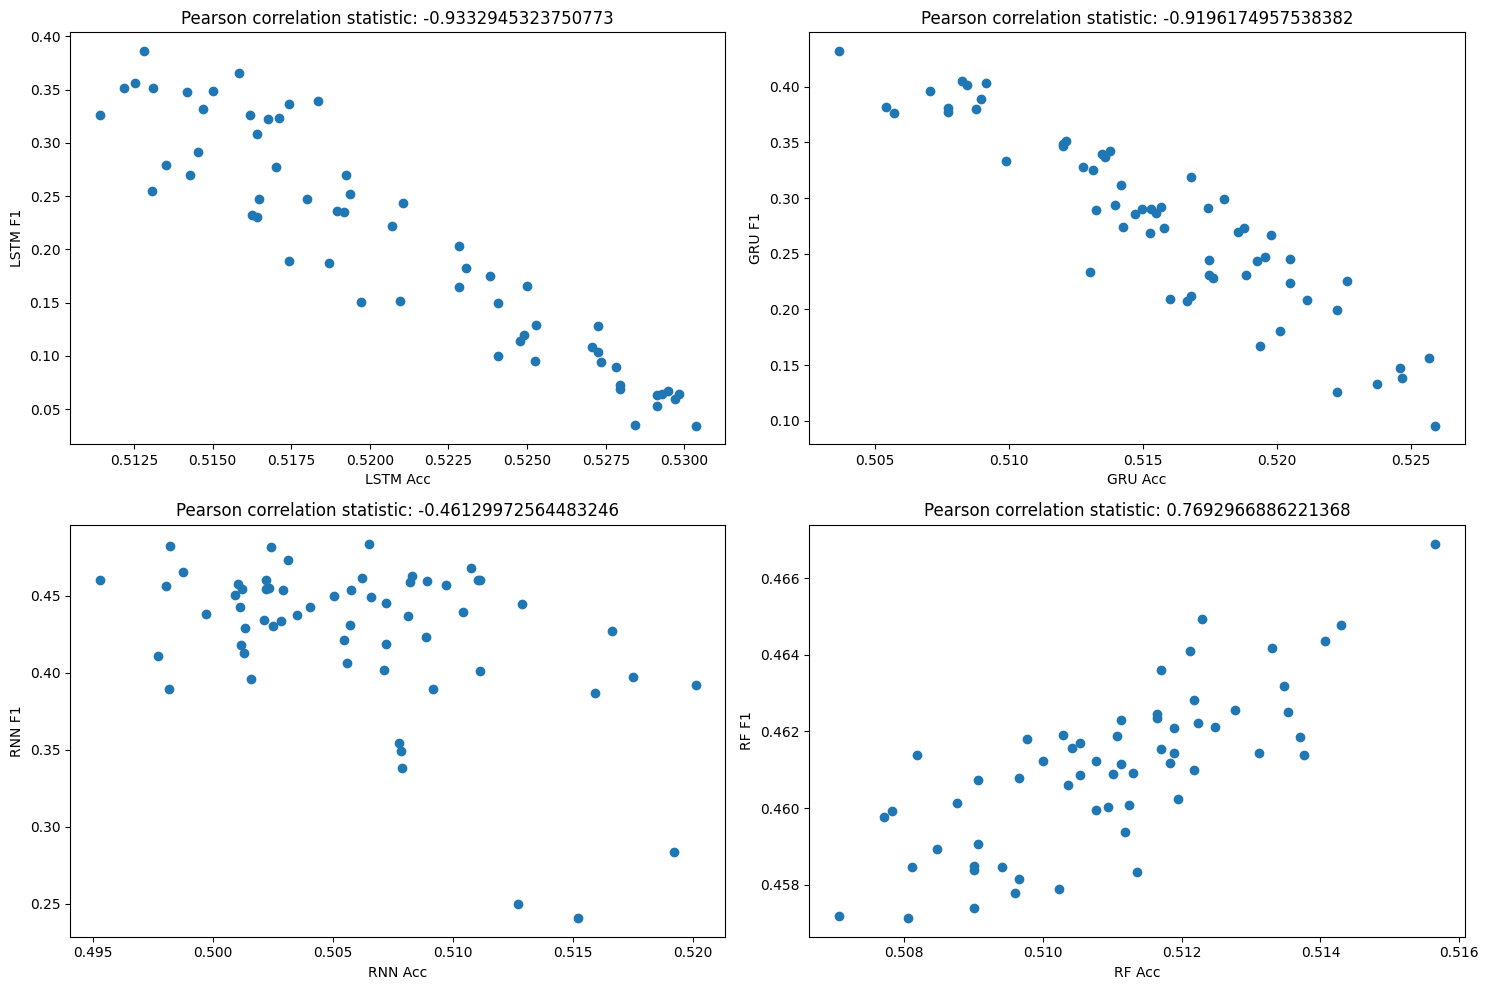

In [127]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = accs_f1s_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"Pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} Acc")
    ax.set_ylabel(f"{model_list[i]} F1")

plt.tight_layout()
plt.show()

Duas das arquiteturas de redes neurais - LSTM e GRU - tem correlação negativa entre F1 e acurácia. O F1 score é uma média harmônica entre precisão e recall, e é puxado para baixo caso a precisão ou o recall caiam. Uma melhora na acurácia de um modelo pode acontecer em detrimento de uma dessas métricas. Aqui se faz necessário analisar a precisão x recall x acurácia desses dois modelos para entender melhor o que está acontecendo.

## precisão x recall x acurácia na LSTM e GRU

In [128]:
lstm_precision_1 = get_metric_distribution_from_results(results_lstm_1, "precision")
gru_precision_1 = get_metric_distribution_from_results(results_gru_1, "precision")

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_26105/2299270969.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(


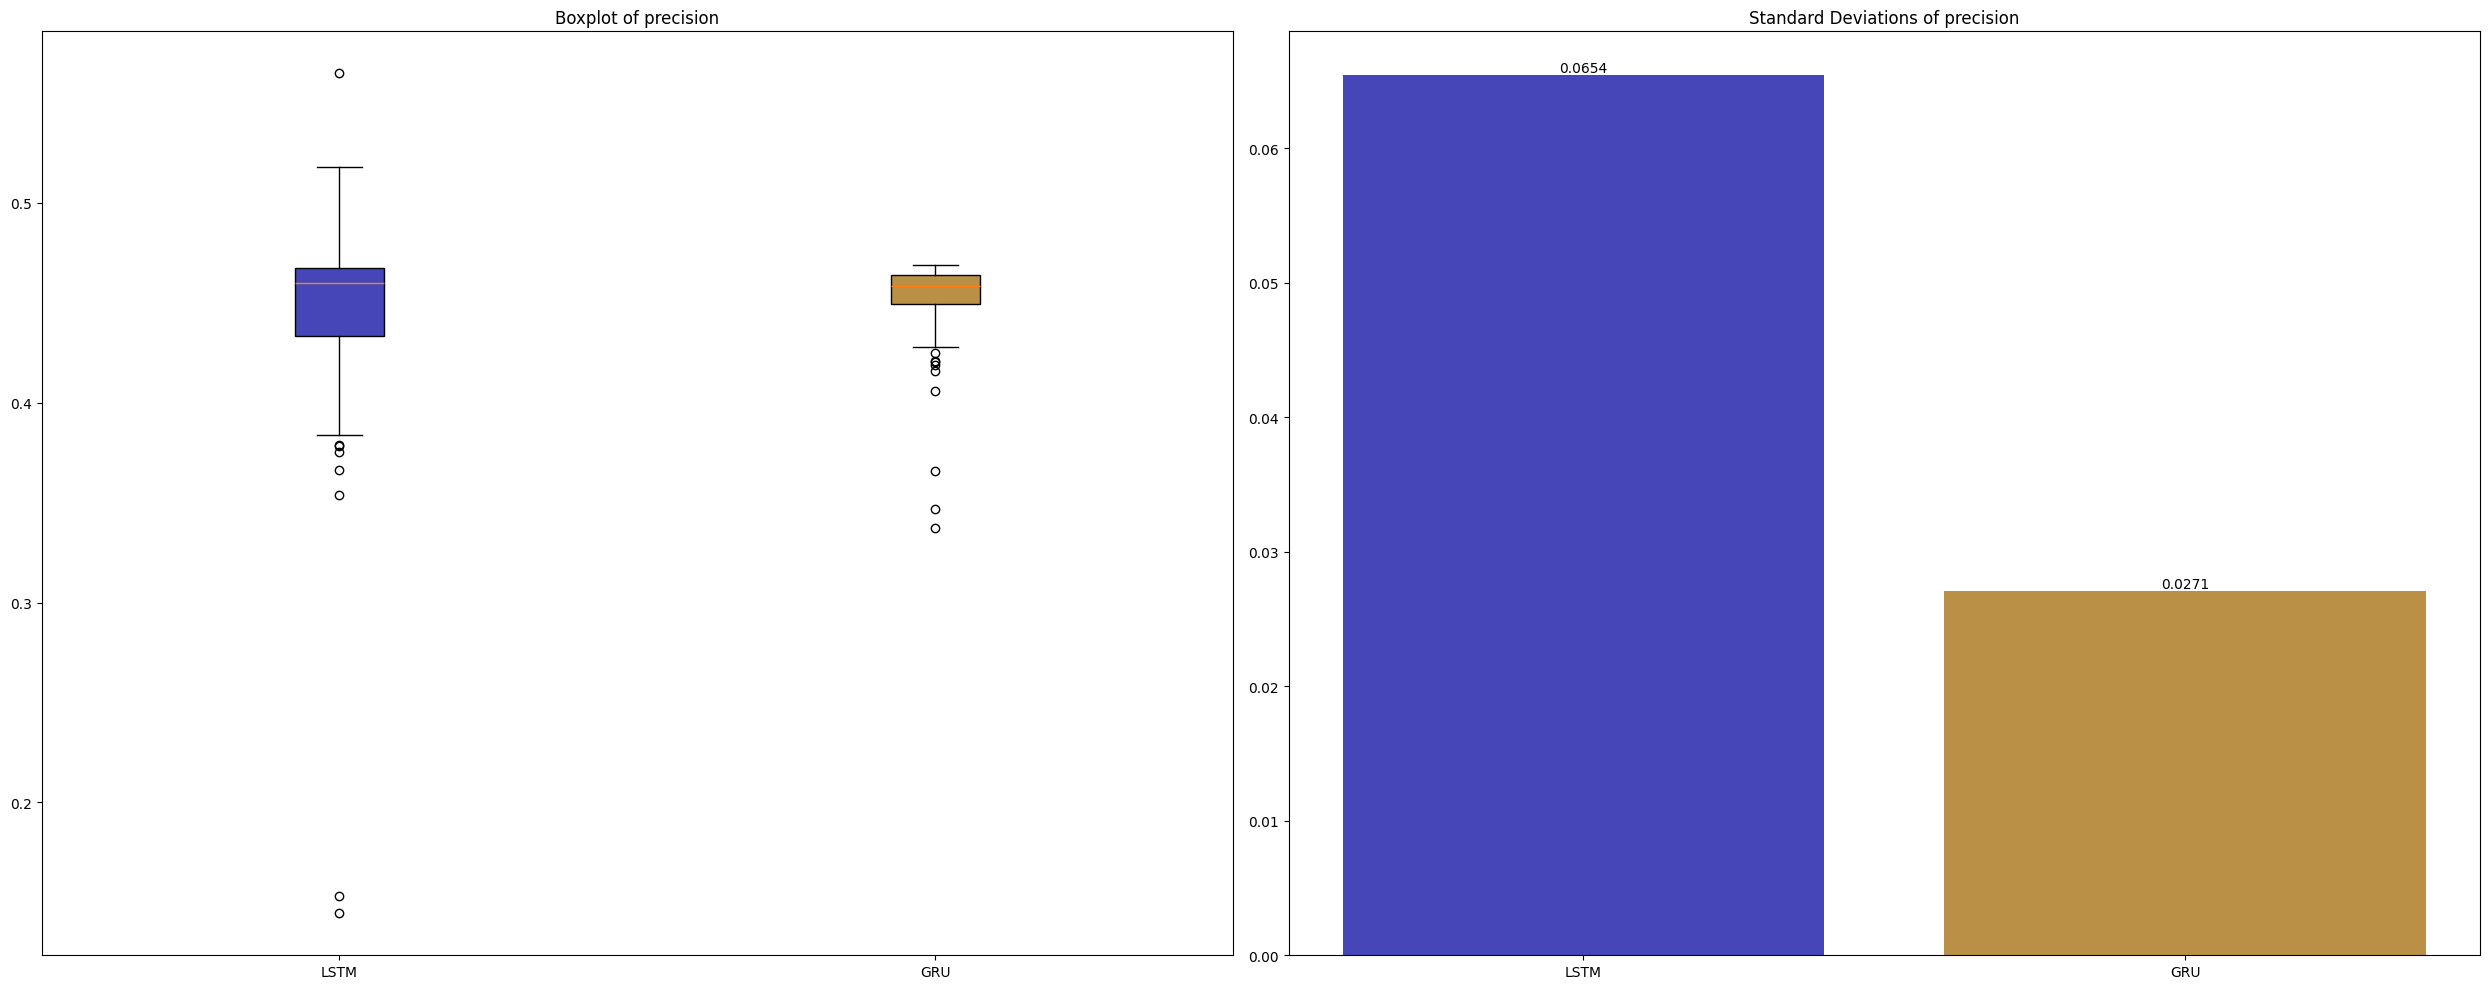

In [129]:
plot_distribution_and_stddev([
    lstm_precision_1,
    gru_precision_1,
], "precision")

In [130]:
lstm_recall_1 = get_metric_distribution_from_results(results_lstm_1, "recall")
gru_recall_1 = get_metric_distribution_from_results(results_gru_1, "recall")

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_26105/2299270969.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(


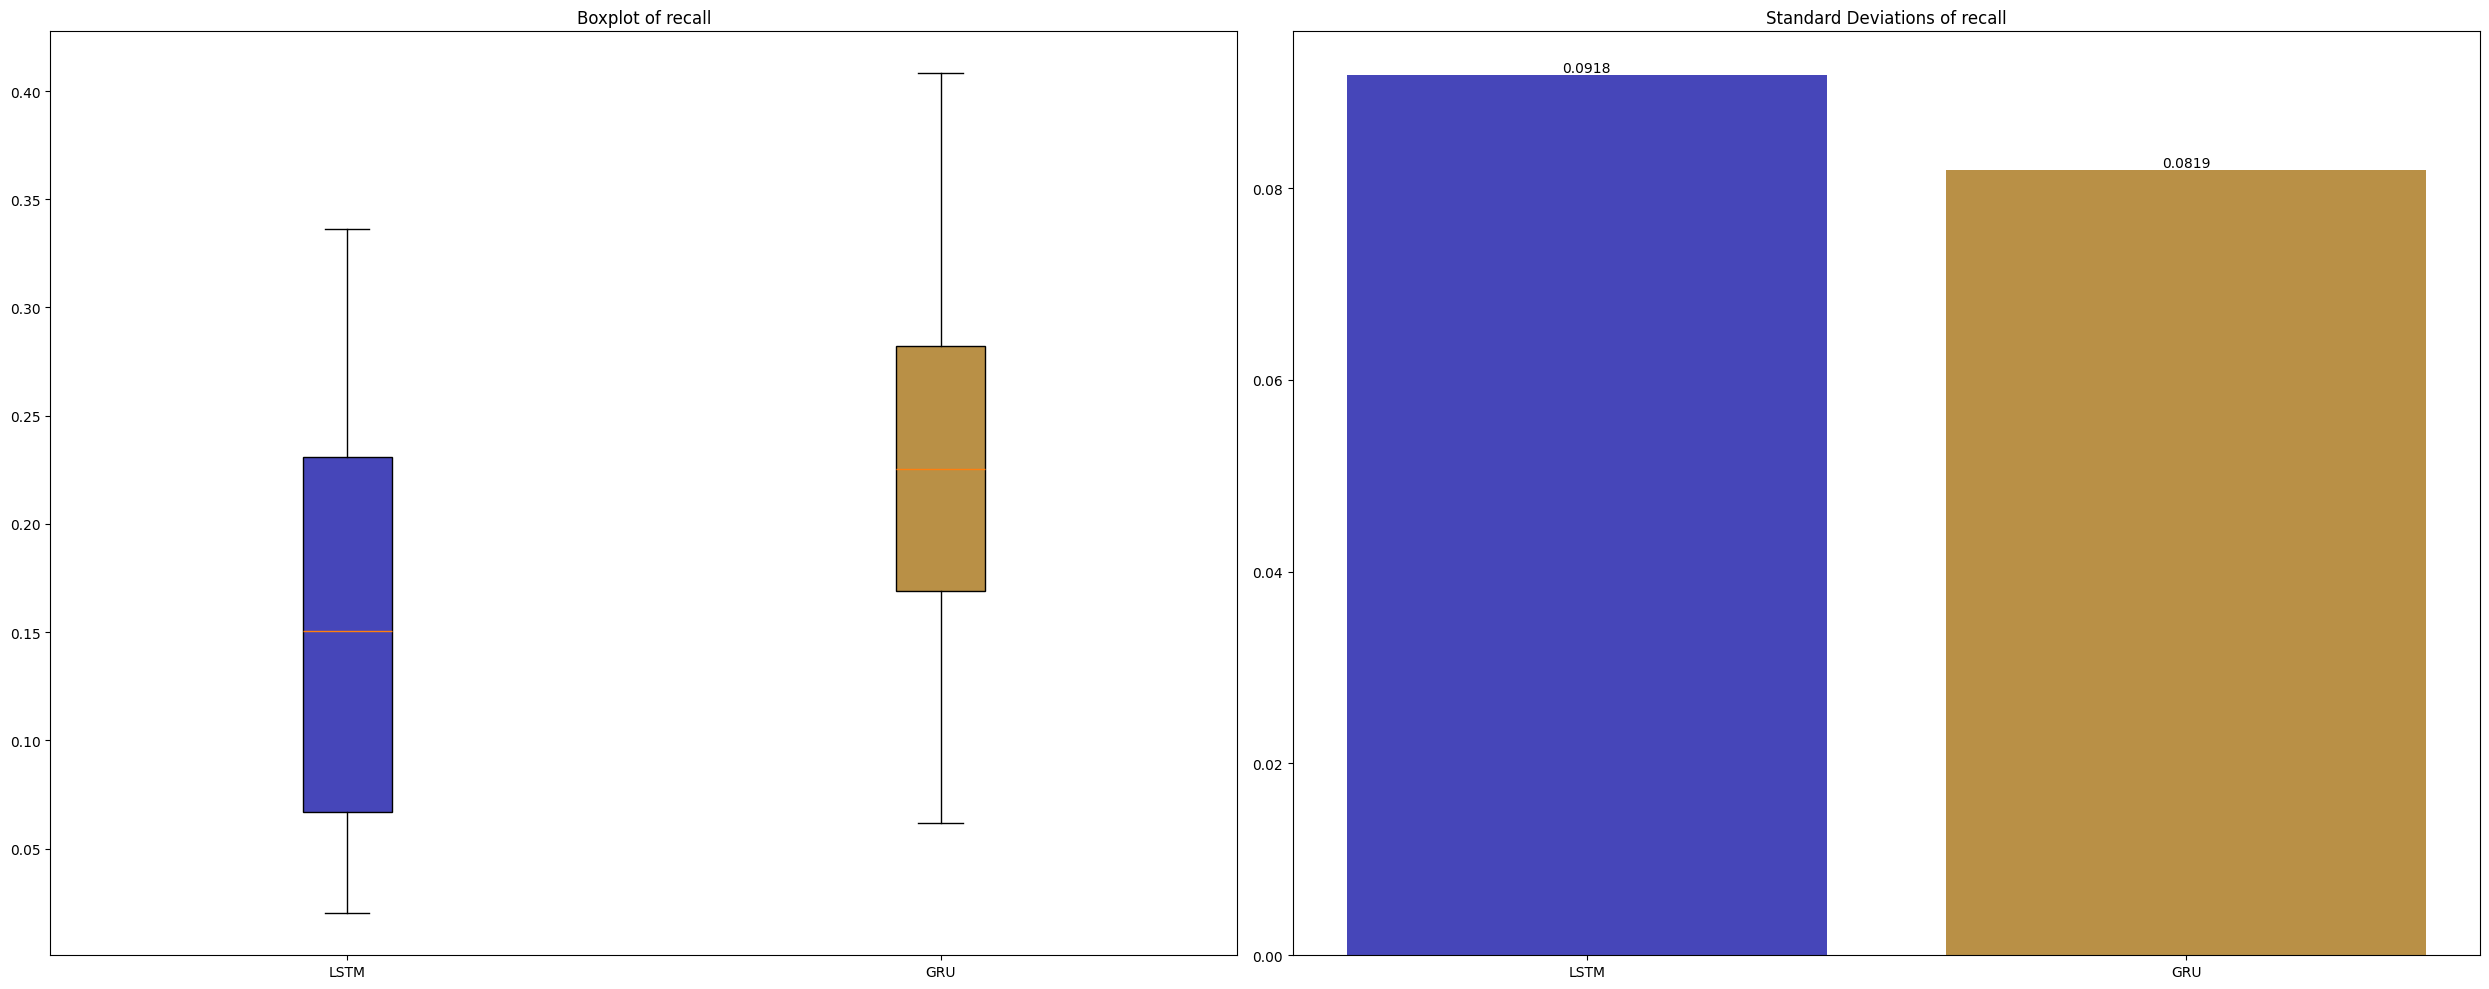

In [131]:
plot_distribution_and_stddev([
    lstm_recall_1,
    gru_recall_1,
], "recall")

In [132]:
precision_accs_pairs = [
    (lstm_precision_1, lstm_accs_1),
    (gru_precision_1, gru_accs_1)
]

recall_accs_pairs = [
    (lstm_recall_1, lstm_accs_1),
    (gru_recall_1, gru_accs_1)
]

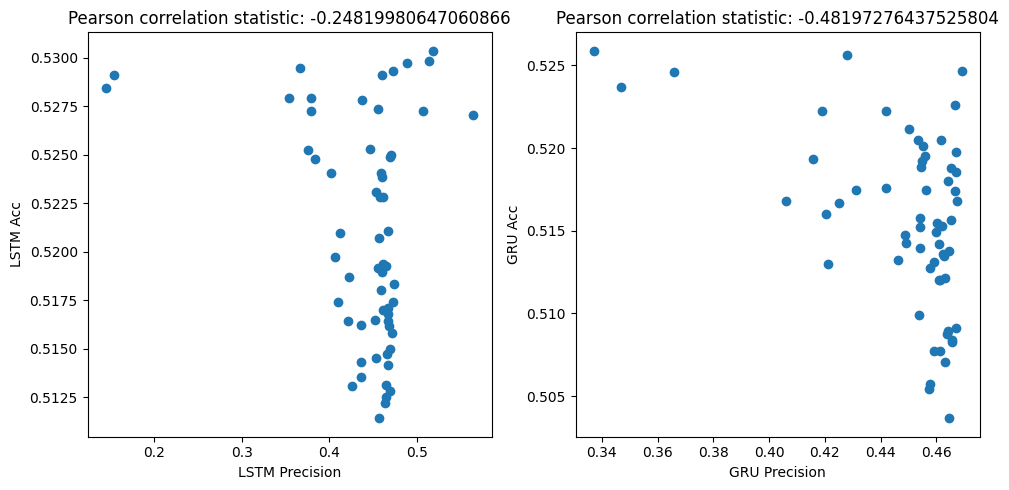

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = precision_accs_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"Pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} Precision")
    ax.set_ylabel(f"{model_list[i]} Acc")

plt.tight_layout()
plt.show()

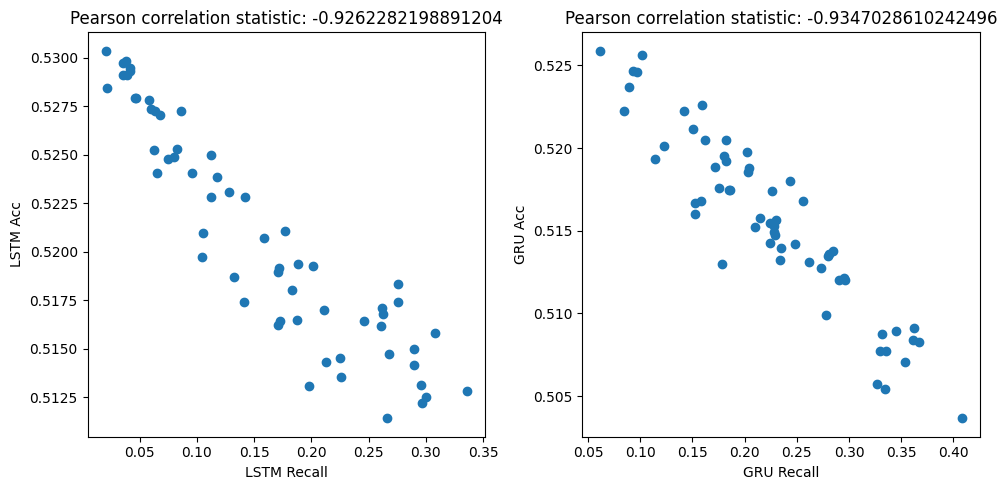

In [134]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = recall_accs_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"Pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} Recall")
    ax.set_ylabel(f"{model_list[i]} Acc")

plt.tight_layout()
plt.show()

Não há correlação linear direta entre a precisão e a acurácia, mas a mesma correlação observada entre o F1 e a acurácia é observada entre o recall e a acurácia, indicando que a acurácia melhora em detrimento do recall, e é o próprio recall que puxa o F1 para baixo.

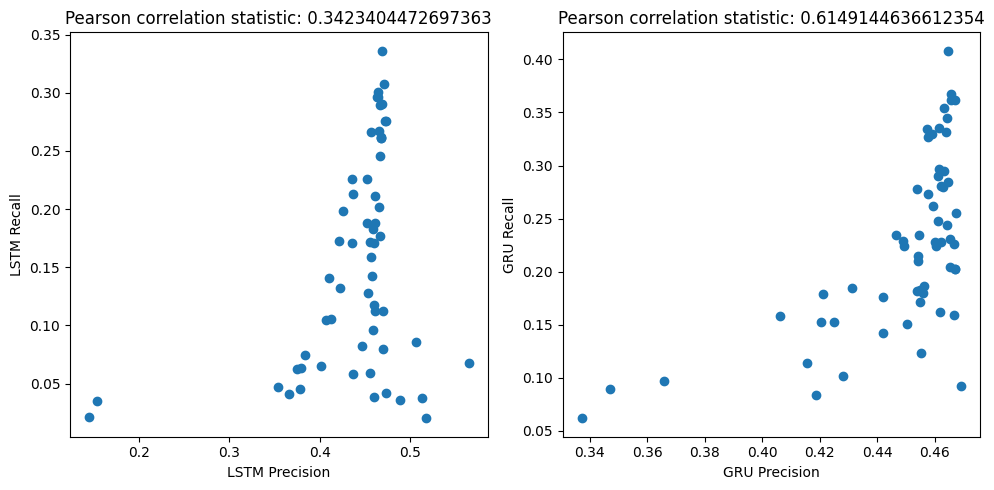

In [135]:
precision_recall_pairs = [
    (lstm_precision_1, lstm_recall_1),
    (gru_precision_1, gru_recall_1)
]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = precision_recall_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"Pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} Precision")
    ax.set_ylabel(f"{model_list[i]} Recall")

plt.tight_layout()
plt.show()

Não se observa nenhum tipo de correlação entre uma melhora no recall e uma piora na precisão ou similares.

## precisão / recall x sharpe

In [136]:
rnn_recall_1 = get_metric_distribution_from_results(results_rnn_1, "recall")
rf_recall_1 = get_metric_distribution_from_results(results_rf_1, "recall")

rnn_precision_1 = get_metric_distribution_from_results(results_rnn_1, "precision")
rf_precision_1 = get_metric_distribution_from_results(results_rf_1, "precision")

In [137]:
sharpes_precision_pairs = [
    (lstm_sharpes_1, lstm_precision_1),
    (gru_sharpes_1, gru_precision_1),
    (rnn_sharpes_1, rnn_precision_1),
    (rf_sharpes_1, rf_precision_1)
]

sharpes_recalls_pairs = [
    (lstm_sharpes_1, lstm_f1_1),
    (gru_sharpes_1, gru_f1_1),
    (rnn_sharpes_1, rnn_f1_1),
    (rf_sharpes_1, rf_f1_1)
]


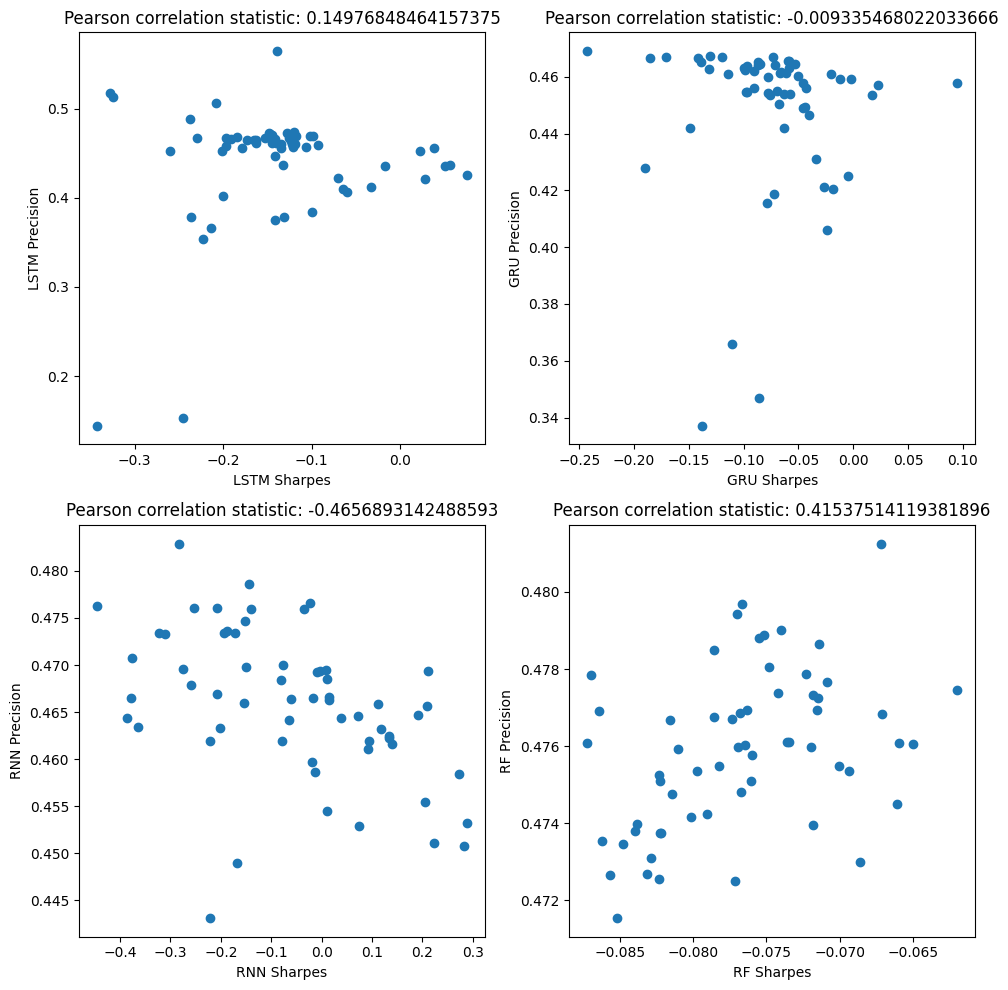

In [138]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = sharpes_precision_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"Pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} Sharpes")
    ax.set_ylabel(f"{model_list[i]} Precision")

plt.tight_layout()
plt.show()

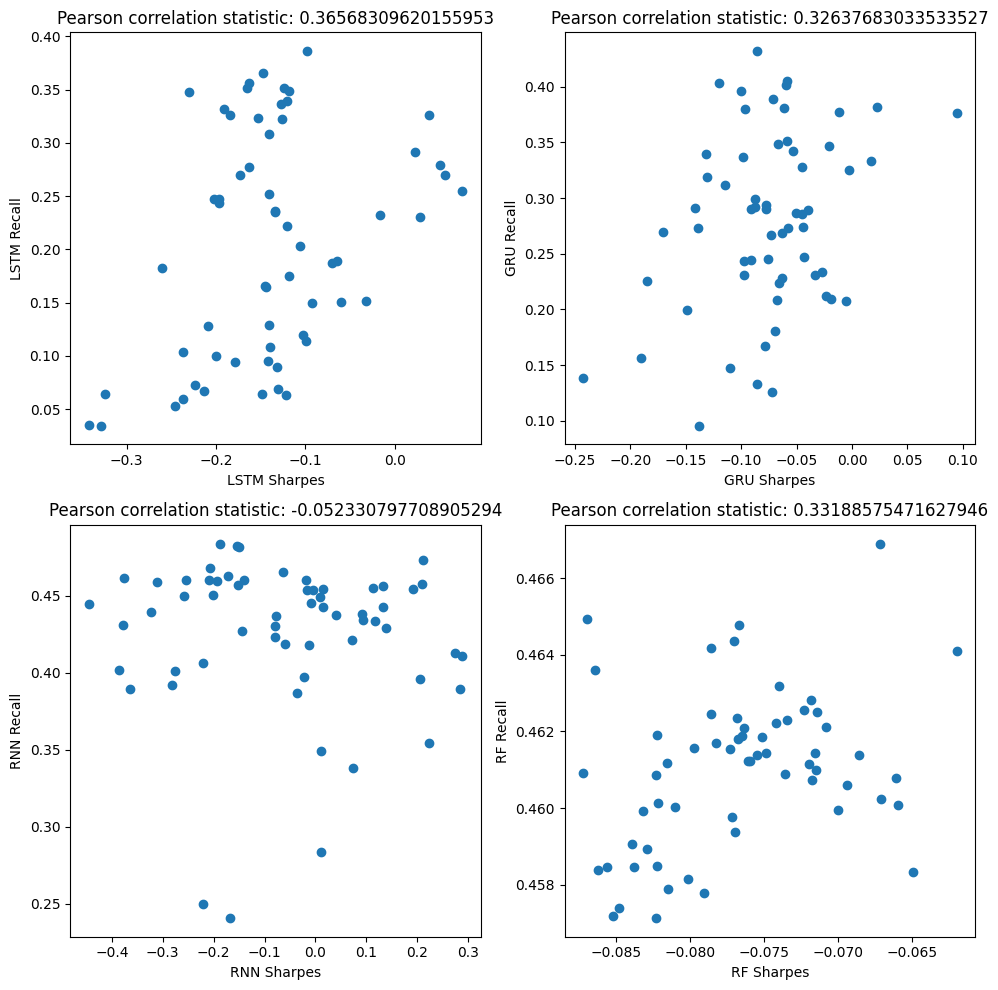

In [139]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

for i, ax in enumerate(axes):
    x, y = sharpes_recalls_pairs[i]
    ax.scatter(x, y)
    ax.set_title(f"Pearson correlation statistic: {pearsonr(x, y).statistic}")
    ax.set_xlabel(f"{model_list[i]} Sharpes")
    ax.set_ylabel(f"{model_list[i]} Recall")

plt.tight_layout()
plt.show()

Não há indicativos de que a precisão ou o recall sozinhos se correlacionam com uma carteira melhor, mais uma informação que corrobora com o argumento de que os experimentos não superam um modelo aleatório

É interessante observar também que a Random Forest sempre apresenta correlações arbitrariamente mais fortes entre as métricas clássicas e o sharpe ratio, mesmo que essa correlação não seja de fato forte, e mesmo que o sharpe ratio não seja satisfatório e que nenhum experimento supere a performance de um modelo aleatório. Isso pode indicar que esse modelo mais simples consegue aprender melhor os padrões para tomar melhores decisões, mesmo que essas decisões não sejam boas o suficiente para garantir um rendimento bom do portfólio

## Ensemble dos top 3 modelos

In [140]:
len(results_lstm_1)
all_preds_lstm = {}
all_preds_gru = {}
all_preds_rnn = {}
for stock in stocks:
    all_preds_lstm[stock] = [result[stock][1] for result in results_lstm_1]
    all_preds_gru[stock] = [result[stock][1] for result in results_gru_1]
    all_preds_rnn[stock] = [result[stock][1] for result in results_rnn_1]

print(len(all_preds_lstm["abev3"]))
print(len(list(all_preds_lstm["abev3"][0])))

all_preds_ensemble = {}
for stock in stocks:
    all_preds_ensemble[stock] = [[] for _ in range(len(all_preds_lstm["abev3"]))]

res_ensemble = []

for experiment in range(len(results_lstm_1)):
    partial_res = {}
    for stock in stocks:
        lstm = all_preds_lstm[stock][experiment]

        gru = all_preds_gru[stock][experiment]

        rnn = all_preds_rnn[stock][experiment]

        ensemble = [0 for _ in range(len(lstm))]
        
        for i in range(len(lstm)):
            triplet = [lstm[i], gru[i], rnn[i]]
            values = [list(item.values())[0] for item in triplet]
            if values.count(1) > values.count(0):
                ensemble[i] = {list(triplet[0].keys())[0]: 1}
            else:
                ensemble[i] = {list(triplet[0].keys())[0]: 0}

        preds_to_compute = [list(item.values())[0] for item in ensemble]
        grounds_to_compute = results_lstm_1[0][stock][0]["ground"]
        metrics = {
            "accuracy": accuracy_score(grounds_to_compute, preds_to_compute),
            "f1": f1_score(grounds_to_compute, preds_to_compute),
            "precision": precision_score(grounds_to_compute, preds_to_compute, zero_division=0),
            "recall": recall_score(grounds_to_compute, preds_to_compute),
        }
        partial_res[stock] = (metrics, ensemble)
    res_ensemble.append(partial_res)

60
3400


In [141]:
len(res_ensemble[0]["abev3"][1])

3400

In [142]:
best_results_ensemble, cuml_perf_ensemble, max_sharpe_ensemble, best_exp_idx_ensemble = find_best_experiment(res_ensemble)

Selected exp number 9


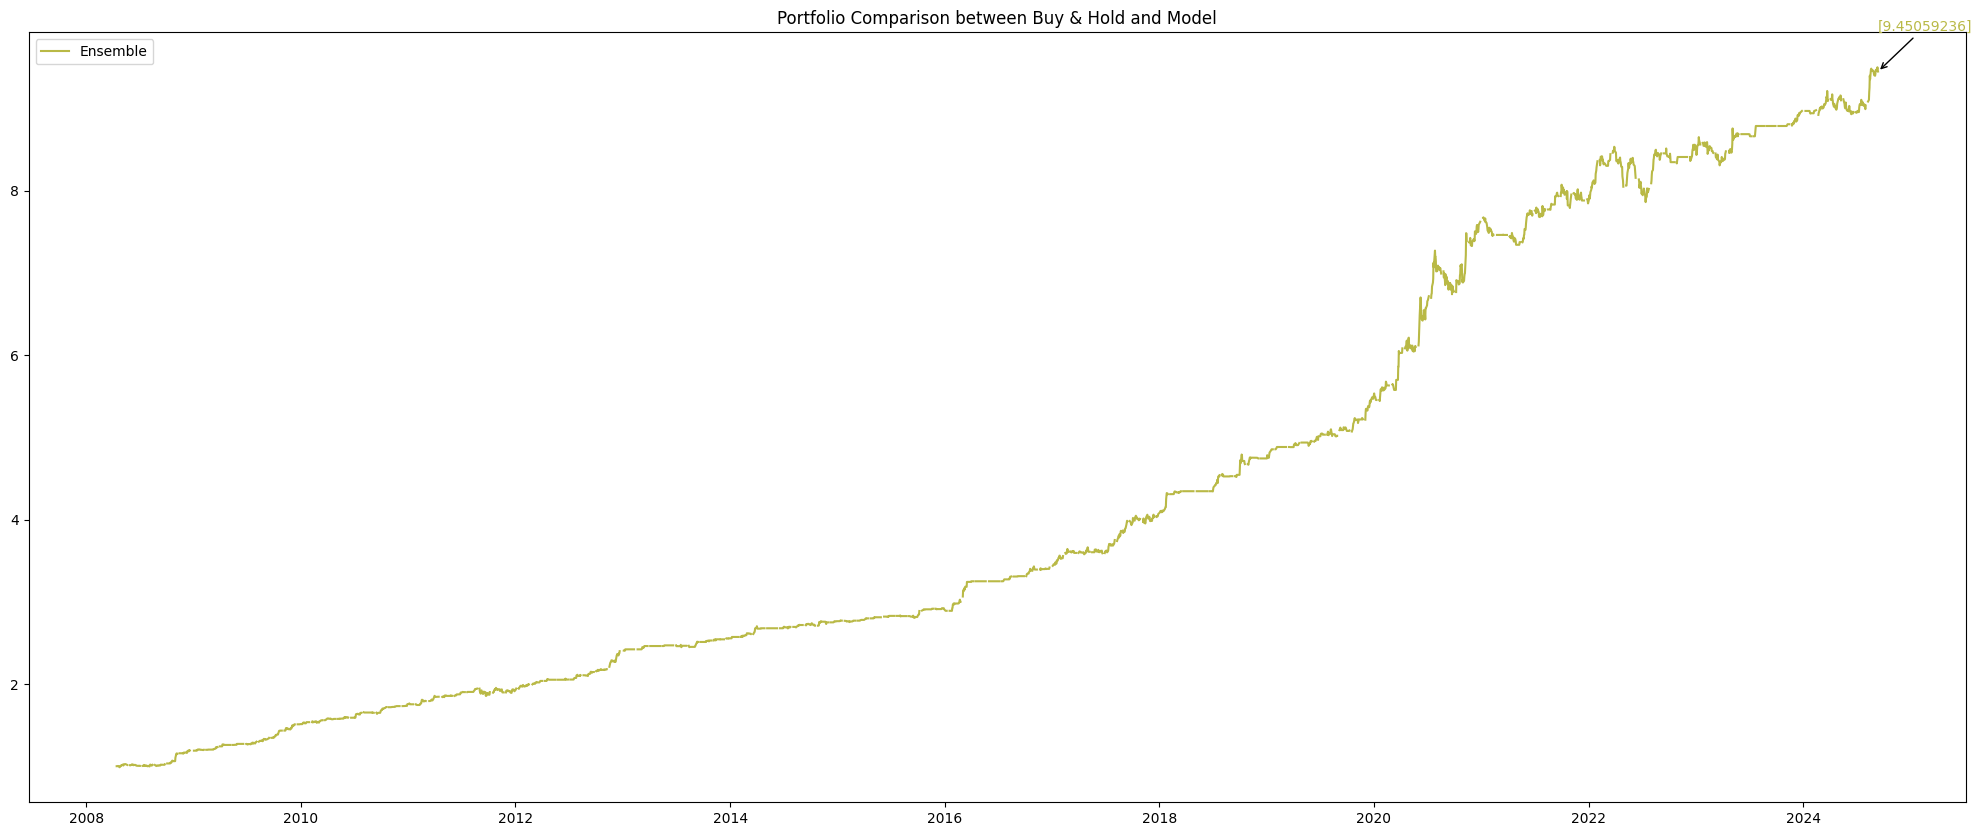

In [143]:
plot_many_returns_series([cuml_perf_ensemble], ["Ensemble"], daily_returns.index, colors=[model_colors.get("Ensemble")])

In [144]:
ensemble_sharpes = get_sharpe_series_from_results(res_ensemble)

In [145]:
ensemble_accs = get_metric_distribution_from_results(res_ensemble, "accuracy")

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_26105/2299270969.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(


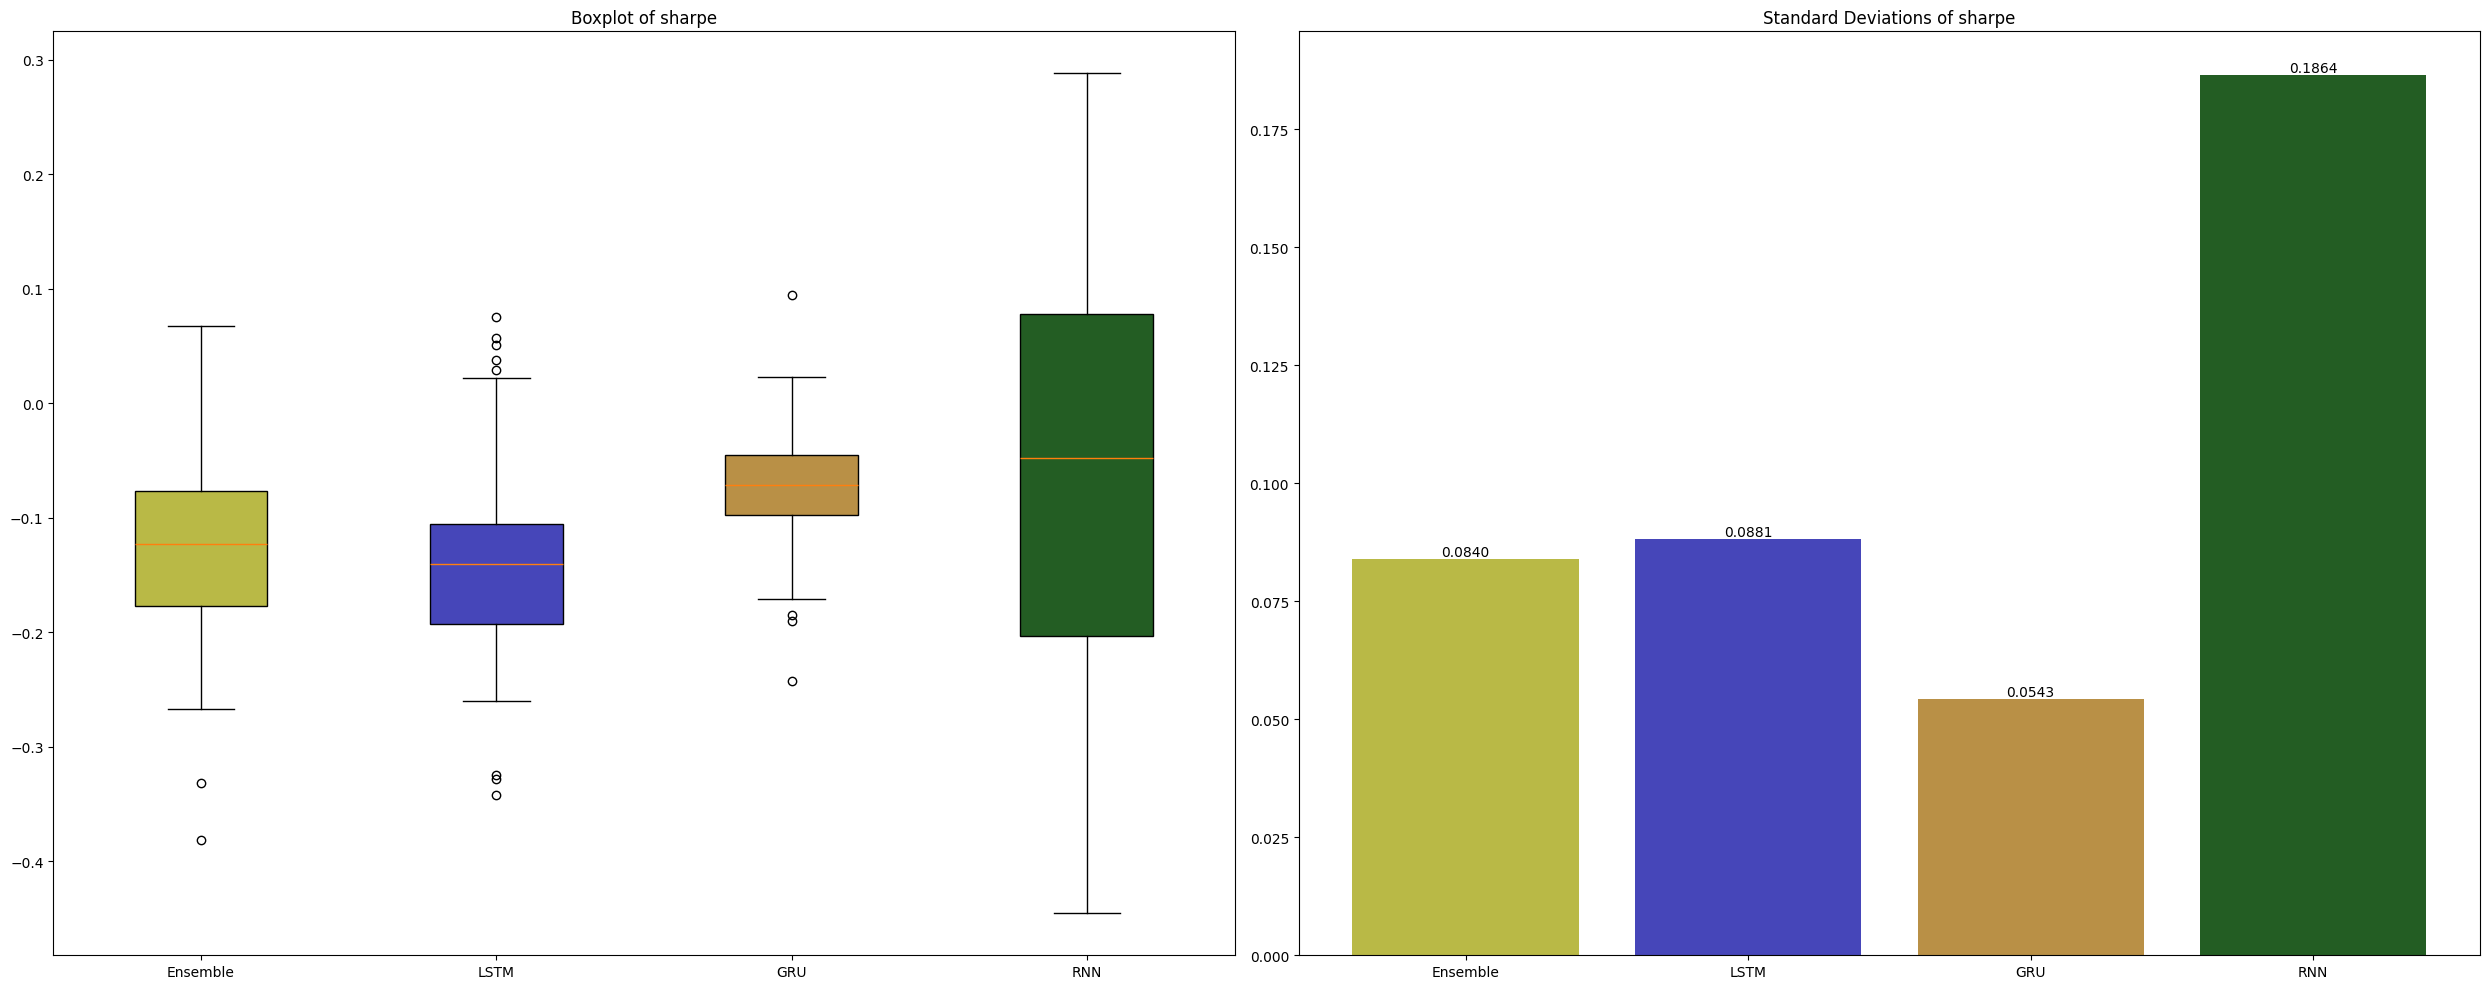

In [146]:
plot_distribution_and_stddev([ensemble_sharpes, lstm_sharpes_1, gru_sharpes_1, rnn_sharpes_1], metric="sharpe", models=["Ensemble", "LSTM", "GRU", "RNN"])

Por vias de Sharpe ratio, o ensemble dos top 3 modelos por sharpe ratio máximo não apresenta uma melhora significativa de performance

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_26105/2299270969.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(


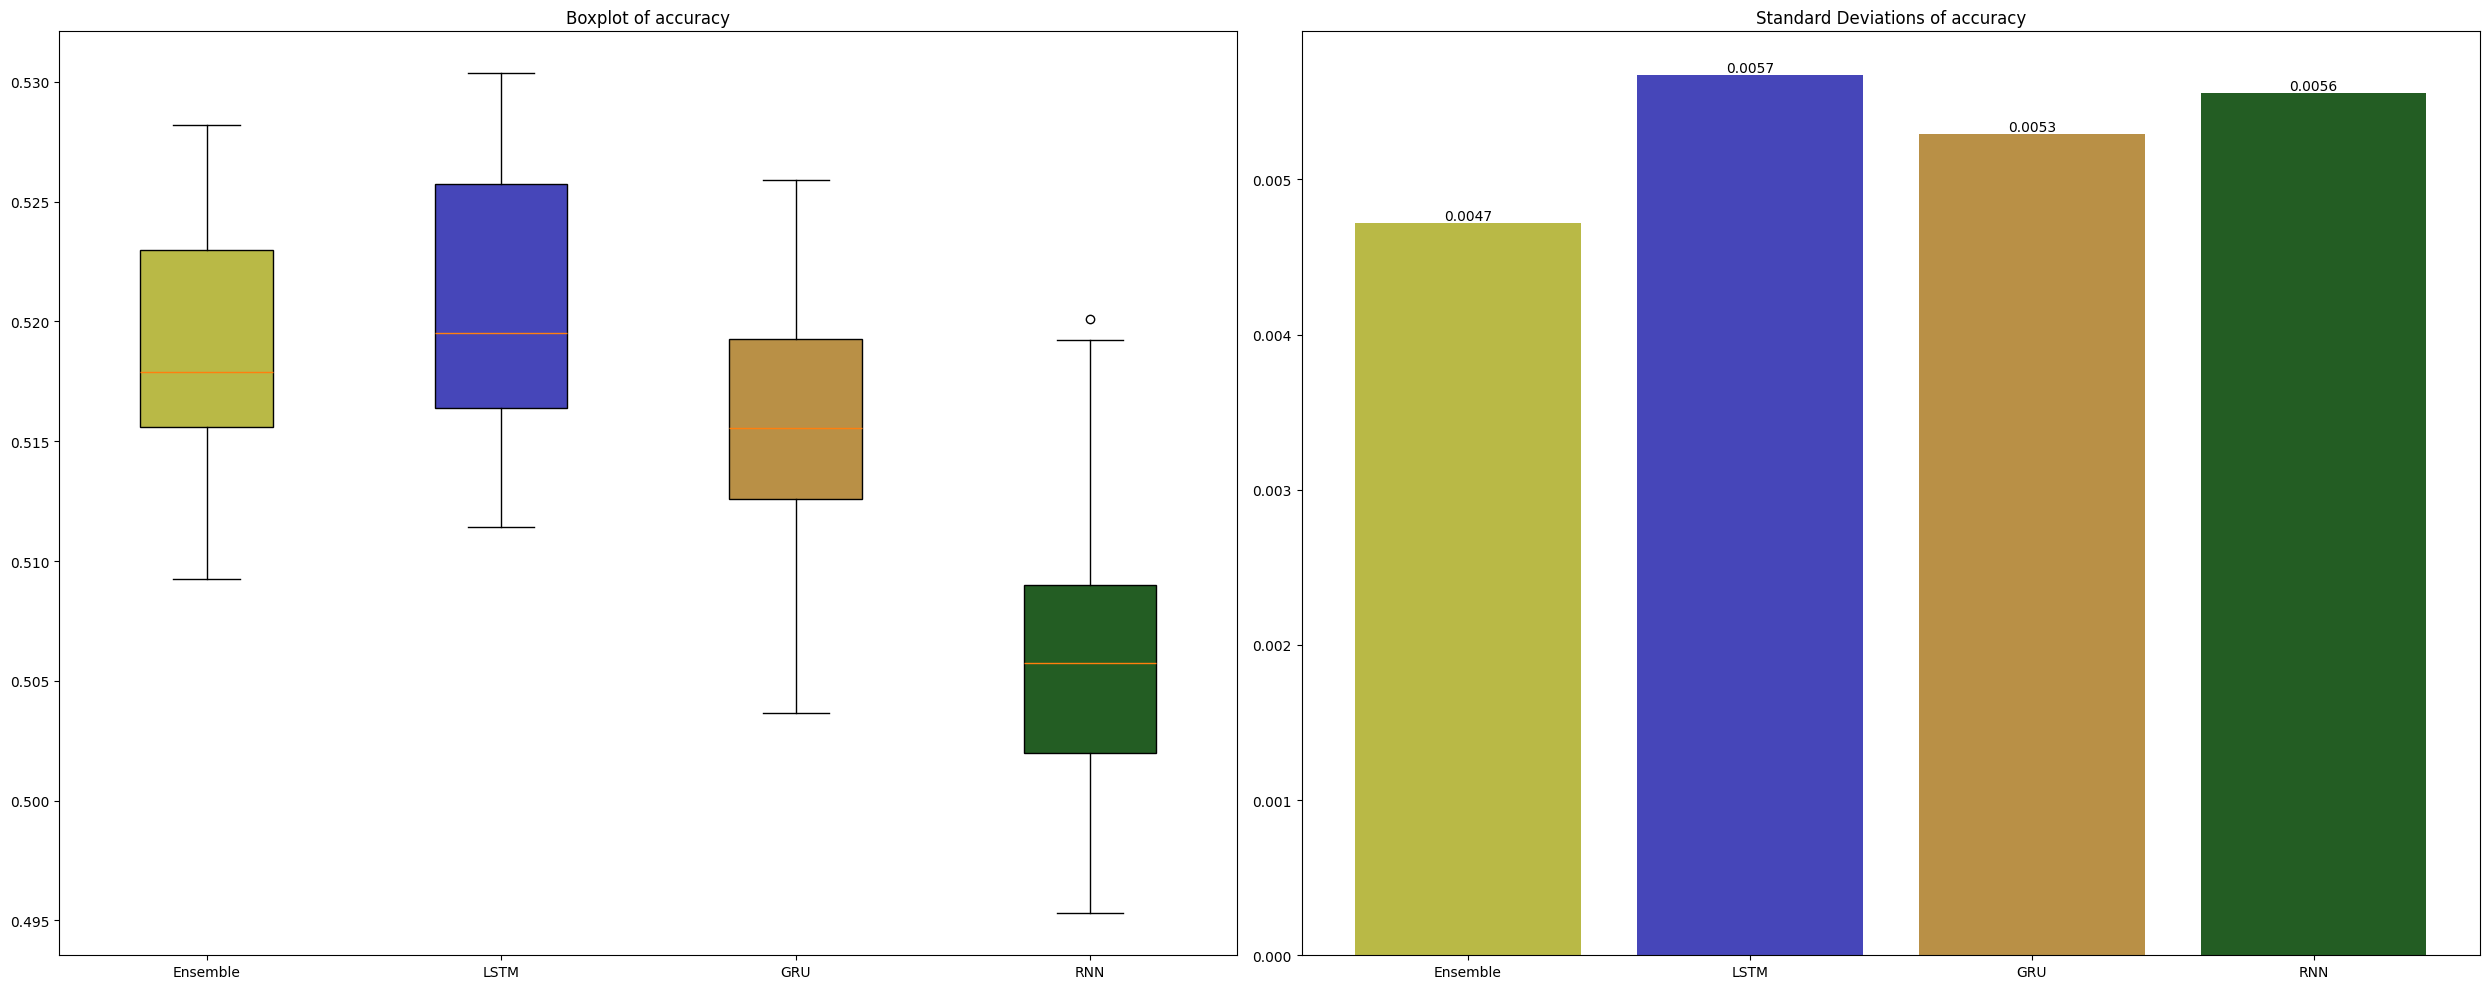

In [147]:
plot_distribution_and_stddev([ensemble_accs, lstm_accs_1, gru_accs_1, rnn_accs_1], metric="accuracy", models=["Ensemble", "LSTM", "GRU", "RNN"])

O modelo ensemble verifica uma melhora na distribuição das acurácias se comparado a RNN e GRU, mas ainda fica abaixo da LSTM

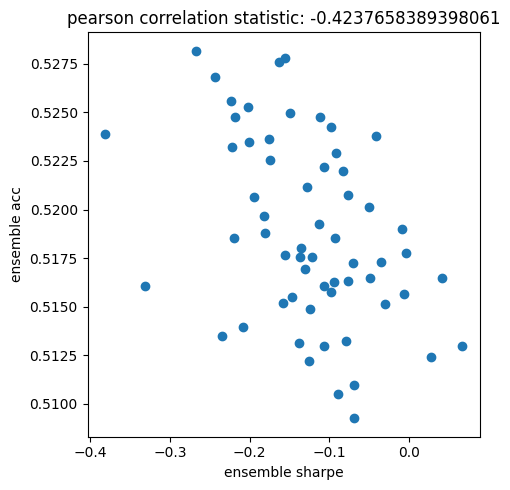

In [148]:
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

x, y = ensemble_sharpes, ensemble_accs
plt.scatter(x, y)
plt.title(f"pearson correlation statistic: {pearsonr(x, y).statistic}")
plt.xlabel(f"ensemble sharpe")
plt.ylabel(f"ensemble acc")

plt.tight_layout()
plt.show()

Não-surpreendente, um ensemble de modelos aparentemente aleatórios continua sem apresentar correlação entre uma boa acurácia e uma performance satisfatória da carteira

## Distribuição de Sharpe e Acurácia em todos os modelos

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_26105/2299270969.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(


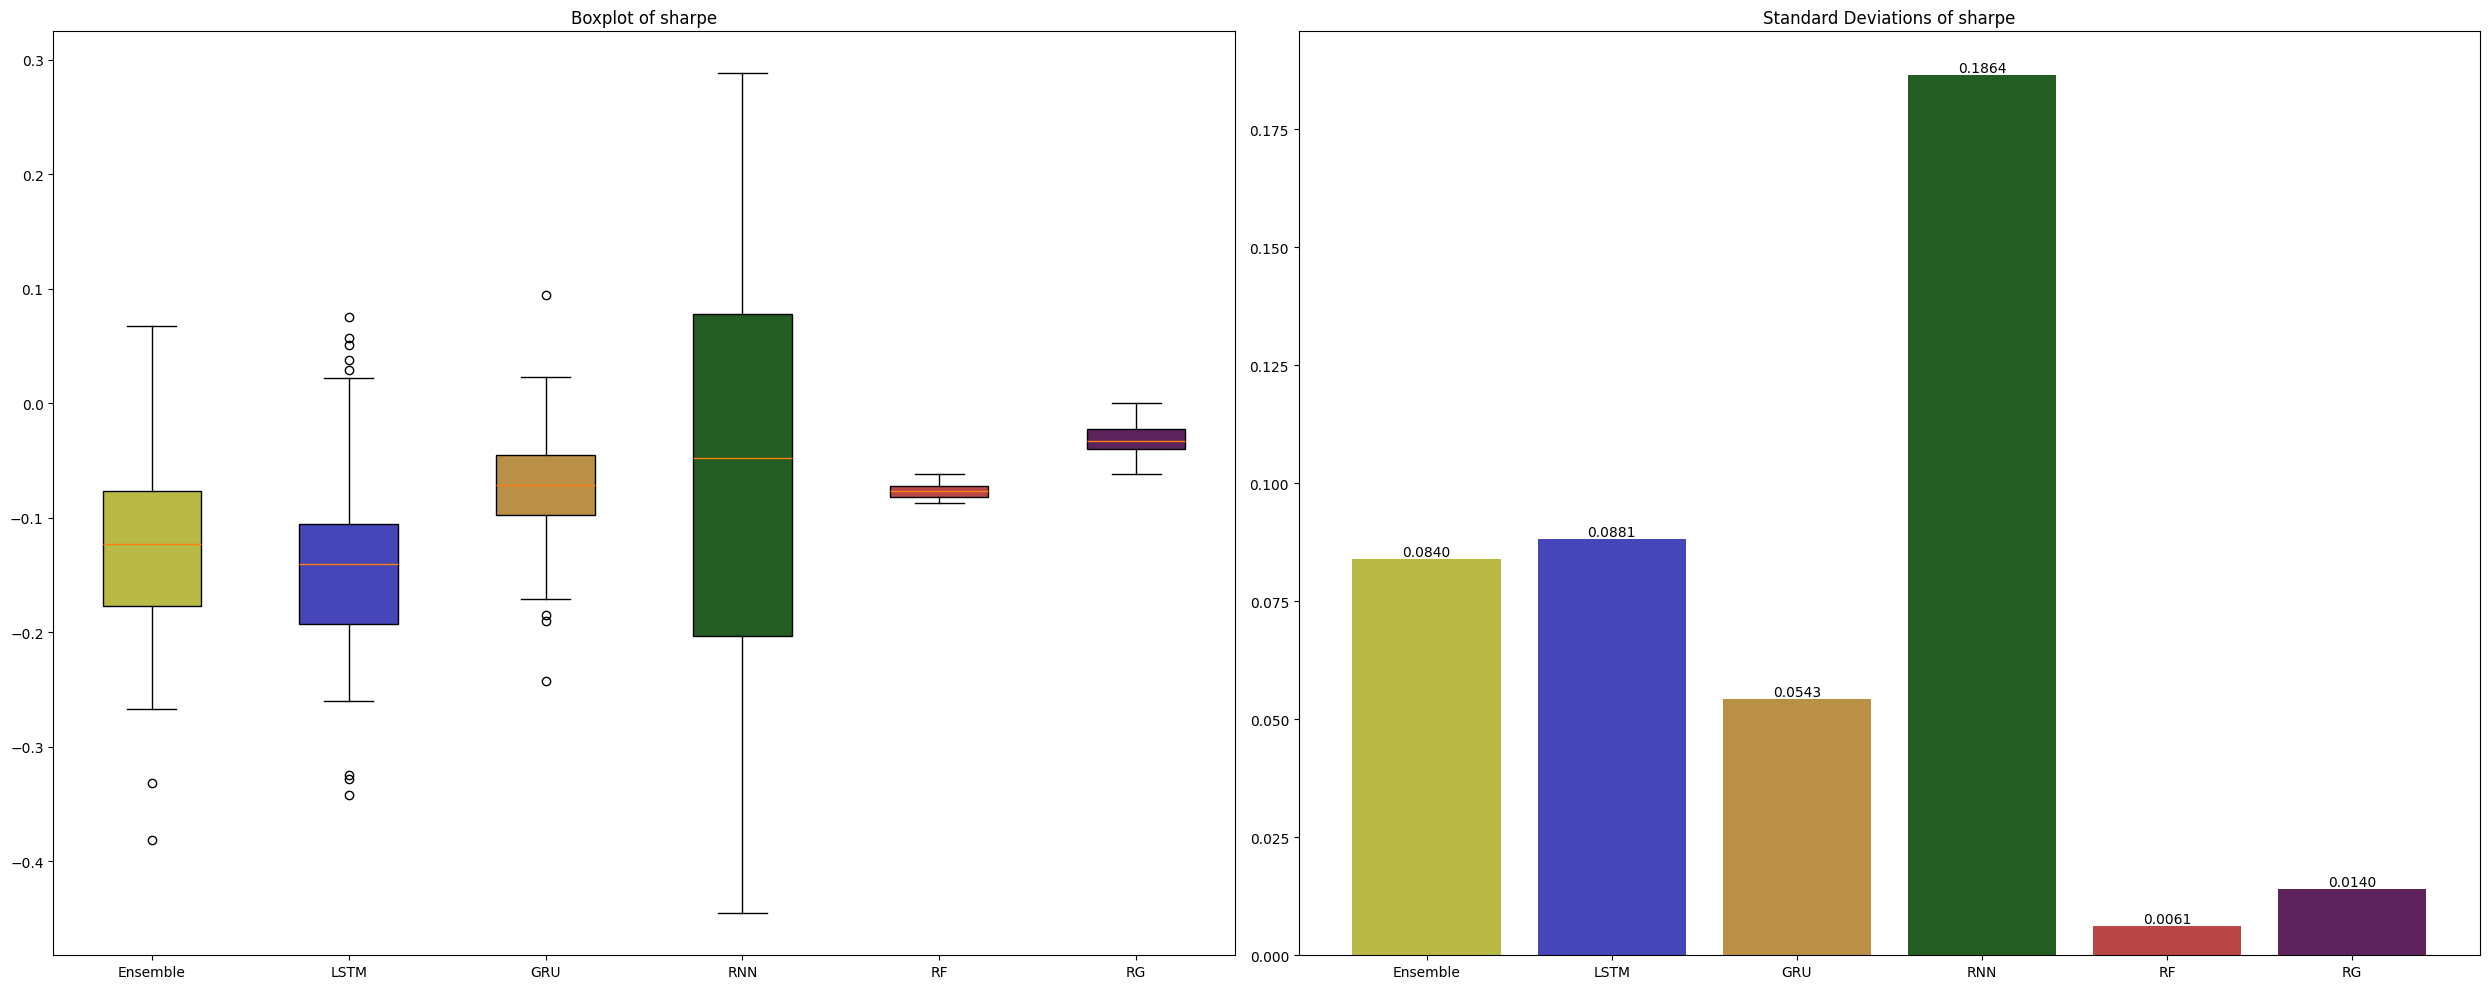

In [149]:
plot_distribution_and_stddev([ensemble_sharpes, lstm_sharpes_1, gru_sharpes_1, rnn_sharpes_1, rf_sharpes_1, rg_sharpes_1], metric="sharpe", models=["Ensemble", "LSTM", "GRU", "RNN", "RF", "RG"])

/var/folders/jq/tdq0h8rj1zdbxsbs18vhfp0h0000gp/T/ipykernel_26105/2299270969.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = axes[0].boxplot(


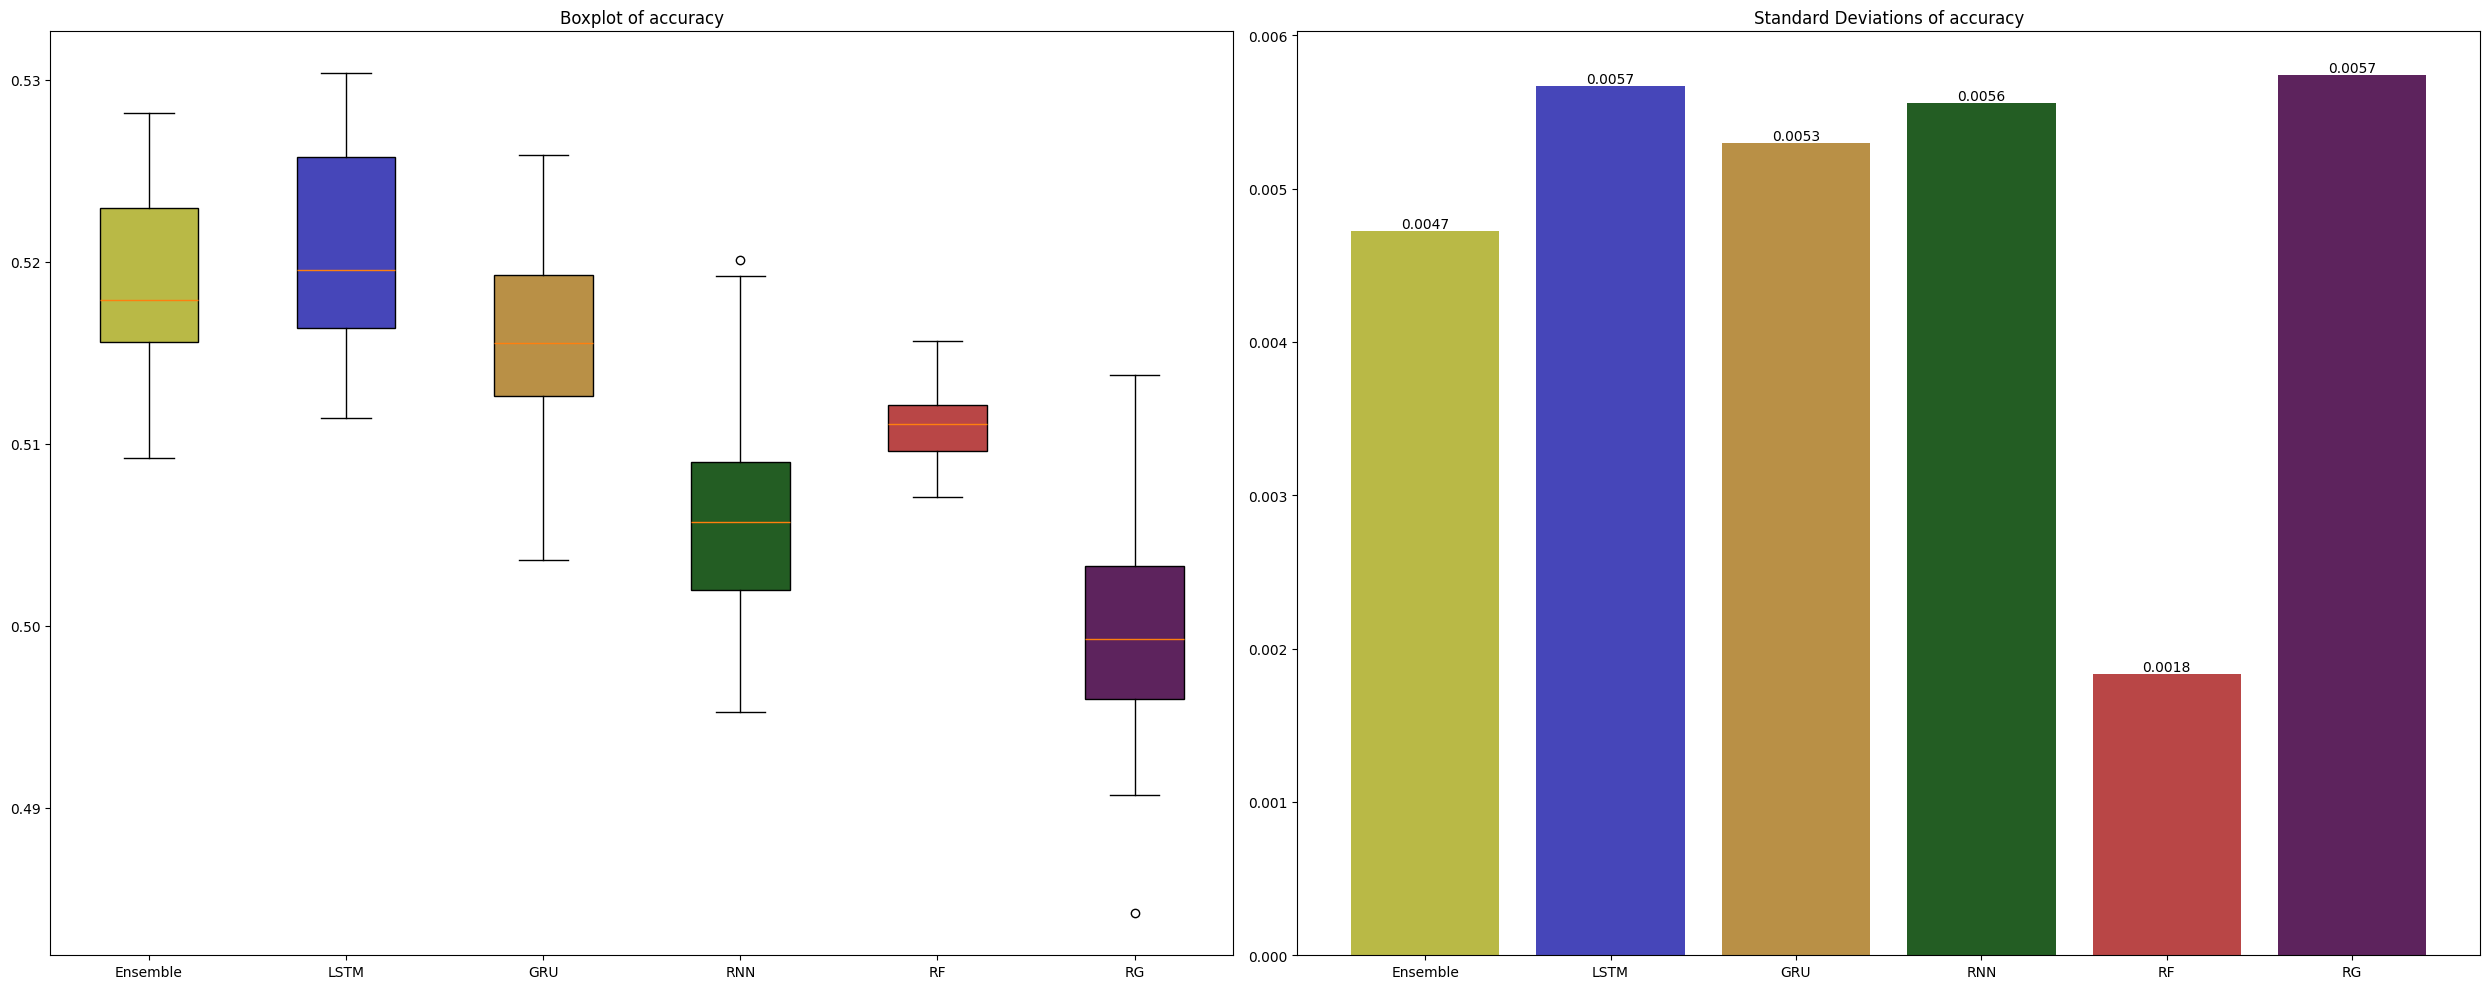

In [150]:
plot_distribution_and_stddev([ensemble_accs, lstm_accs_1, gru_accs_1, rnn_accs_1, rf_accs_1, rg_accs_1], metric="accuracy", models=["Ensemble", "LSTM", "GRU", "RNN", "RF", "RG"])

## Verificando diferença significativa nas acurácias

Para verificar se os modelos em média apresentam acurácias melhores do que o modelo de adivinhação aleatória, será aplicado um teste de hipótese para diferença das médias entre distribuições de acurácias. Para selecionar um teste, é necessário determinar se as distribuições apresentam normalidade.

In [151]:
list_of_dists = [ensemble_accs, lstm_accs_1, gru_accs_1, rnn_accs_1, rf_accs_1, rg_accs_1]
list_of_models = ["Ensemble", "LSTM", "GRU", "RNN", "RF", "RG"]

Shapiro-Wilk Statistic: 0.9738734138145015
P-Value: 0.22479785504461075
Fail to reject H0 for an alpha of 0.05, possibly normal distribution

Shapiro-Wilk Statistic: 0.9348581919626862
P-Value: 0.003211658363491964
H0 rejected for an alpha of 0.05, distribution can't be assumed Normal

Shapiro-Wilk Statistic: 0.9843821418149314
P-Value: 0.6379485353088269
Fail to reject H0 for an alpha of 0.05, possibly normal distribution

Shapiro-Wilk Statistic: 0.9669652588922706
P-Value: 0.10351485547570272
Fail to reject H0 for an alpha of 0.05, possibly normal distribution

Shapiro-Wilk Statistic: 0.989726112336676
P-Value: 0.8953894732527239
Fail to reject H0 for an alpha of 0.05, possibly normal distribution

Shapiro-Wilk Statistic: 0.9875314437384953
P-Value: 0.7990976311430349
Fail to reject H0 for an alpha of 0.05, possibly normal distribution



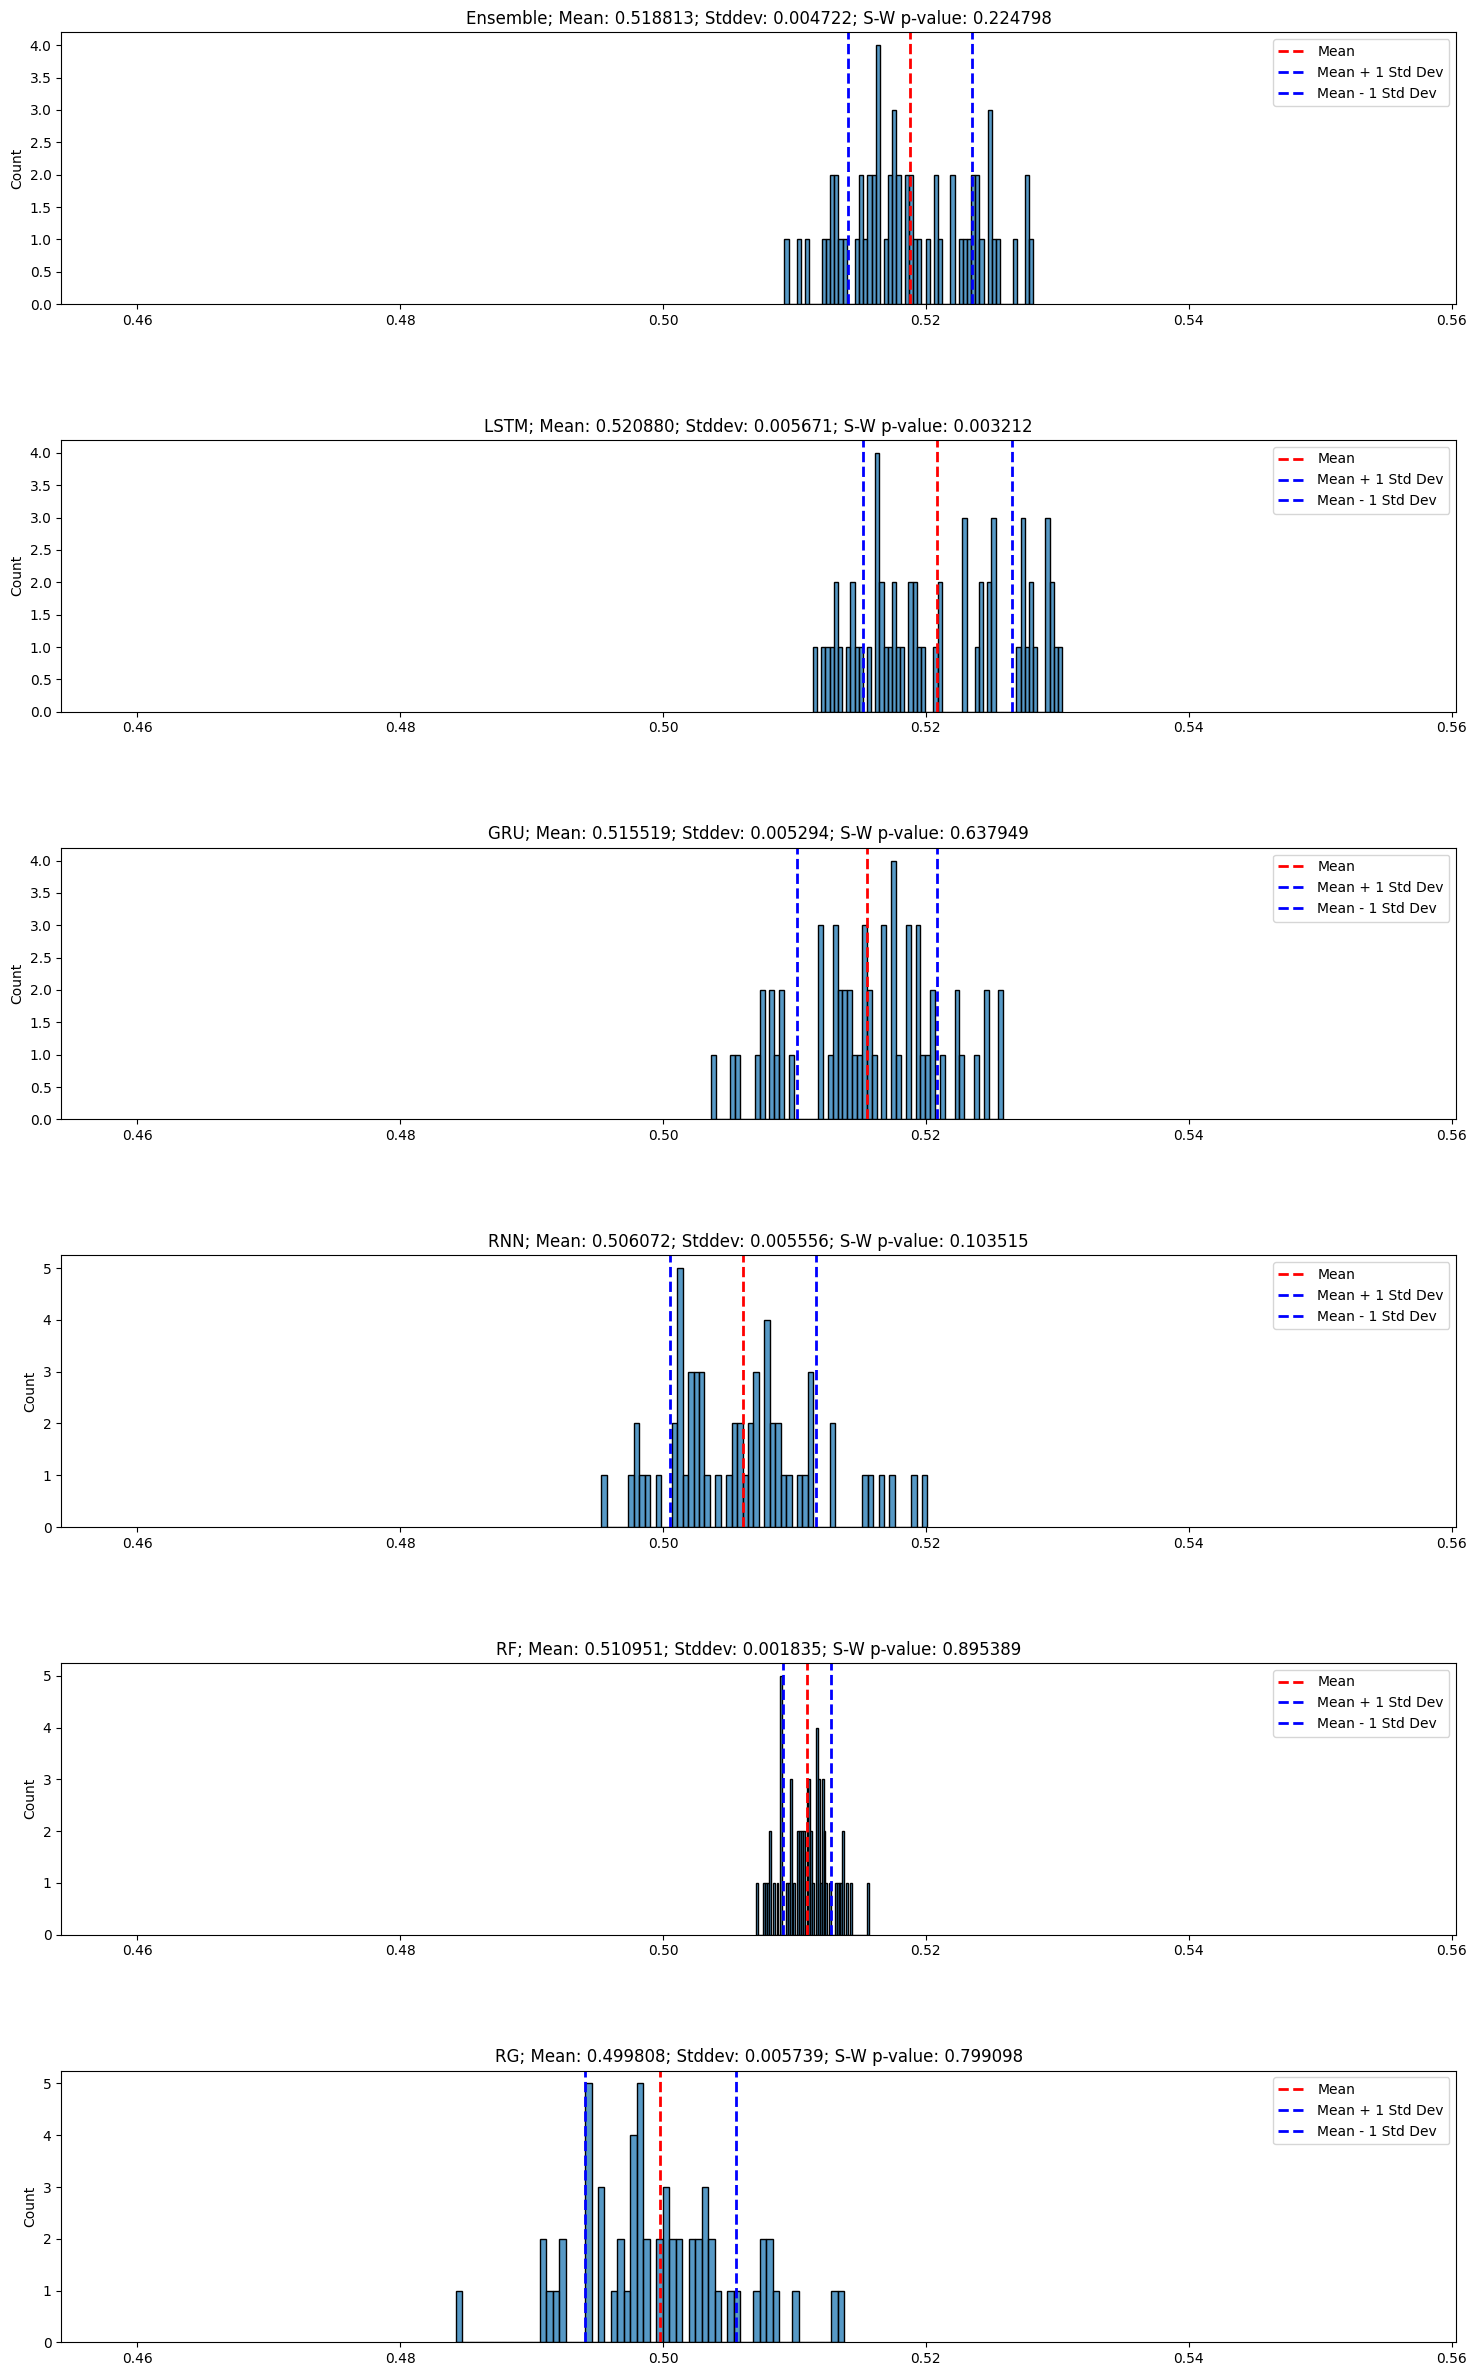

In [152]:
all_return_data = np.concatenate(list_of_dists)
global_min_return = np.min(all_return_data)
global_max_return = np.max(all_return_data)

plt.figure(figsize=(18, 30))
for i, dist in enumerate(list_of_dists):

    _, p_value = shapiro_wilk_gaussian_test(dist)
    print("")

    mean = np.array(dist).mean()
    std = np.array(dist).std()

    plt.subplot(len(list_of_dists), 1, i+1)
    plt.axis(True)
    sns.histplot(data=dist, kde=False, bins=len(dist))
    plt.axvline(mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean')
    plt.axvline(mean + std, color='blue', linestyle='dashed', linewidth=2, label=f'Mean + 1 Std Dev')
    plt.axvline(mean - std, color='blue', linestyle='dashed', linewidth=2, label=f'Mean - 1 Std Dev')
    plt.title(f"{list_of_models[i]}; Mean: {mean:.6f}; Stddev: {std:.6f}; S-W p-value: {p_value:.6f}")
    plt.legend(frameon=True)
    plt.xlim(global_min_return - 0.03, global_max_return + 0.03)
    plt.subplots_adjust(wspace=0.2, hspace=0.5)

Uma das distribuições de acurácias não aparenta ser normalmente distribuída, então não se pode assumir o uso de um teste paramétrico como o ANOVA. Será utilizada sua contra-parte não paramétrica, o teste de Kruskal-Wallis, que estende o teste Mann-Whitney-U para vários grupos

In [153]:
def kruskal_wallis_test(groups):
    alpha = 0.05

    h_statistic, p_value = kruskal(*groups)
    
    print(f"H-statistic: {h_statistic}")
    print(f"p-value: {p_value}")

    if p_value < alpha:
        print(f"There is a significant difference between at least two groups for an alpha of {alpha}")
    else:
        print(f"There is NOT a significant difference between groups for an alpha of {alpha}")

kruskal_wallis_test(list_of_dists)

H-statistic: 252.15398342287023
p-value: 1.896410939060919e-52
There is a significant difference between at least two groups for an alpha of 0.05


KW aponta diferença significativa entre pelo menos 2 grupos. Será aplicado o teste de Dunn par a par com correção de Bonferroni para determinar diferença entre cada grupo com ajuste contra falsos positivos (erro tipo 1 - rejeitar H0 quando não deveria)

ensemble_accs, lstm_accs_1, gru_accs_1, rnn_accs_1, rf_accs_1, rg_accs_1

In [154]:
group_rename_map = {1: 'Ensemble Acc', 2: 'LSTM Acc', 3: 'GRU Acc', 4: 'RNN Acc', 5: 'RF Acc', 6: 'RG Acc'}

posthoc_results = posthoc_dunn(list_of_dists, p_adjust='bonferroni')
posthoc_results.rename(index=group_rename_map, columns=group_rename_map, inplace=True)

print(f"Pairwise Dunn's test results (Bonferroni corrected p-values):\n {posthoc_results.to_string()}")

Pairwise Dunn's test results (Bonferroni corrected p-values):
               Ensemble Acc      LSTM Acc       GRU Acc       RNN Acc        RF Acc        RG Acc
Ensemble Acc  1.000000e+00  1.000000e+00  3.794491e-01  2.361927e-17  3.040726e-08  8.664977e-30
LSTM Acc      1.000000e+00  1.000000e+00  1.857985e-02  2.115951e-21  4.164665e-11  4.993370e-35
GRU Acc       3.794491e-01  1.857985e-02  1.000000e+00  8.783818e-10  2.561226e-03  1.526148e-19
RNN Acc       2.361927e-17  2.115951e-21  8.783818e-10  1.000000e+00  7.940520e-02  7.983634e-02
RF Acc        3.040726e-08  4.164665e-11  2.561226e-03  7.940520e-02  1.000000e+00  3.703559e-07
RG Acc        8.664977e-30  4.993370e-35  1.526148e-19  7.983634e-02  3.703559e-07  1.000000e+00


In [155]:
7.98e-2 > 0.05

True

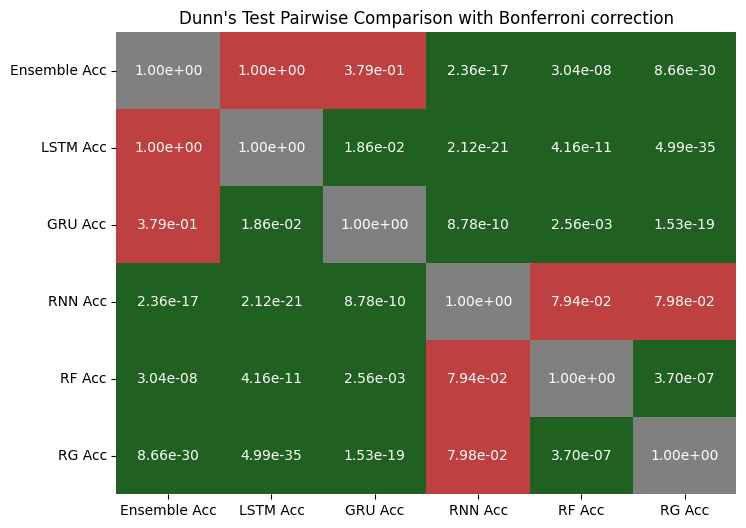

In [166]:
# Convert DataFrame to NumPy array
p_values = posthoc_results.to_numpy()

# Create a color mask
colors = np.full(p_values.shape, "", dtype=object)

# Apply colors
for i in range(p_values.shape[0]):
    for j in range(p_values.shape[1]):
        if i == j:
            colors[i, j] = adjust_saturation('grey')  # Grey for diagonal
        elif p_values[i, j] > 0.05:
            colors[i, j] = adjust_saturation('red')  # Not significant (p > 0.05)
        else:
            colors[i, j] = adjust_saturation('green')  # Significant (p ≤ 0.05)

# Plot using seaborn heatmap
plt.figure(figsize=(8, 6))
ax = sns.heatmap(posthoc_results, annot=True, fmt=".2e", cmap=['green', 'grey', 'red'], cbar=False)

# Apply custom face color to each cell
for i in range(p_values.shape[0]):
    for j in range(p_values.shape[1]):
        ax.add_patch(plt.Rectangle((j, i), 1, 1, fill=True, color=colors[i, j], lw=0))

plt.title("Dunn's Test Pairwise Comparison with Bonferroni correction")

# Show plot
plt.show()

Na análise par-a-par, todos os modelos exceto a RNN são significantemente diferentes do modelo aleatório. O que esse teste aponta é que, com a correção contra falsos-positivos, a evidência não é suficiente para concluir que a distribuição de acurácias da RNN e do modelo aleatório vem de distribuições diferentes

## Distribuição de Classes Preditas

In [157]:
pd.Series(list(item.values())[0] for item in results_lstm_1[best_exp_idx_lstm]["abev3"][1]).value_counts()

0    2895
1     505
Name: count, dtype: int64

In [158]:
def print_class_distributions_for_experiment(experiments, best_idx, model):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    fig.suptitle(f"Class distributions for best {model} experiment")

    for i, col in enumerate(stocks):
        best_pred_series = pd.Series(list(item.values())[0] for item in experiments[best_idx][col][1])
        bars = axes[i].bar(["False", "True"], best_pred_series.value_counts())
        for bar in bars:
            height = bar.get_height()
            axes[i].text(
                bar.get_x() + bar.get_width() / 2,
                height,
                f'{height}',
                ha='center', va='bottom'
            )
        axes[i].set_title(f"class distribution for {col.upper()}")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

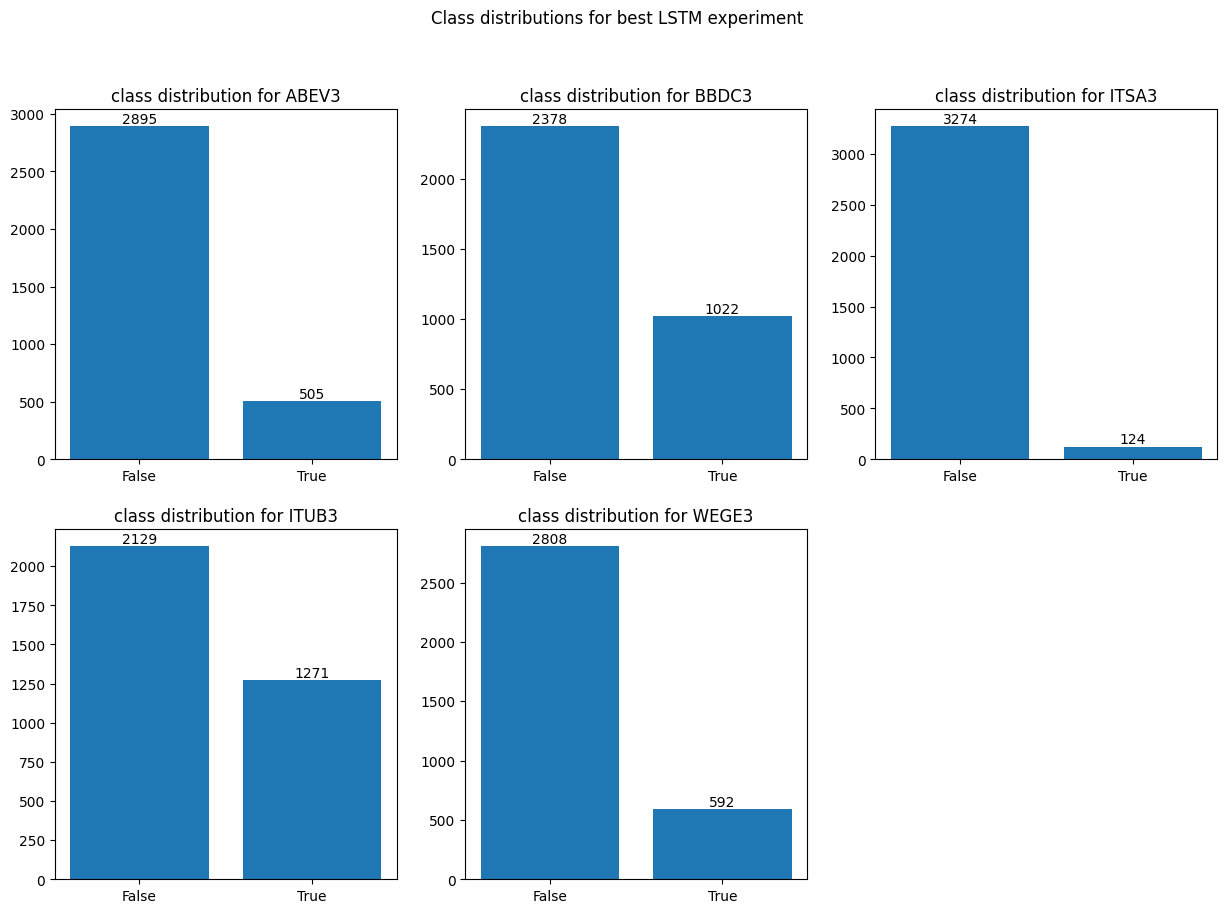

In [159]:
print_class_distributions_for_experiment(results_lstm_1, best_exp_idx_lstm, "LSTM")

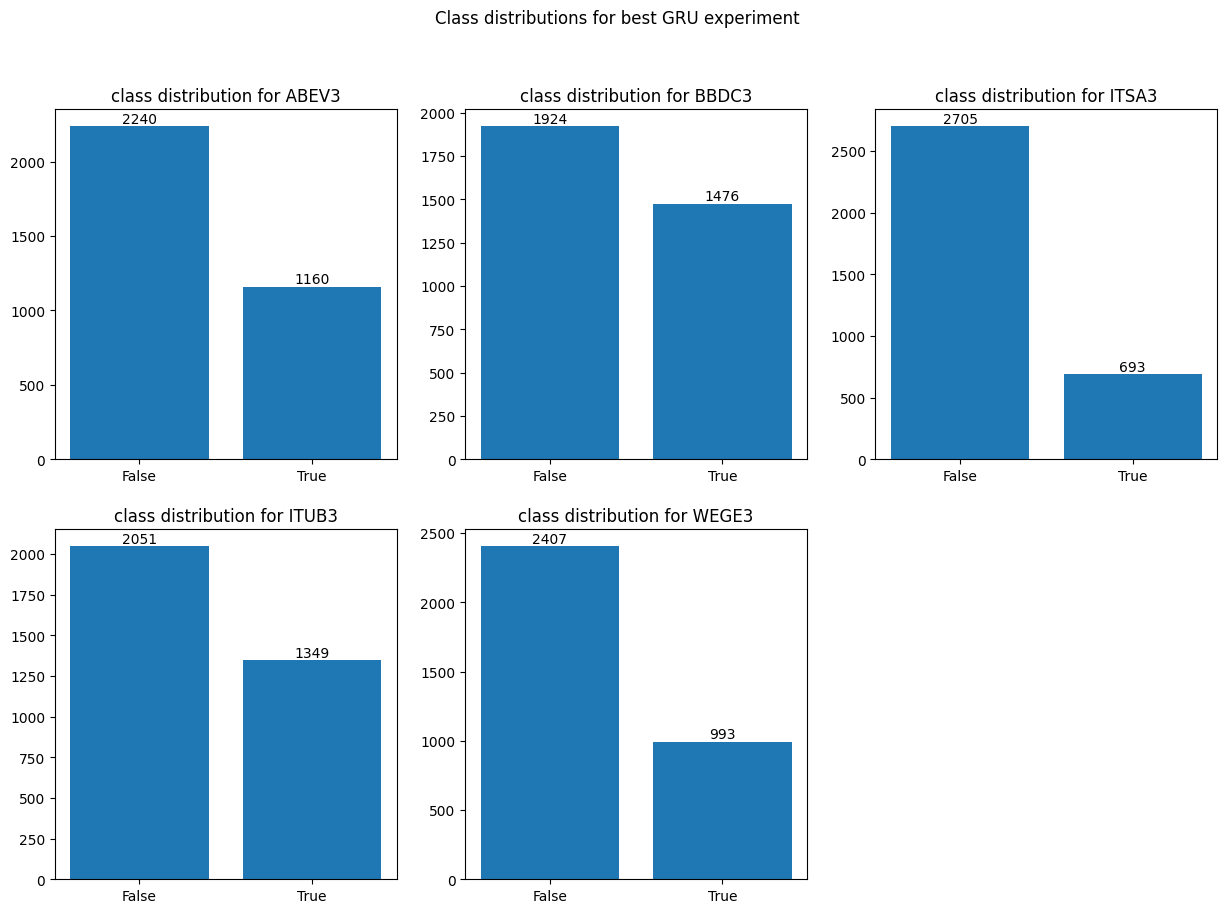

In [160]:
print_class_distributions_for_experiment(results_gru_1, best_exp_idx_gru, "GRU")

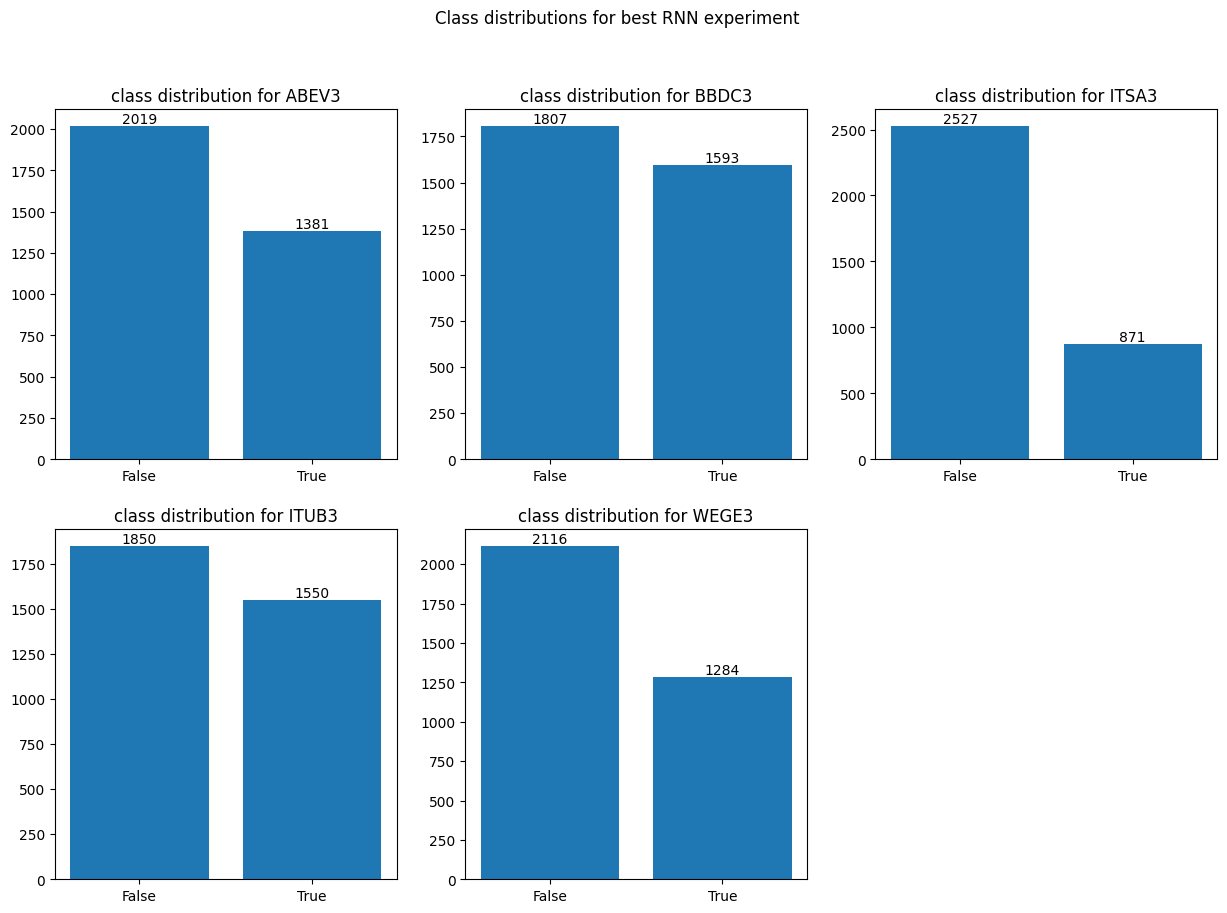

In [161]:
print_class_distributions_for_experiment(results_rnn_1, best_exp_idx_rnn, "RNN")

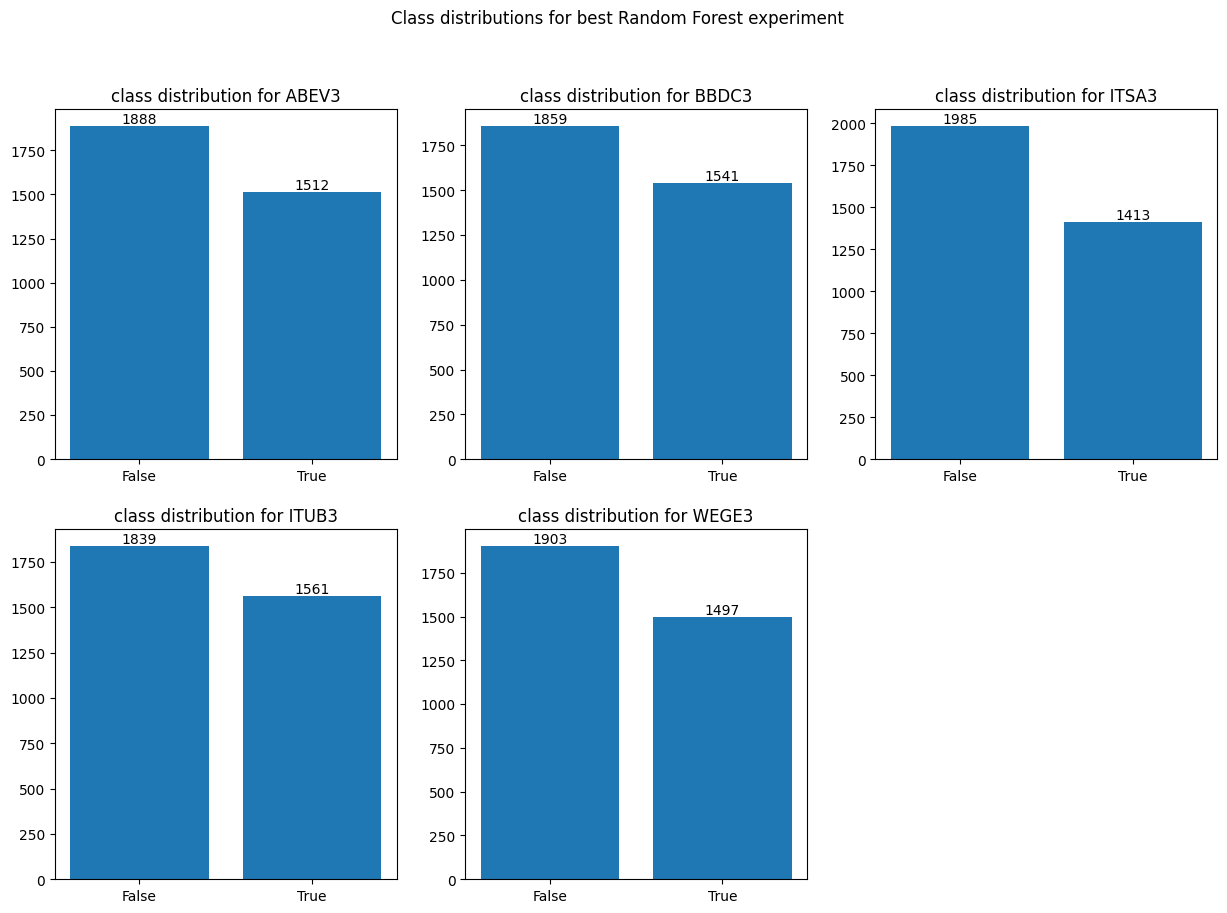

In [162]:
print_class_distributions_for_experiment(results_rf_1, best_exp_idx_rf, "Random Forest")

Um fato de destaque é o de todos os modelos treinados priorizarem a classe False na previsão. A LSTM principalmente comete muito isso. Por classificar muitas instâncias como False, o modelo pode acabar capturando muitas que realmente são False, assim rendendo uma acurácia superior aos outros mas não por um poder de decisão superior, e sim por um chute deseducado.

## Retornos cumulativos médios

In [163]:
def plot_mean_and_stddev(means, std_devs, metric, models=["LSTM", "GRU", "RNN", "RF", "RG", "Ensemble"]):
    fig, axes = plt.subplots(1, 2, figsize=(25, 10))

    labels = [models[i] for i in range(len(means))]

    # --- Mean Bar Chart ---
    bars1 = axes[0].bar(
        labels, 
        means, 
        color=[model_colors.get(model, "gray") for model in labels]
    )
    
    # Add value labels on top of bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.4f}',
            ha='center', va='bottom'
        )

    axes[0].set_title(f'Mean of {metric}')

    # --- Std Dev Bar Chart ---
    bars = axes[1].bar(
        labels,
        std_devs, 
        color=[model_colors.get(model, "gray") for model in labels]  # Apply consistent colors
    )

    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        axes[1].text(
            bar.get_x() + bar.get_width() / 2,
            height,
            f'{height:.4f}',
            ha='center', va='bottom'
        )

    axes[1].set_title(f'Standard Deviations of {metric}')

    plt.tight_layout()
    plt.show()

In [164]:
lstm_mean_cuml_returns, lstm_std_cuml_returns = get_mean_cuml_returns_across_exps(results_lstm_1)
gru_mean_cuml_returns, gru_std_cuml_returns = get_mean_cuml_returns_across_exps(results_gru_1)
rnn_mean_cuml_returns, rnn_std_cuml_returns = get_mean_cuml_returns_across_exps(results_rnn_1)
rf_mean_cuml_returns, rf_std_cuml_returns = get_mean_cuml_returns_across_exps(results_rf_1)
rg_mean_cuml_returns, rg_std_cuml_returns = get_mean_cuml_returns_across_exps(results_rg_1)
ensemble_mean_cuml_returns, ensemble_std_cuml_returns = get_mean_cuml_returns_across_exps(res_ensemble)

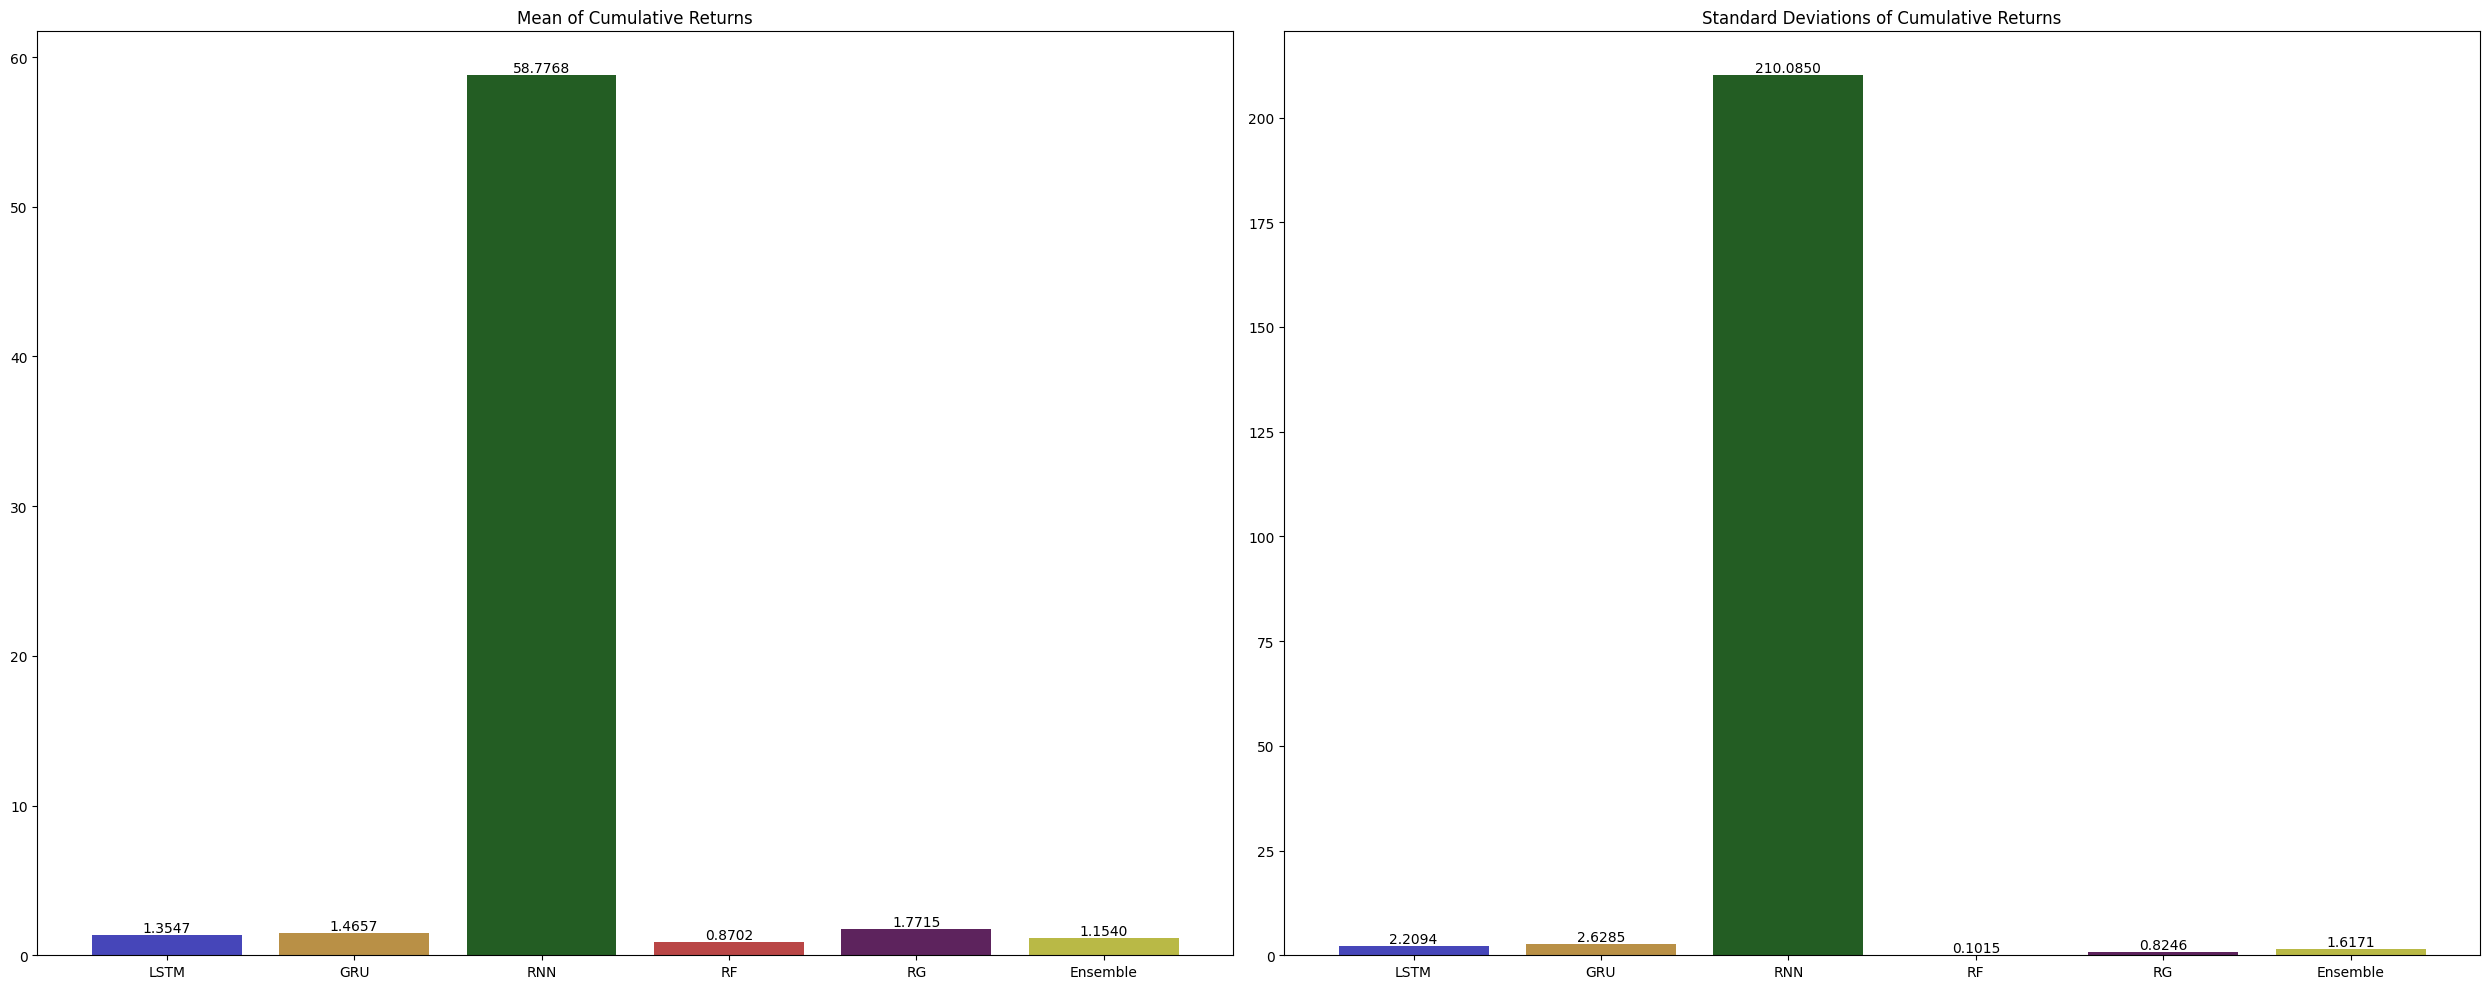

In [165]:
plot_mean_and_stddev([
    lstm_mean_cuml_returns,
    gru_mean_cuml_returns,
    rnn_mean_cuml_returns,
    rf_mean_cuml_returns,
    rg_mean_cuml_returns,
    ensemble_mean_cuml_returns
], [
    lstm_std_cuml_returns,
    gru_std_cuml_returns,
    rnn_std_cuml_returns,
    rf_std_cuml_returns,
    rg_std_cuml_returns,
    ensemble_std_cuml_returns
], "Cumulative Returns")

TODO: 
- CAPTURAR CUML RETURNS mostrar no ULTIMO ponto, + pegar medias dos retornos de todas as execuções como NELSON
- Visualização de distribuição das classes preditas (do melhor exp de cada, comparar com prec x recall)
- mostrar box plots melhores
- mostrar correlações do modelo aleatorio tambem
- analise exploratoria dos resultados
    - visualizar confusion matrix?
    - visualizar superficie de decisao?
    - visualizar feature importances?
    - interpretar sharpe ratio (CONSERTAR SHARPE PRA USAR STDDEV DE AMOSTRA ddof=1)
- formulação de hipoteses sobre os dados -> sharpe
    - analise da potencia e tamanho do efeito antes (depois nao eh valido)
- melhorar TODOS os gráficos
- SHAP chart